### This is Matt Kennedy's submission for Aunalytics' Data Science Assessment.
I will start with a visualization of each feature, then work into preprocessing. Next, I will use several different classification methods, and end with analysis and segmentation.


##### Please note - any time the numbers '0' and '1' are used when referring to classes, classification, or targets, '0' means '<=50k annual salary', and '1' means '>50k annual salary'.

#### Table of Contents
* [Visualization](#Visualization)
 * [Age](#Age)
 * [Workclass](#Workclass)
 * [Fnlwgt](#Fnlwgt)
 * [Education](#Education)
 * [Marital-status](#Marital-status)
 * [Occupation](#Occupation)
 * [Race](#Race)
 * [Sex](#Sex)
 * [Capital-gain](#Capital-gain)
 * [Capital-loss](#Capital-loss)
 * [Hours-per-week](#Hours-per-week)
* [Chi-square-test](#Chi-square-test)


* [Data-preprocessing](#Data-preprocessing)
 * [Pruning](#Pruning)


* [Classification](#Classification)
 * [Neural-network](#Neural-network)
   * [Accuracy](#Neural-network-accuracy)
   * [Confusion matrix](#Neural-network-CM)
   * [Results](#Naive-bayes-results)
 * [Naive-bayes](#Naive-bayes)
   * [Accuracy](#NB-accuracy)
   * [Confusion matrix](#NB-CM)
   * [Results](#NB-results)  
 * [SVM](#Support-vector-machines)
   * [Accuracy](#SVM-accuracy)
   * [Confusion matrix](#SVM-CM)
   * [Results](#SVM-results) 
 * [ROC-curves](#ROC-curves)
 

* [Segmentation](#Segmentation)
   * [Manual-segmentation](#Manual-segmentation)
   * [Automated-segmentation](#Automated-segmentation)

In [10]:
#Imports used for NN
import pandas as pd
import tensorflow as tf
import numpy as np

#Used for visualization
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import plot_roc_curve, roc_curve, auc, confusion_matrix

#General use
from collections import defaultdict
import math
import time

In [11]:
#Methods are used through this notebook

#Loads train/test datasets
def load_datasets():
    
    #First row is headers, so just simple import on the csv data using pandas
    train_csv = pd.read_csv("au_train.csv")
    test_csv = pd.read_csv("au_test.csv")

    #Remove period from last character in class for test cases
    test_csv['class'] = test_csv['class'].str.replace('.', '')
    
    return train_csv, test_csv

#Convert object columns to discrete numerical values
def convert_to_discrete(ds):
    for col in ds:
        if ds[col].dtype == np.dtype('object'):
            temp_col = pd.Categorical(ds[col])
            temp_col = temp_col.codes
            ds[col] = temp_col
    
    return ds

## Visualization

I'm starting with an analysis of this dataset's features. This will give us a better understanding of each feature, how it correlates, and later on, data-preprocessing as well as how we should segment.

In [ ]:
#Load data
train_csv, test_csv = load_datasets()
ds = pd.concat([train_csv, test_csv], axis=0)

"""
Creates and returns a bar chart
ds - dataset to evaluate
classes - different classes that an item can be categorized as (in this case, <=50k and >50k)
col - what column to look at
x - the x values for the bar chart
xlbl - the label for the x axis
ylbl - the label for the y axis
rotate - whether or not to rotate the x axis tickmarks

Returns:
y0 - Items belong to class <=50k
y1 - Items belong to class >50k
"""
def createBarChart(ds, classes, col, x, xlbl, ylbl, rotate=0):
    y = []
    for i in x:
        data = []
        for cls in classes:
            temp = ds.loc[(col == i) & (ds['class'] == cls)]
            data.append(temp.size)
        y.append(data)
    
    y0 = [i[0] for i in y]
    y1 = [i[1] for i in y]
    
    width = 0.5
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_axes([0,0,1,1])
    ax.bar(x, y0, width, color='g', label='<=50k')
    ax.bar(x, y1, width,bottom=y0, color='b', label='>50k')
    if rotate > 0:
        ax.set_xticklabels(x, rotation=rotate)
    ax.set_xlabel(xlbl)
    ax.set_ylabel(ylbl)
    ax.legend()
    ax.set_title("{} vs annual salary".format(col.name.capitalize()))
    plt.show()
    
    return y0, y1

"""
Creates and returns a bar chart for continuous data using a range (start, stop, step)
ds - dataset to evaluate
classes - different classes that an item can be categorized as (in this case, <=50k and >50k)
col - what column to look at
start - what number to start at
stop - what number to stop at
step - how large should each step be
xlbl - the label for the x axis
ylbl - the label for the y axis
width - width of each bar on graph (default is 0.5)

Returns:
y0 - Items belong to class <=50k
y1 - Items belong to class >50k
"""
def createBarChartContinuous(ds, classes, col, start, stop, step, xlbl, ylbl, width=0.5):
    y=[]
    
    for i in range(start, stop, step):
        data = []
        for cls in classes:
            temp = ds.loc[(col.between(i, i+step)) & (ds['class'] == cls)]
            data.append(len(temp.index))
        y.append(data)

    x = list(range(start, stop, step))
    y0 = [i[0] for i in y]
    y1 = [i[1] for i in y]

    width = width
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_axes([0,0,1,1])
    ax.bar(x, y0, width, color='g', label='<=50k')
    ax.bar(x, y1, width,bottom=y0, color='b', label='>50k')
    
    ax.set_xlabel(xlbl)
    ax.set_ylabel(ylbl)
    ax.legend()
    ax.set_title("{} vs annual salary".format(col.name.capitalize()))
    plt.show()
    
    return y0, y1

"""
Creates and returns a table that displays percentages
title - title of the column focused on
x - x values that were used for bar chart
y0 - Items belong to class <=50k
y1 - Items belong to class >50k
max - the stopping point for range of splits for continuous feature

Returns:
x_disp - x values that had corresponding y values (not 0) and were shown
y0_p - Percent of items belonging to class <=50k
y1_p - Percent of items belonging to class >50k
"""
def createTable(title, x, y0, y1, max=0):
    y0_p = []
    y1_p  = []
    x_disp = []
    for i in range(len(y0)):
        if y0[i] > 0 or y1[i] > 0:
            y0_p.append((y0[i]/(y0[i]+y1[i]))*100)
            y1_p.append((y1[i]/(y0[i]+y1[i]))*100)
            if i < len(x):
                x_disp.append(x[i])
            else:
                x_disp.append('> {}'.format(max))
        else:
            pass
            
    table_data = []
    for i in range(len(x_disp)):
        table_data.append([x_disp[i], y0_p[i], y1_p[i]])

    cols = [title, '% <=50k', '% >50k']
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(1,1,1)
    table = ax.table(cellText=table_data, colLabels = cols, loc='center')
    table.set_fontsize(14)
    table.scale(1,2)
    ax.axis('off')
    plt.show()
    
    return x_disp, y0_p, y1_p

"""
Creates and returns a table that displays percentages
title - title of the column focused on
x - x values that will be used
y0_p - Percent of items belonging to class <=50k
y1_p - Percent of items belonging to class >50k
xlbl - the label for the x axis
ylbl - the label for the y axis
rotate - whether or not to rotate the x axis tickmarks

Returns:
None
"""
def showScatter(title, x, y0_p, y1_p, xlbl, ylbl, rotate=0):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(1,1,1)
    ax.plot(x, y0_p, label='<=50k')
    ax.scatter(x, y0_p)
    ax.plot(x, y1_p, label='>50k')
    ax.scatter(x, y1_p)
    if rotate > 0:
        ax.set_xticklabels(x, rotation=rotate)
    ax.set_title("{} vs annual salary".format(title))
    ax.set_xlabel(xlbl)
    ax.set_ylabel(ylbl)
    ax.legend()
    plt.show()

In [180]:
#These will be used for each feature
temp_col = pd.Categorical(ds['class'])
temp_col = temp_col.codes
ds['class'] = temp_col
classes = ds['class'].unique()
ylbl = '# of people'

### Age
#### Bar Chart
From the bar chart, we can see there is a trend of ages where the number of people in the >50k class grows, from what looks like the ages of 28-65. This would suggest a correlation between age and salary

#### Table
The table gives more evidence to this correlation, showing that as age increases, so does likelihood of being in >50k class. After age 27, almost no ages drop to less than 10% making >50k. Ages 31-69 have >=20% that are in that class, and ages 37-61 have all but one where >=30% make >50k.

### Scatterplot
The scatterplot of each percentage shows a quadratic trend to age vs salary, displaying the ages discussed in the table section and how middle-aged people are more likely to be in the >50k category.

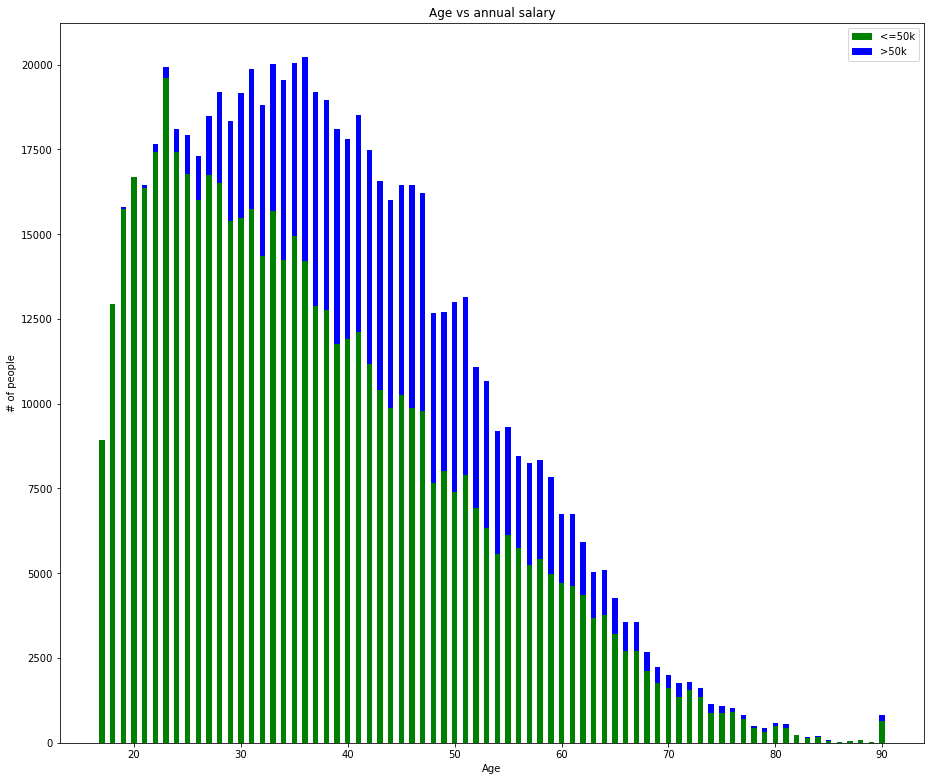

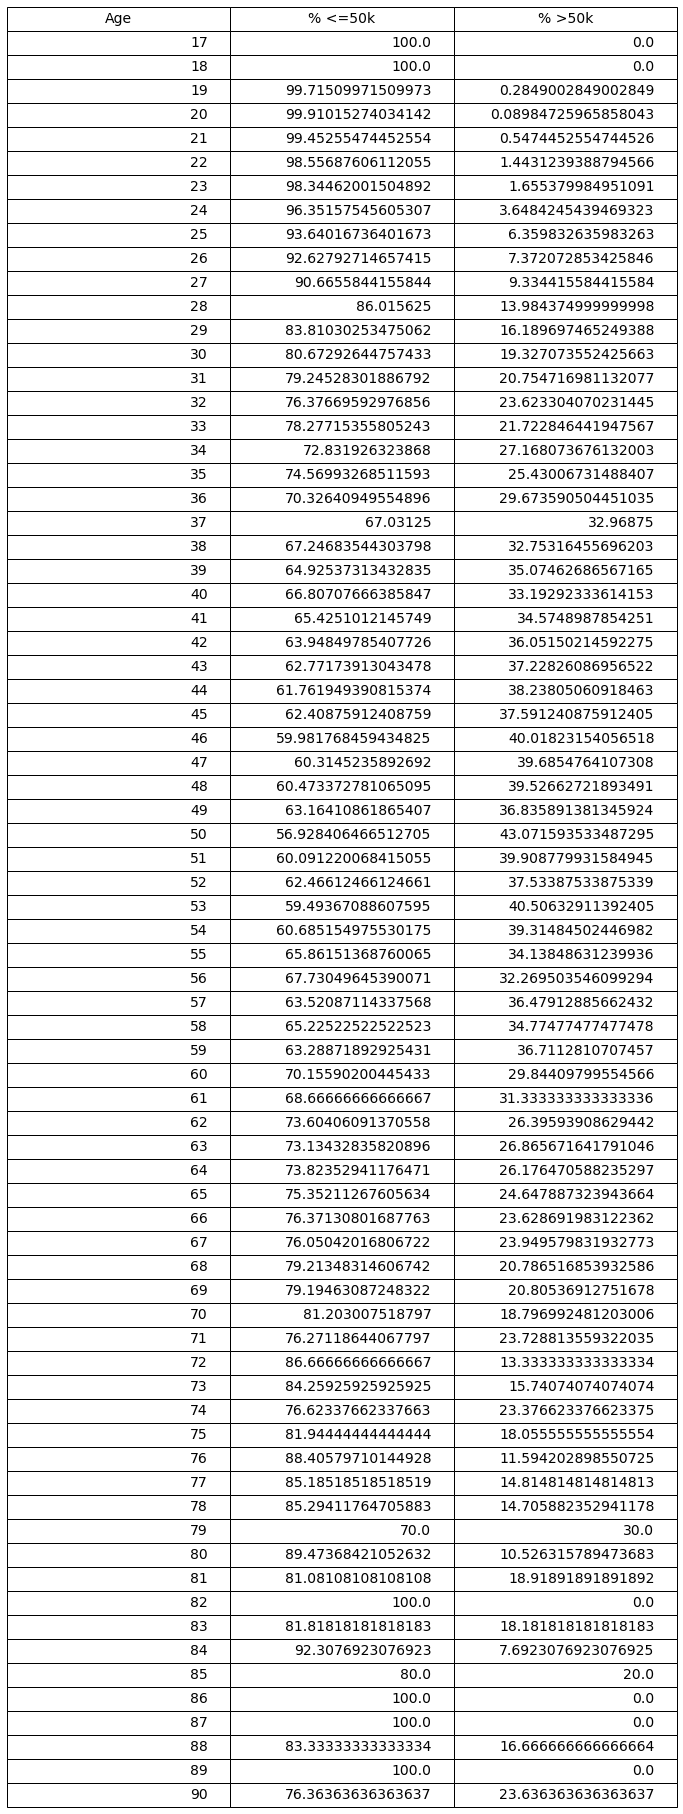

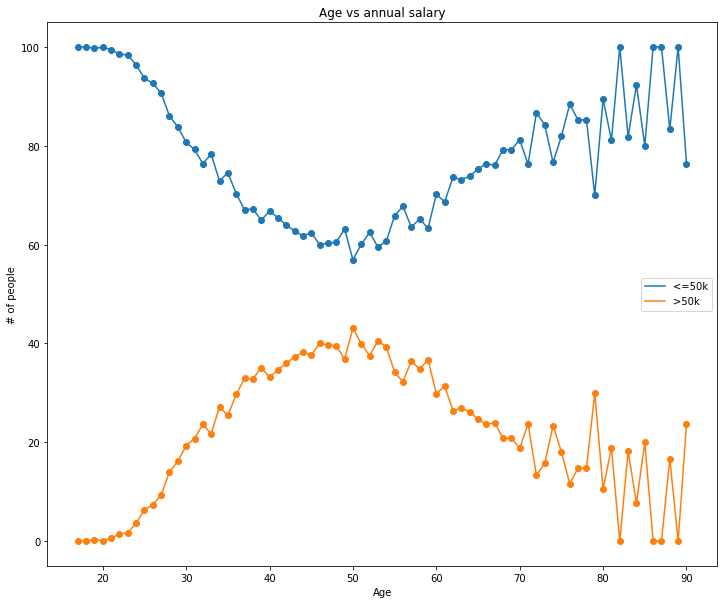

In [181]:
col = ds['age']
x = col.unique()
x.sort()

xlbl = col.name.capitalize()
y0, y1 = createBarChart(ds, classes, col, x, xlbl, ylbl)
x, y0_p, y1_p = createTable(xlbl, x, y0, y1)
showScatter(xlbl, x, y0_p, y1_p, xlbl, ylbl)

### Workclass
#### Bar Chart
The bar chart shows us that  almost all categories have noticable portions in the >50k class, all except unknown (?), without-pay, and never worked. Without pay had less than 20 people fitting this category, and it would make sense that most people without pay would make >50k annually.
#### Table
The table does confirm that most categories do well; however, there are some workclasses that do better than others. self-emp-inc are people who work for thesmelves in corporate entities. This workclass has an actual majority making >50k, with 55% fitting this.

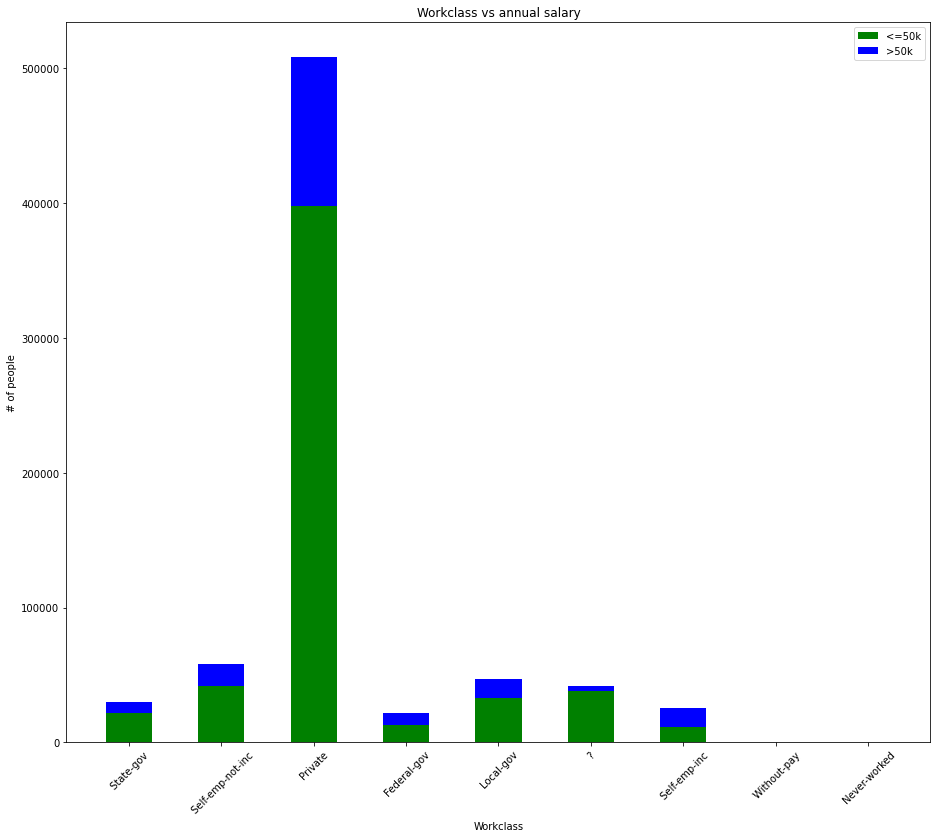

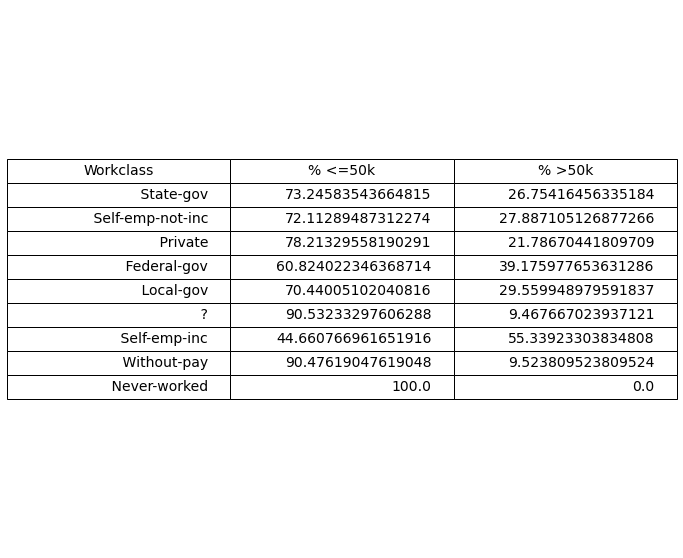

In [182]:
col = ds['workclass']
x = col.unique()
xlbl = col.name.capitalize()

y0, y1 = createBarChart(ds, classes, col, x, xlbl, ylbl, 45)
x, y0_p, y1_p = createTable(col.name.capitalize(), x, y0, y1)
#showScatter(xlbl, x, y0_p, y1_p, xlbl, ylbl)

### Fnlwgt
#### Bar Chart
Fnlwgt appears to have a similar quadratic trend to age, suggesting that fnlwgt is a noticable factor for determining class. The dropoff for # of people for each fnlwgt category drops off rather quickly, so this may be a reason why this quadratic curve exists - rather than correlation, this could be just causation.
#### Table
The table shows that, rather than a quadratic fit for percentages, there is actually a relatively linear fit with some noise. Most splits for this column have a 75-25 split for each class, which is similar to what the actual data is (roughly 75% are in the <=50k class, and roughly 25% are in the >50k class).

#### Scatterplot
The scatterplot visualizes this linear trend for us, showing a general updward curve in percent of people in the >50k class. However, in the first few splits, each value is relatively close to what it's neighbors are at, but as the splits increase, there is more deviation - the greater splits follow the 75-25 curve less, some with more and some with less in the >50k class.

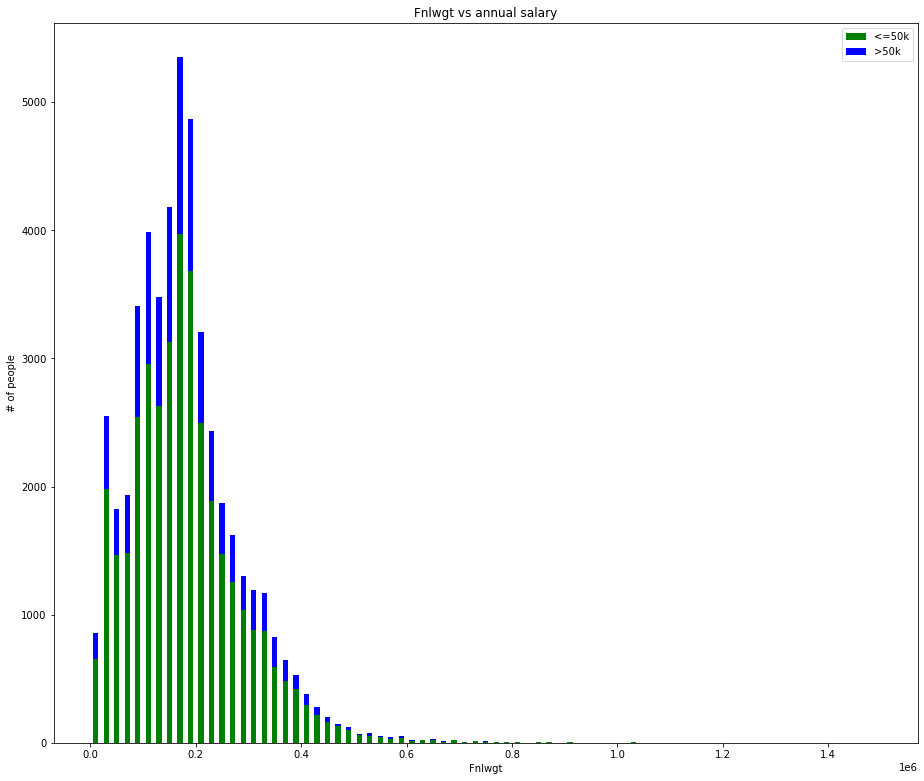

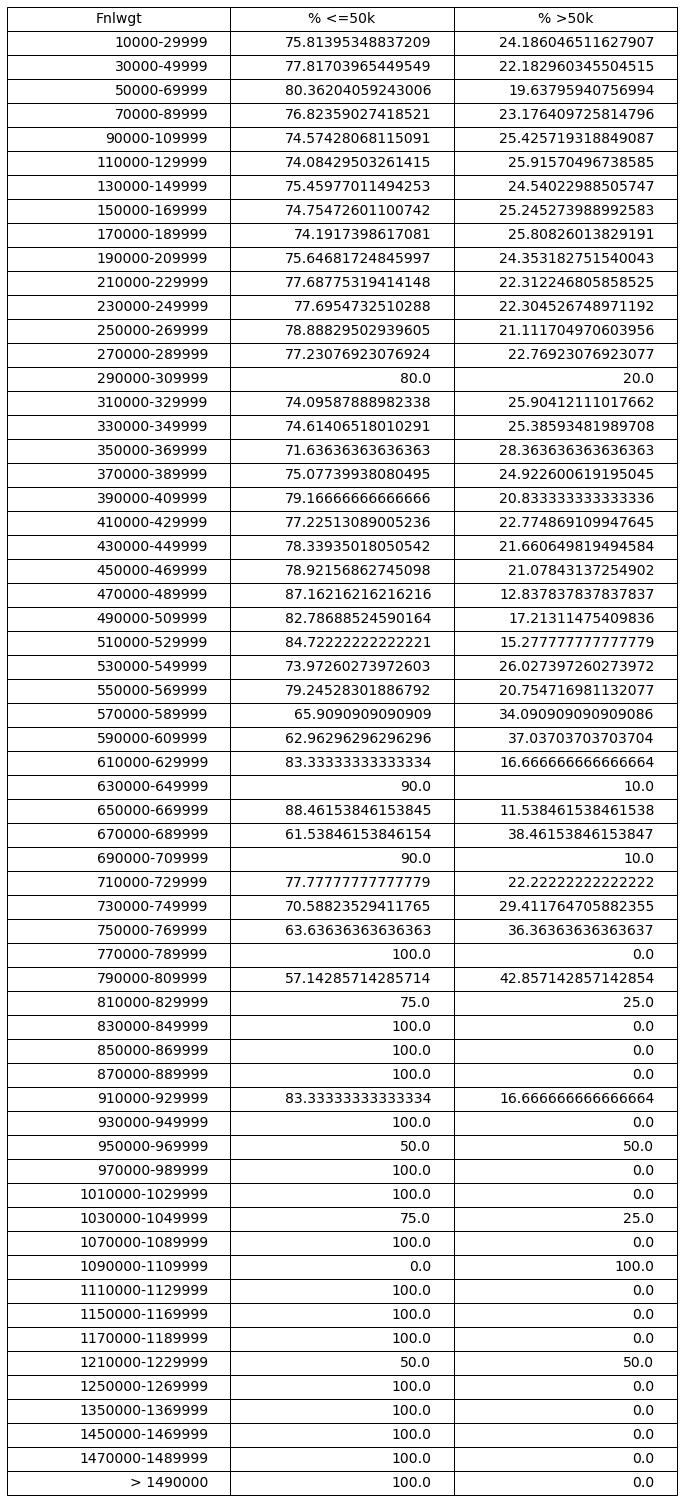

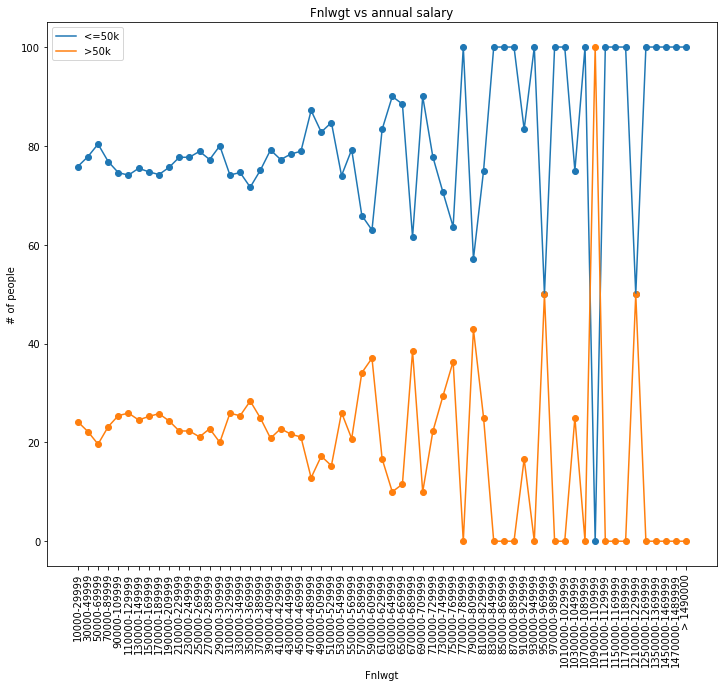

In [183]:
col = ds['fnlwgt']
start=10000
stop=1500000
step=20000
xlbl = col.name.capitalize()

y0, y1 = createBarChartContinuous(ds, classes, col, start, stop, step, xlbl, ylbl, 10000)

vals = list(range(start, stop, step))
x = []
for i in range(len(vals)-1):
    x.append("{}-{}".format(vals[i], vals[i+1]-1))

x, y0_p, y1_p = createTable(xlbl, x, y0, y1, max=1490000)
showScatter(xlbl, x, y0_p, y1_p, xlbl, ylbl, 90)

### Education
#### Bar Chart
The graph shows clear differences in proportions for each education category, with some having very few people in the >50k category, and some educations having a majority. It appears that the higher the education, the higher the percent making >50k annually.
#### Table
The percentages reinforce this theory that higher education correlates to greater salary - All levels below high-school grad have <10% making >50k. However, HS grad has nearly 16%, bachelors have a great increase at 41%, 3x as many as high school grad. Moving upward, Masters have 54%, and Doctorates have over 70% each. Furthermore, Assoc-acdm and Assoc-voc have ~25% each, and Prof school matches the doctorate at 70% making >50k.


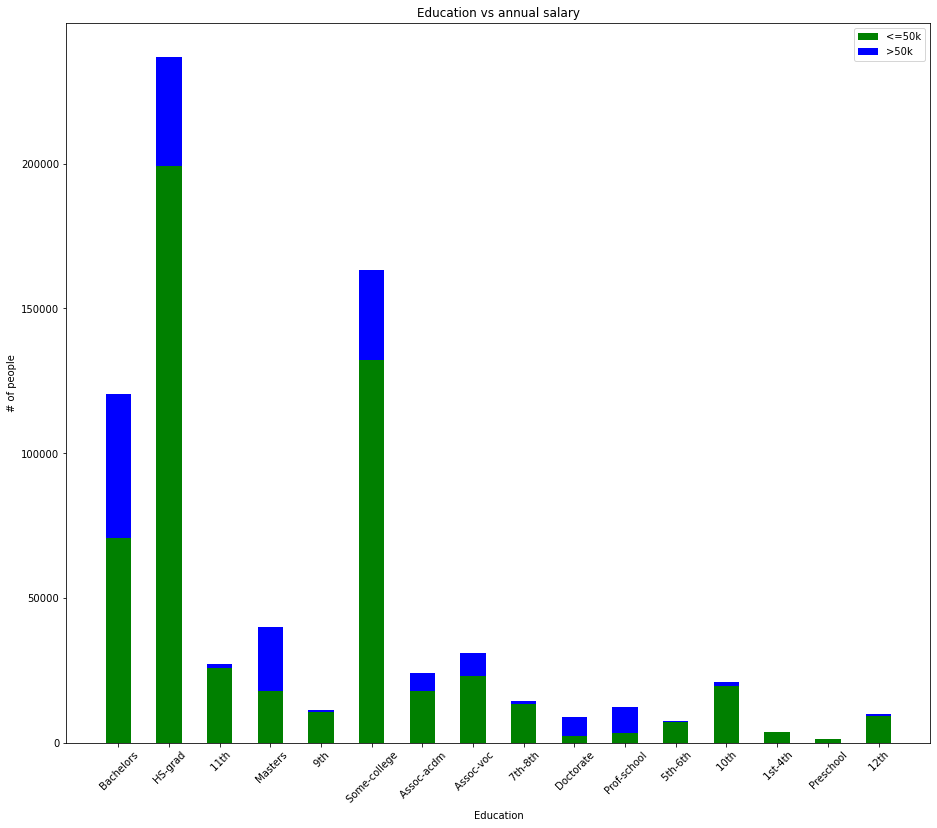

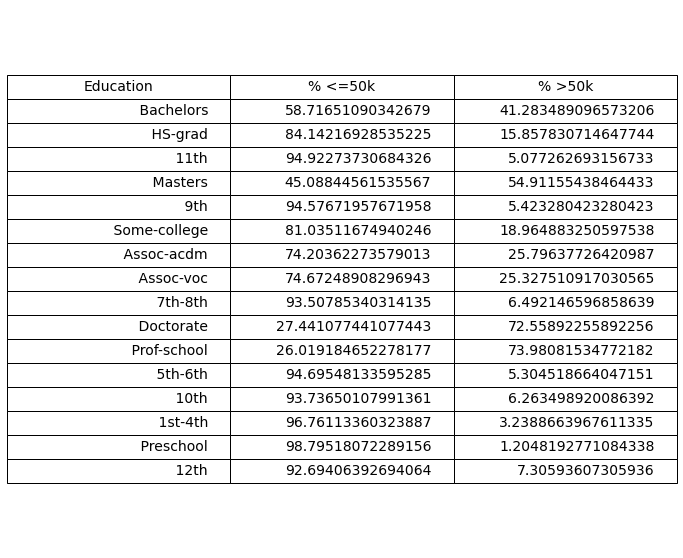

In [184]:
col = ds['education']
x = col.unique()
xlbl = col.name.capitalize()

y0, y1 = createBarChart(ds, classes, col, x, xlbl, ylbl, 45)
x, y0_p, y1_p = createTable(xlbl, x, y0, y1)
#showScatter(xlbl, x, y0_p, y1_p, xlbl, ylbl, 45)

### Marital-status
#### Bar Chart
Most categories for marital status are dominantly <=50k. There are only 2 categories that do exceptionally well - married-civ-spouse, and married-af-spouse. However, married-af-spouse has very few samples, so this may be innaccurate.
#### Table
The table for marital status shows that, indeed, married individuals do exceptionally better than those who aren't. Married civilian spouses have just under 45% making >50k annually, and armed-forces spouses are at ~37% in the same category.

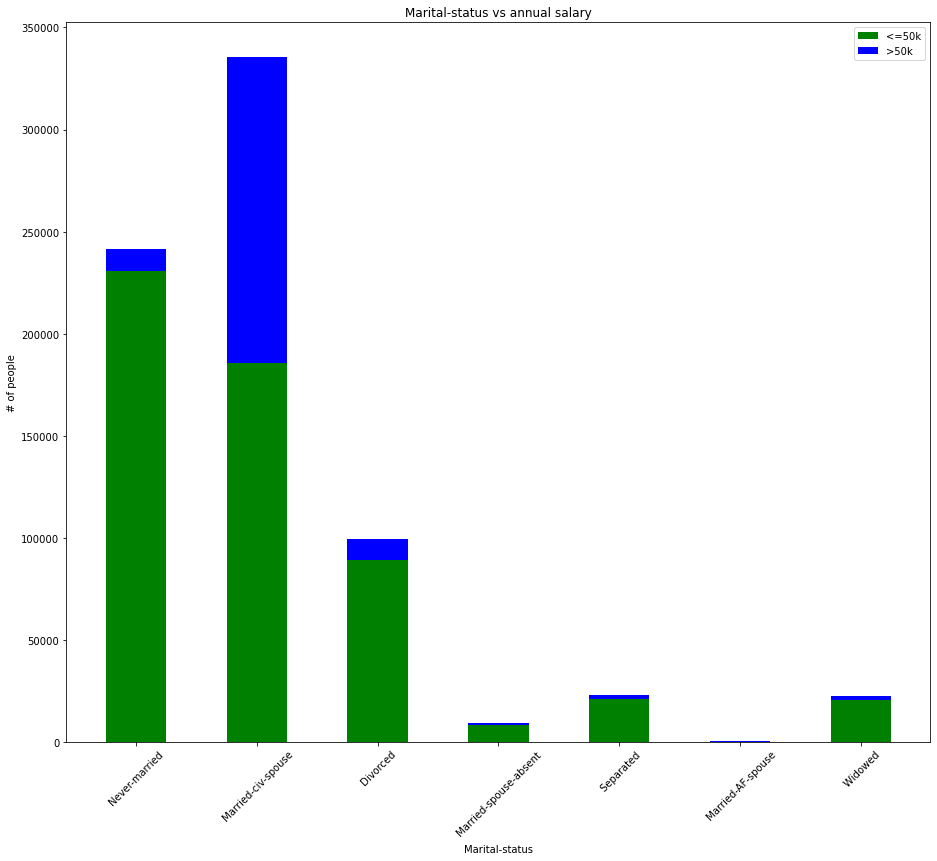

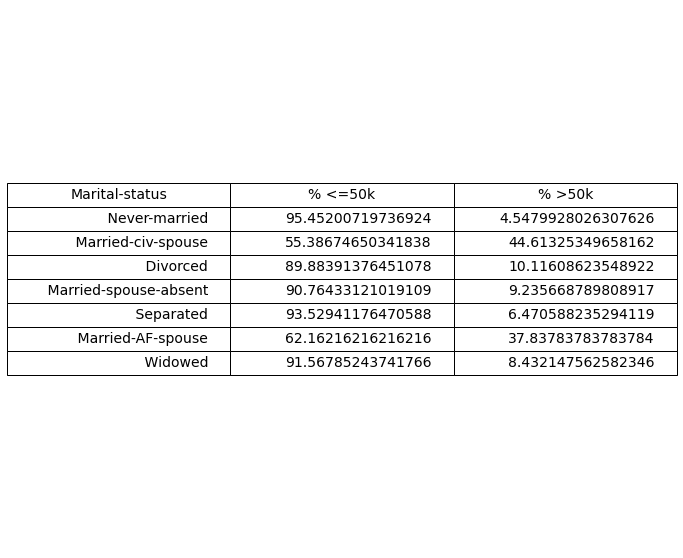

In [185]:
col = ds['marital-status']
x = col.unique()
xlbl = col.name.capitalize()

y0, y1 = createBarChart(ds, classes, col, x, xlbl, ylbl, 45)
x, y0_p, y1_p = createTable(xlbl, x, y0, y1)
#showScatter(xlbl, x, y0_p, y1_p, xlbl, ylbl,  45)

### Occupation
#### Bar Chart
Again, we see several categories that are mostly <=50k, but some that are a more even split. This would be expected of occupation, the source of income. Executive/managerial, professional/specialty, sales, and craft repair all seem to have noticable chunks in the >50k class.
#### Table
Exec-manageral performs the best with nearly 48% making >50k annually. Prof-speciality does nearly the same at 47%. Armed forces comes in 3rd at 33%, but again, this may be inaccurate as the small sample size. Protective-services follows up with 31%, which has a significantly large sample than armed forces.

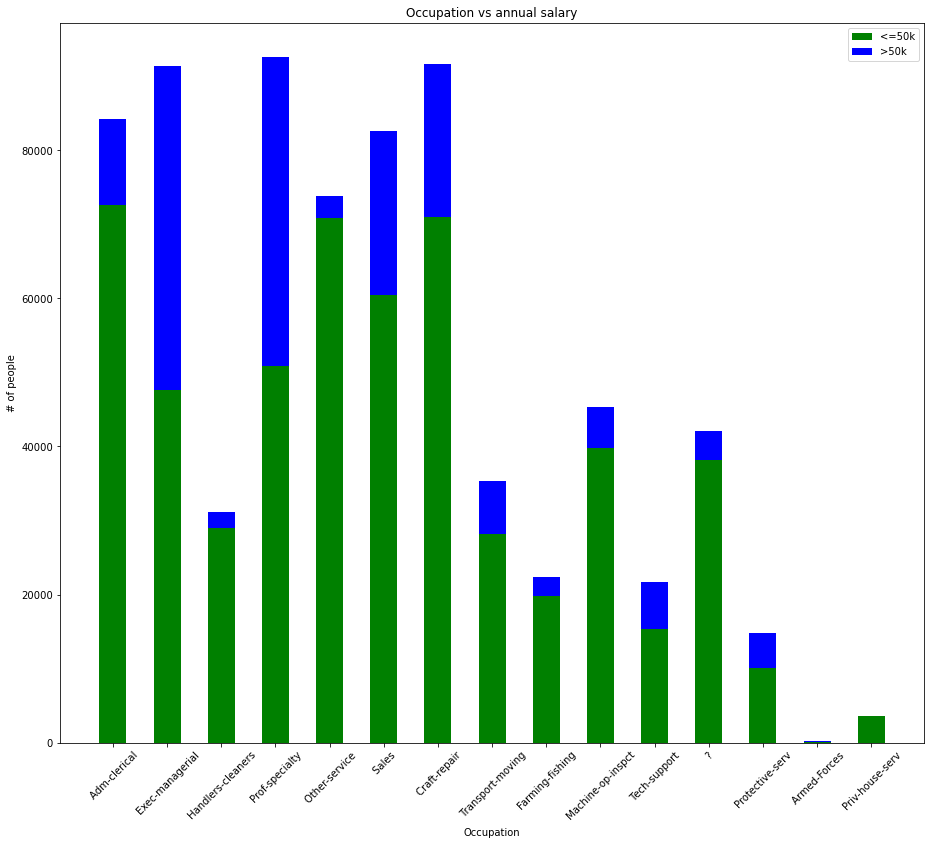

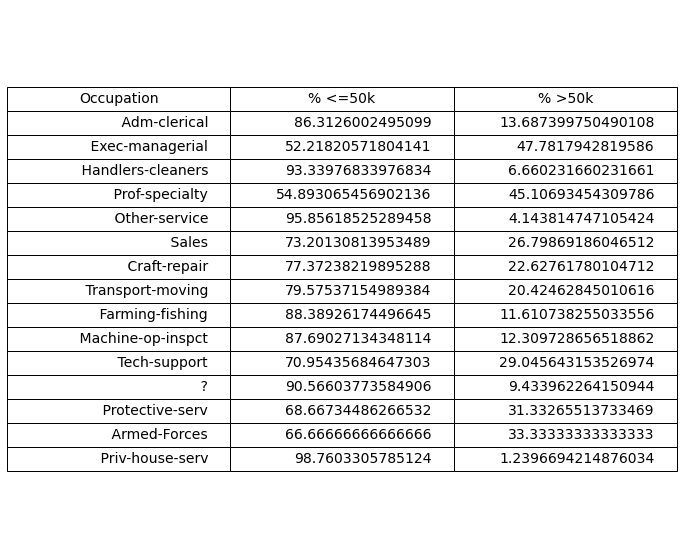

In [186]:
col = ds['occupation']
x = col.unique()
xlbl = col.name.capitalize()

y0, y1 = createBarChart(ds, classes, col, x, xlbl, ylbl, 45)
x, y0_p, y1_p = createTable(xlbl, x, y0, y1)
#showScatter(xlbl, x, y0_p, y1_p, xlbl, ylbl, 45)

### Relationship
#### Bar Chart
This chart is closely linked to the marital-status column - only the husband and wife categories have majorities making >50k annually. The rest have significantly fewer.
#### Table
Husband and wife, as shown, display the best results - however, wife actually has 46%, whereas husband has 44%. This is different than what the "sex" column will show later on, with women having a significantly smaller percentage making >50k.

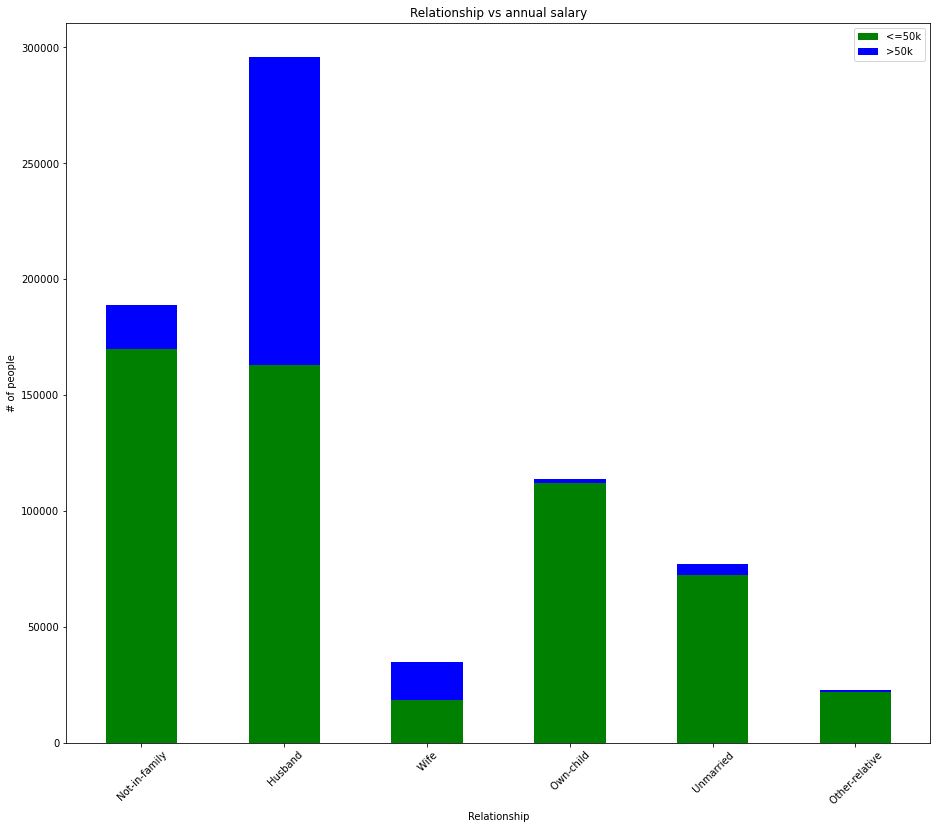

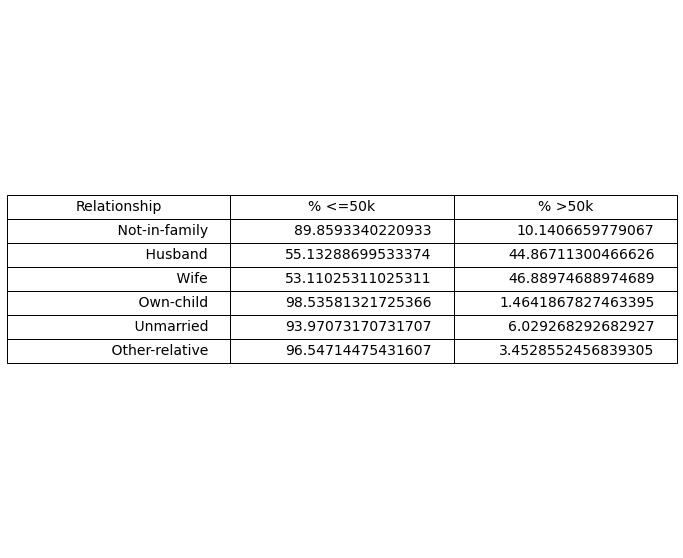

In [187]:
col = ds['relationship']
x = col.unique()
xlbl = col.name.capitalize()

y0, y1 = createBarChart(ds, classes, col, x, xlbl, ylbl, 45)
x, y0_p, y1_p = createTable(xlbl, x, y0, y1)
#showScatter(xlbl, x, y0_p, y1_p, xlbl, ylbl, 45)

### Race
#### Bar Chart
Here we can actually see a negative correlation - only white and pacific highlander seem to have a percentage of standard size making >50k. The rest have smaller percentages, showing that race could lead to a smaller salary. 
#### Table
As discussed, only white and pacific highlander have reasonable percentages. In fact, they follow the trend of the data presented, with 75% making <=50k, and 25% making >50k. The other races have smaller than 25% making >50k, in fact by half as much - black, amer-indian-eskimo, and other all have 11-12% in the >50k class.

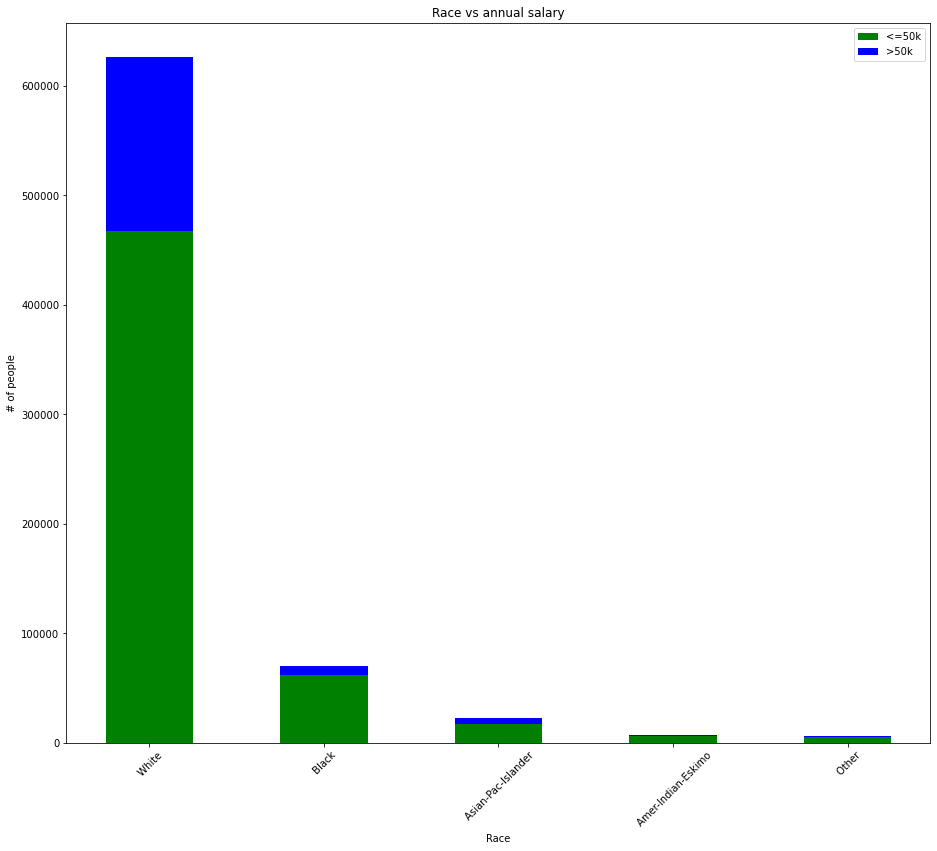

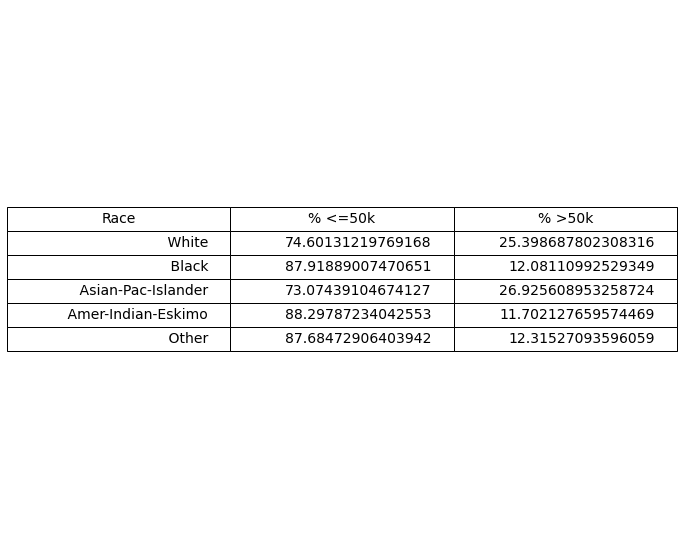

In [188]:
col = ds['race']
x = col.unique()
xlbl = col.name.capitalize()

y0, y1 = createBarChart(ds, classes, col, x, xlbl, ylbl, 45)
x, y0_p, y1_p = createTable(xlbl, x, y0, y1)
#showScatter(xlbl, x, y0_p, y1_p, xlbl, ylbl, 45)

### Sex
#### Bar Chart
From the earlier relationship column, we see husbands and wives with nearly the same percentage making >50k. Here, however, we see that men have a significantly higher percentage in this category.
#### Table
Again, men do, in fact, have a greater percentage making >50k - 20% more than women. In fact, men even have a greater percentage than the ~75-25 trend the data follows, while women have significantly less.

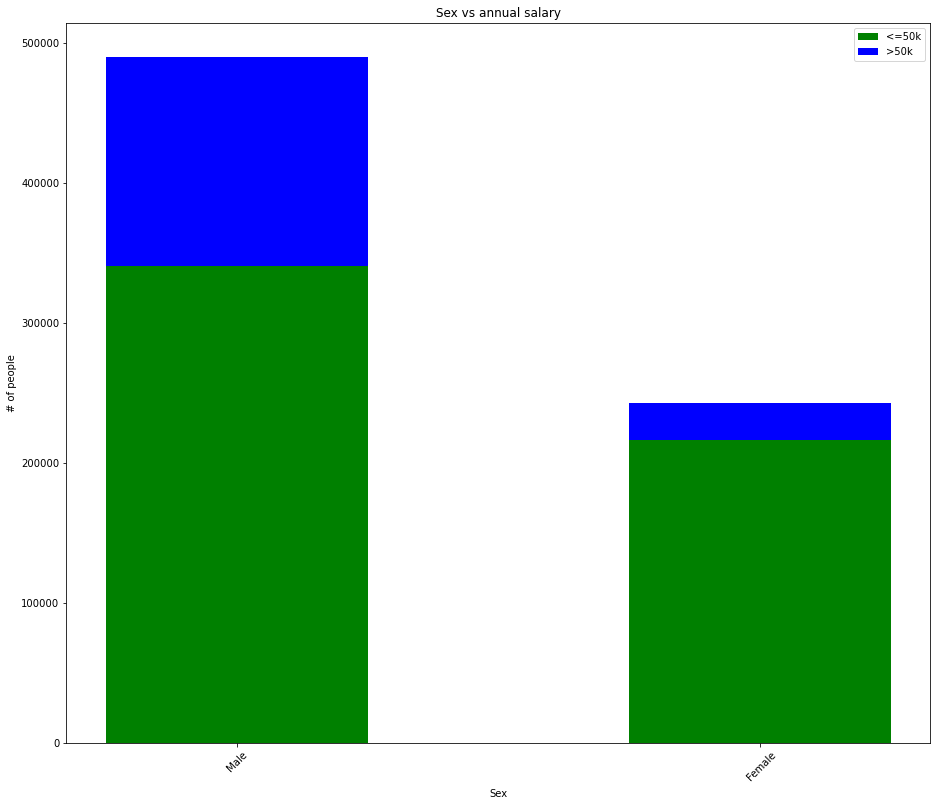

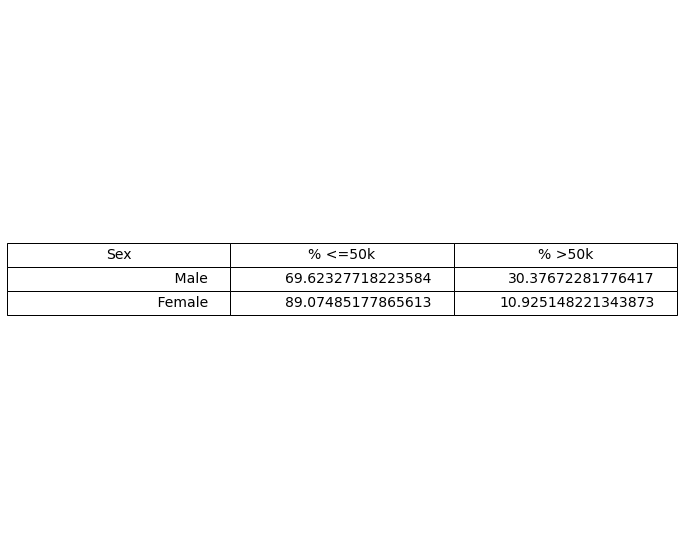

In [189]:
col = ds['sex']
x = col.unique()
xlbl = col.name.capitalize()

y0, y1 = createBarChart(ds, classes, col, x, xlbl, ylbl, 45)
x, y0_p, y1_p = createTable(xlbl, x, y0, y1)

### Capital-gain
#### Bar Chart
Almost everyone in this study had <20,000 for capital gain. From everyone between 0 and 20,000, almost everyone there had 0 capital gain. However, there were a few people making nearly 100,000 in capital gain, and everyone in this category is in the >50k class.
#### Table
Looking at each split under 11,000, there are some splits that extremely favor those who make >50k. Given more data, we could assume a certain salary looking at these splits. Furthermore, looking at the few who have a capital-gain of nearly 100,000 and how it is 100% people in the >50k class, we could make connections with their salaries given more information there as well.
#### Scatterplot
The scatterplot paints the story told in the table - for captain gain under 5000, this is mostly people making <=50k. From 5,000-6,000, this is a fairly even split, then 6,000-7,000, this again favors <=50k salaries. However, capital gain from 7,000 to 20,000 is almost always 100% salaries >50k. There are some splits after 20,000 that switch back and forth, but the highest capital gain is, again, >50k.

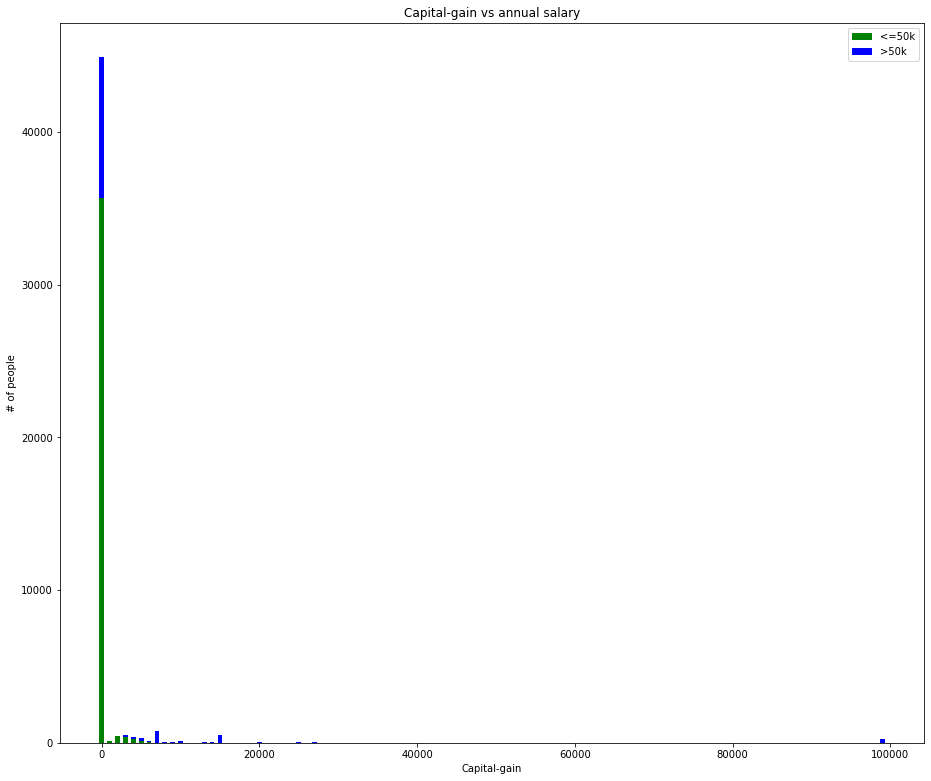

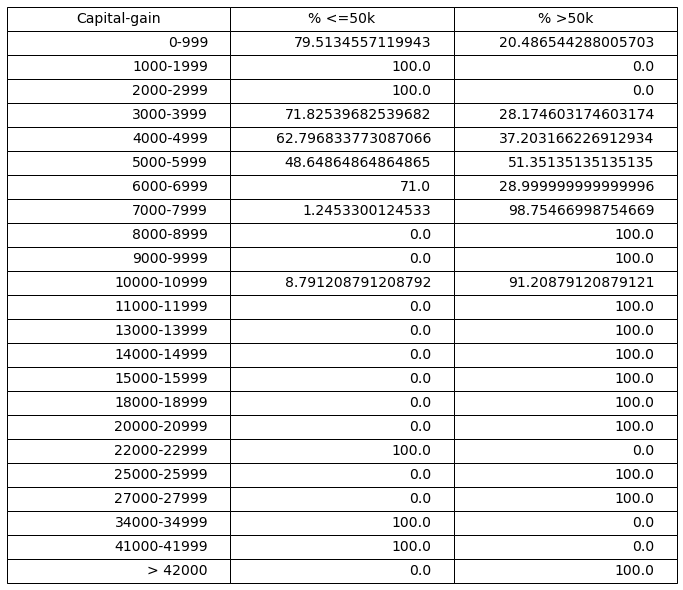

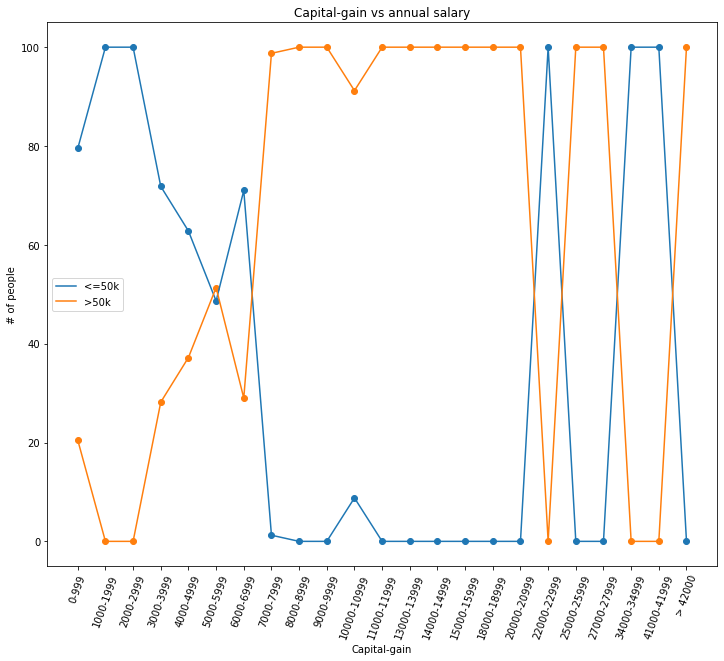

In [190]:
col = ds['capital-gain']
xlbl = col.name.capitalize()

start=0
stop=100000
step=1000

y0, y1 = createBarChartContinuous(ds, classes, col, start, stop, step, xlbl, ylbl, width=600)

vals = list(range(start, stop, step))
x = []
for i in range(len(vals)-1):
    x.append("{}-{}".format(vals[i], vals[i+1]-1))
x, y0_p, y1_p = createTable(xlbl, x, y0, y1, 42000)
showScatter(xlbl, x, y0_p, y1_p, xlbl, ylbl, 70)


### Capital-loss
#### Bar Chart
The bar chart shows, similar to capital gain, most people had 0 capital loss. After 0, there are some samples spread out, but the numbers at 0 capital loss follow the 75-25 trend of the data.
#### Table
The data doesn't show us any obvious trends or correlations, but it does suggest that certain splits favor a group more than other splits. While correlation may not be obvious, it does show it is related in some way.
#### Scatterplot
The scatterplot reinforces the table, not necessarily showing any obvious correlations - the percentages seem to flip-flop in favoritism toward each class.

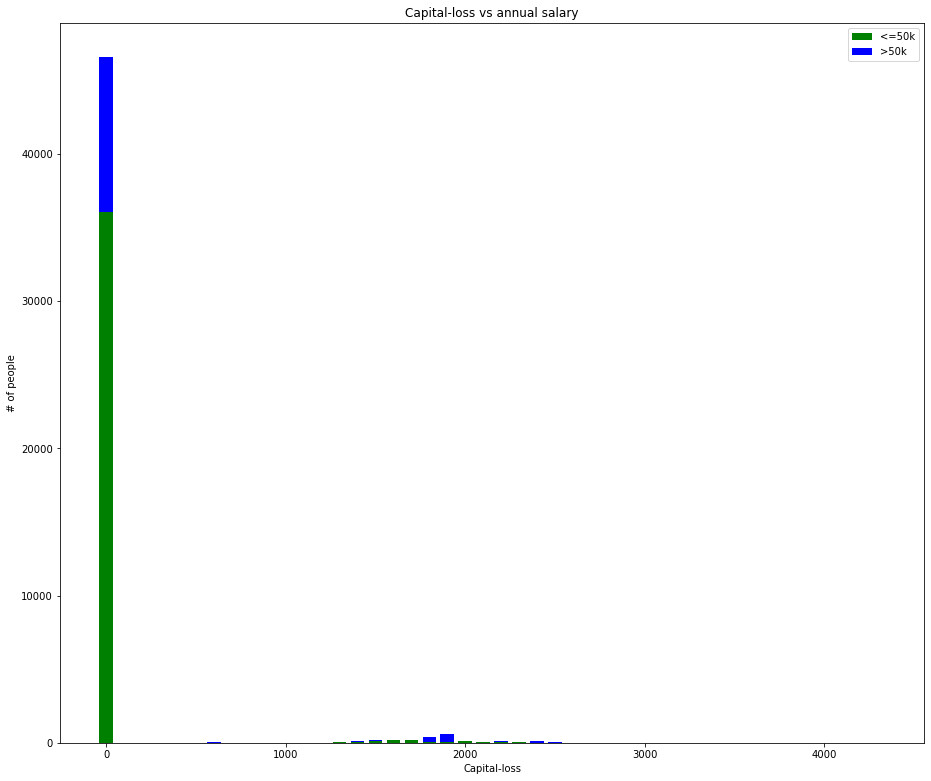

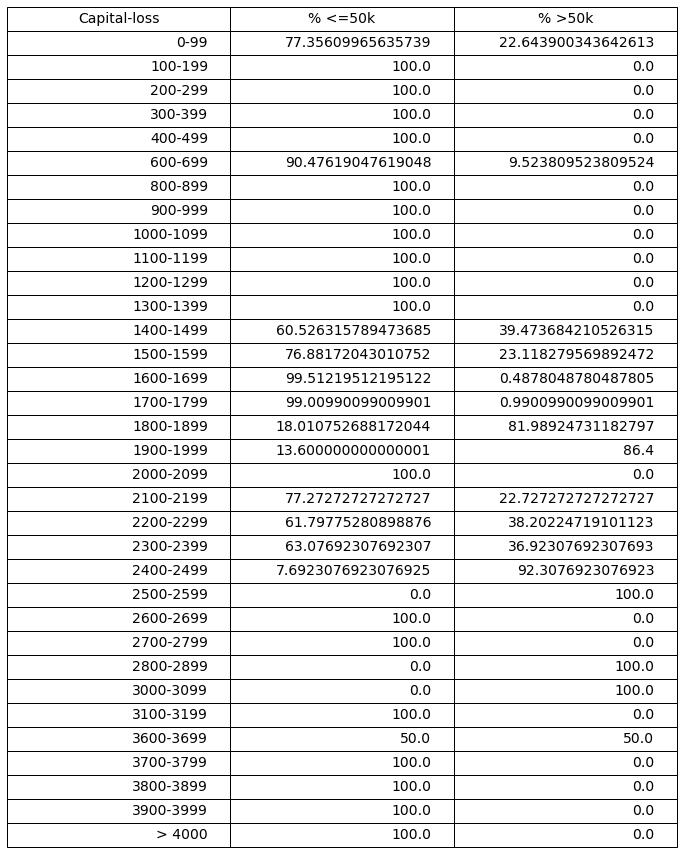

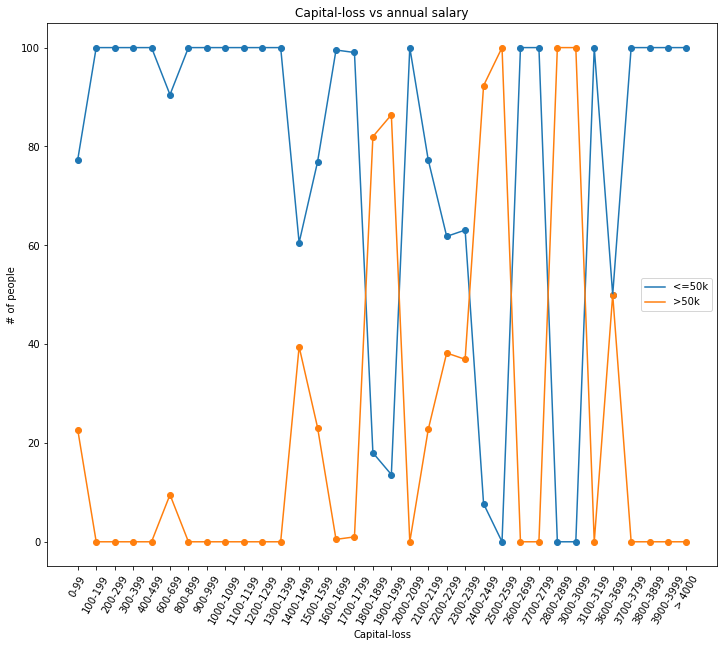

In [191]:
col = ds['capital-loss']
xlbl = col.name.capitalize()

start=0
stop=4400
step=100

y0, y1 = createBarChartContinuous(ds, classes, col, start, stop, step, xlbl, ylbl, width=75)

vals = list(range(start, stop, step))
x = []
for i in range(len(vals)-1):
    x.append("{}-{}".format(vals[i], vals[i+1]-1))
x, y0_p, y1_p = createTable(xlbl, x, y0, y1, 4000)
showScatter(xlbl, x, y0_p, y1_p, xlbl, ylbl, 60)

### Hours-per-week
#### Bar Chart
The graph here shows that most people work an average of 40 hours per week. There are some larger samples at multiples of 5, such as 20, 30, 35, 45, 50, and 60. There is an interesting trend - under 35 hours per week, a very small portion of each group is in the >50k class. This is likely due to working few hours per week, likely as part-time.
#### Table
The table here shows a steady increase in percent of each group making >50k, with 41 hours/week holding 25% in the >50k class. From there, the trend continues steadily upward to greater percentages making >50k, although the more hours worked per week, the more variance and noise there is - higher hours doesn't guarantee making >50k.
#### Scatterplot
Here we can see that general trend upward for increase in percentage of people making >50k, and we can also see that variance. Percent of people per split making >50k increases quickly from 15 to ~45, then from there it appears to not be as correlated, with the scatterplot showing less of a trend.

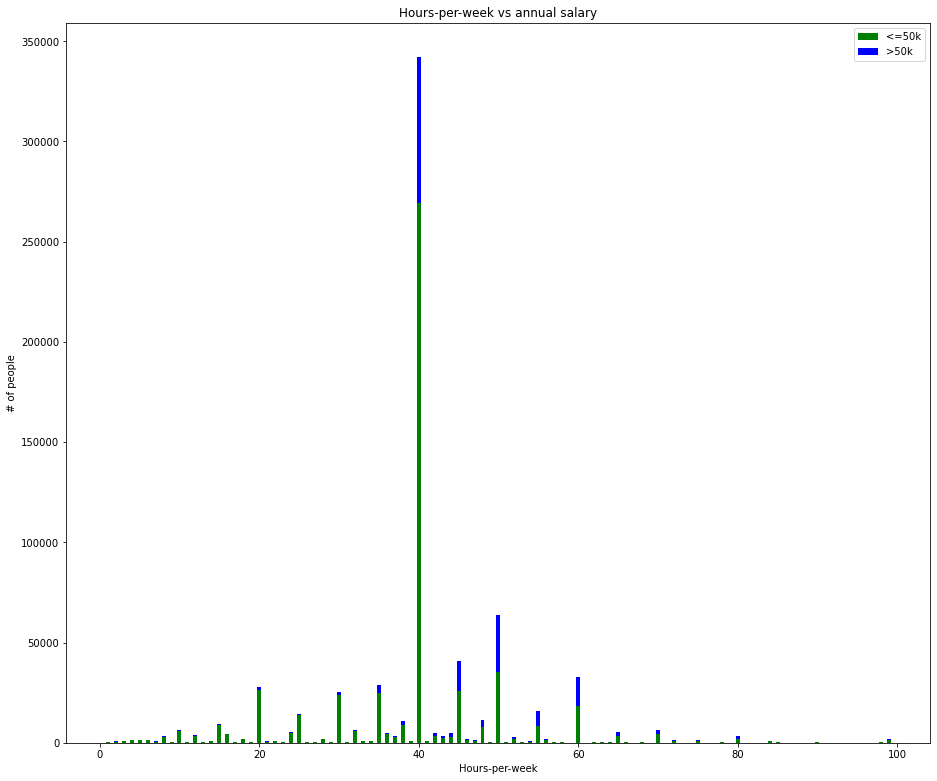

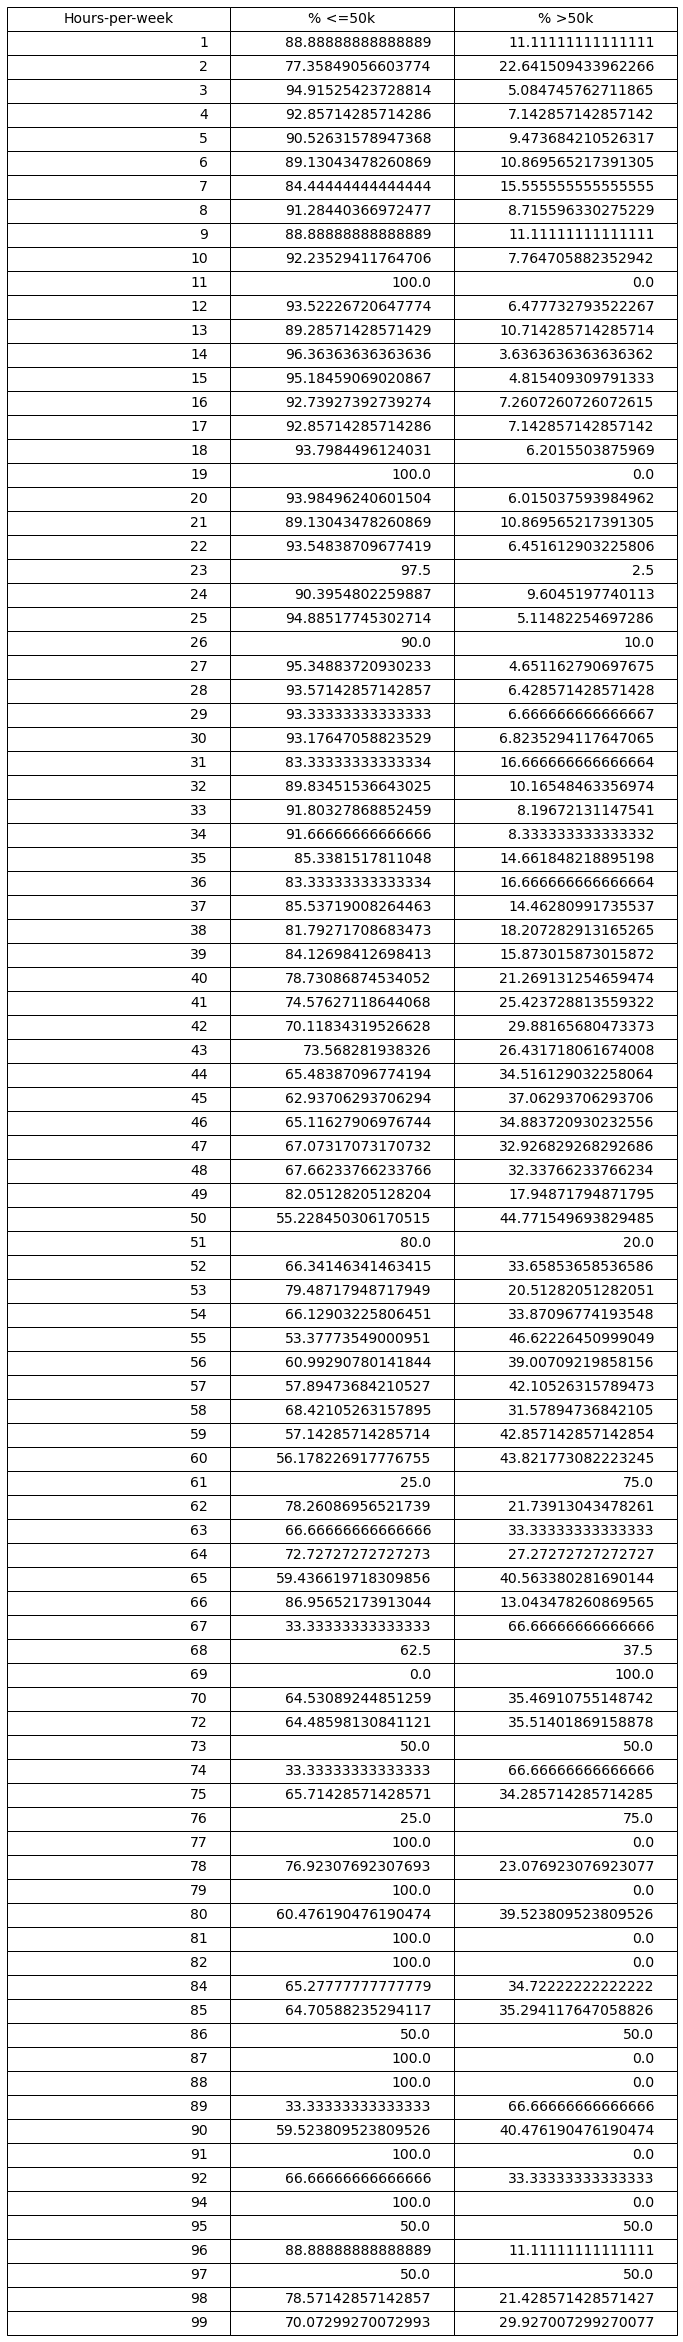

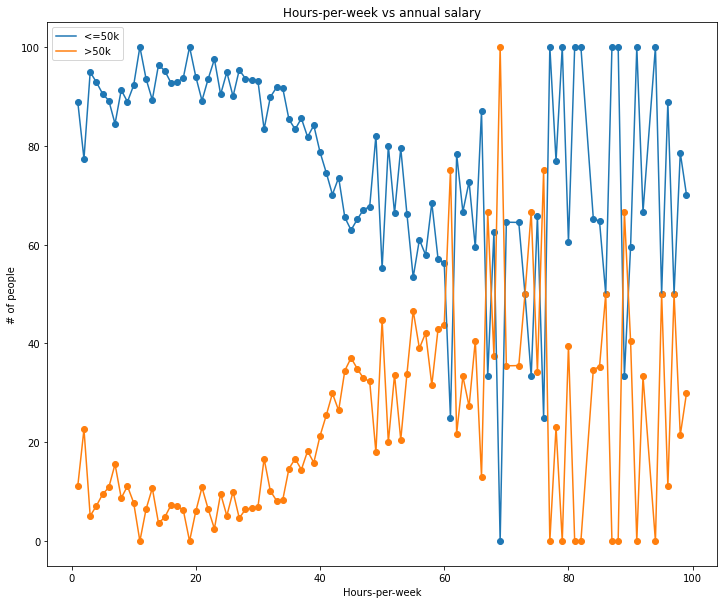

In [192]:
col = ds['hours-per-week']
x = col.unique()
x.sort()
xlbl = col.name.capitalize()

y0, y1 = createBarChart(ds, classes, col, x, xlbl, ylbl)
x, y0_p, y1_p = createTable(xlbl, x, y0, y1)
showScatter(xlbl, x, y0_p, y1_p, xlbl, ylbl)

### Native country
#### Bar Chart
For the united states, there appears to be no correlation. However, for some native countries such as Mexico and India, the percentage of each class is askew, with Mexico having significantly less than what the data shows overall, and India having a higher percentage. There are significantly fewer samples for these native countries, so this could be a biased sample.
#### Table
The table shows many countries having a variance for percentages from what the data holds. Most countries other than the United States have very few samples overall. Because of this, these results could be misleading.

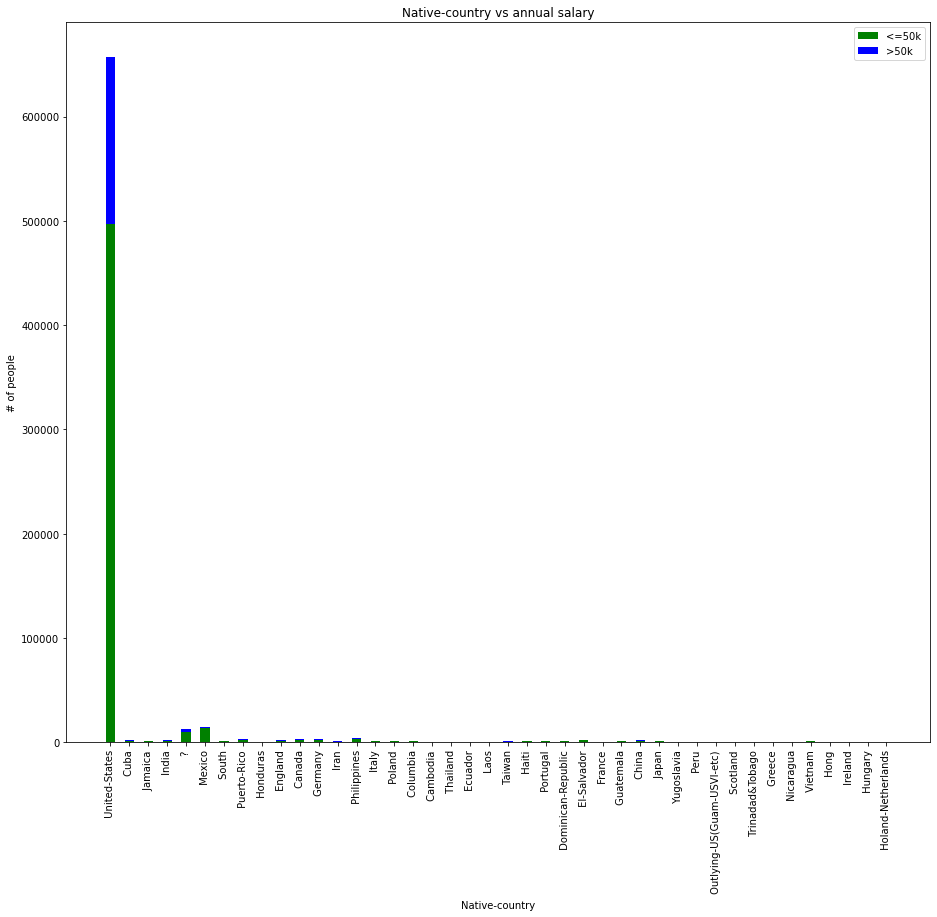

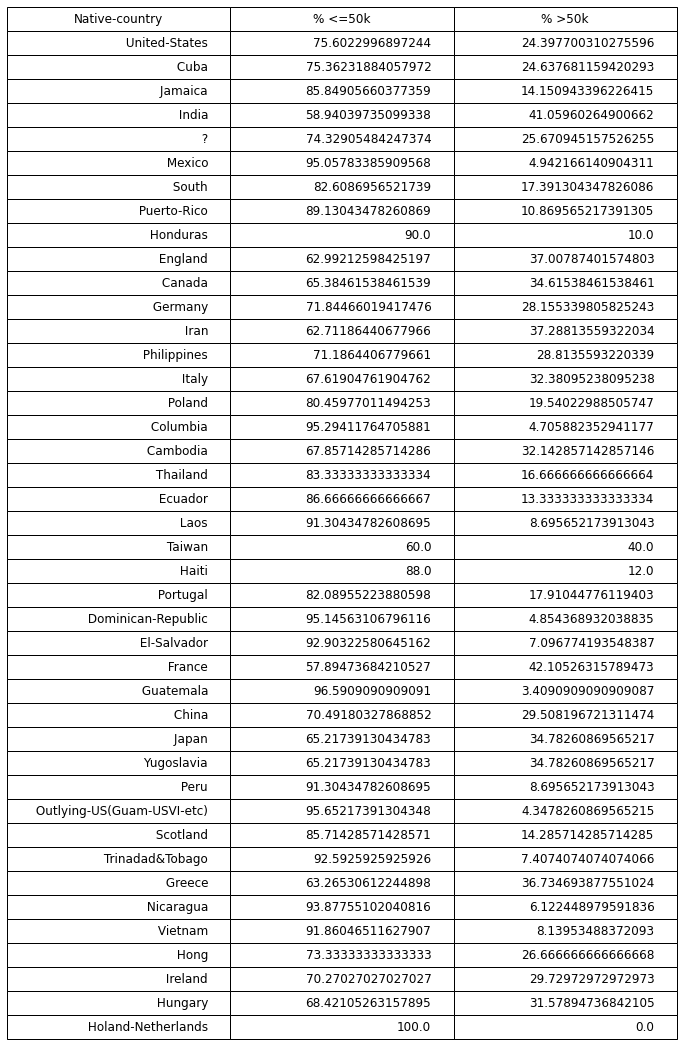

In [193]:
col = ds['native-country']
x = col.unique()
xlbl = col.name.capitalize()

y0, y1 = createBarChart(ds, classes, col, x, xlbl, ylbl, 90)
x, y0_p, y1_p = createTable(xlbl, x, y0, y1)
#showScatter(xlbl, x, y0_p, y1_p, xlbl, ylbl, 90)

## Chi-square-test
Now that we've seen the visualizations of each feature, let's look at how strongly the categorical data is linked to classification using a chi square test.

In [194]:
#Gets the counts of each item for a given column
def get_object_data(ds):
    #Get # of rows in dataset
    total = len(ds)
    feature_probs = {}
    
    for col in ds:
        
        #Don't want to count target col
        if col == 'class':
            continue

        #If column is object, count each item and divide by # of rows
        elif ds[col].dtype == np.dtype('object'):
            feature_probs[col] = ds[col].value_counts().to_dict()

    return feature_probs

In [195]:
from scipy.stats import chi2_contingency 
train_csv, test_csv = load_datasets()
ds = pd.concat([train_csv, test_csv], axis=0)

#Load counts of each subitem for each column in each class
feature_class_counts = {}
classes = train_csv['class'].unique()
for k in classes:
    #Just get the rows belonging to the specific class
    current_class = ds.loc[ds['class'] == k]
    feature_class_counts[k] = get_object_data(current_class)

#Loop through obj columns for each class, get the chi2 and p values
obj_cols = list(feature_class_counts[' <=50K'].keys())
for col in obj_cols:
    keys = list(feature_class_counts[' <=50K'][col].keys()) 
    
    table = defaultdict(list)
    for k in keys:
        for cls in classes:
            try:
                table[k].append(feature_class_counts[cls][col][k])
            except KeyError:
                table[k].append(0)

    obs = np.array(list(table.values()))
    chi2, p, _, _ = chi2_contingency(obs)
    print("{}:\tchi2: {},\tp: {}".format(col, round(chi2, 2), round(p, 2)))
    


workclass:	chi2: 1610.75,	p: 0.0
education:	chi2: 6537.97,	p: 0.0
marital-status:	chi2: 9816.02,	p: 0.0
occupation:	chi2: 5983.16,	p: 0.0
relationship:	chi2: 10088.72,	p: 0.0
race:	chi2: 487.03,	p: 0.0
sex:	chi2: 2248.85,	p: 0.0
native-country:	chi2: 452.23,	p: 0.0


Every categorical variable not only had  p-values below an alpha of 0.01, they were all 0! Meaning every variable is important, although some had pretty large chi2 scores, and some had extremely large chi2 squares. Let's try classifying, then take a look at the analysis.

## ==========================================================

## Data-preprocessing
It's rarely the case where a dataset is ready to be analyzed - normally, there is some data preprocessing that needs to happen. This can include converting columns (as shown already), or pruning (removing columns). There are many steps that can be helpful to take, but here, pruning should show us great results. Given more time, further preprocessing could occur with a deeper analysis of the above visuals, but for now, pruning alone will help.

### Pruning
From what was discussed in the visualization section, some columns are dependent on others or simply have no correlation. While it's not so easy as to say how "important" each column is, there are some we can remove with confidence:

* Education - There is already an "education-num" column
* Relationship - Marital status covers this
* Fnlwgt - This came after I googled what exactly fnlwgt was. From the description online, and from what was visualized above with minimal correlation, I decided to remove it to see if results improved (they did).

In [227]:
def prune(ds):
    cols = ['fnlwgt', 'education', 'relationship']
    for col in cols:
        ds.pop(col)
    
    return ds

## ==========================================================

## Classification
For this assessment, I decided to use 3 different approaches for classification:

* Neural Network
* Naive Bayes
* SVM

Before each approach, I will discuss why I chose that approach, the pros and cons to that algorithm, improvements that could be made, and I will discuss results and visualizations after each algorithm.


In [310]:
def create_confusion_matrix(preds, target):
    plt.figure(figsize=(8, 6))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    cm = confusion_matrix(test_y, preds)
    hm = sns.heatmap(cm, annot=True, xticklabels=['True 0', 'True 1'], yticklabels=['Pred 0', 'Pred 1'])
    hm.xaxis.tick_top() # x axis on top
    hm.xaxis.set_label_position('top')
    return hm

### Neural-network
#### Why I chose this algorithm
Neural networks are increasingly popular in the world of data science and machine learning. They are excellent at recognizing patterns, and can work with vague or even incomplete data. For this dataset, with a high amount of variance with each feature, I believe a neural network would be great at identifying relationships
#### Pros
* Great pattern recognition capabilities
* Hyperparameters can be customized to allow for flexibility
* Datasets can be less complete than what is needed for other algorithms

#### Cons
* Computationally intensive
* "Black box" method - not always clear what is going on in the neural network
* Due to hyperparameters offering so much customization, hard to know exactly what is best with limited time

#### Improvements that could be made to my implementation
* Again, hyperparameters - performing hyperparameter optimization would be ideal, but with limited time, this solution works well enough.
* Defining what type of neural network is best for this type of classification. There are many different types of networks, so spending time to find which is best could show improvements.

In [315]:
#Load and format data
train_csv, test_csv = load_datasets()

#Prune
train_csv = prune(train_csv)
test_csv = prune(test_csv)

#Convert object columns to discrete numerical values
train_csv = convert_to_discrete(train_csv)
test_csv = convert_to_discrete(test_csv)

In [316]:
#Pop the class columns off each dataset to save as targets for each
train_y = train_csv.pop('class')
train_dataset = tf.data.Dataset.from_tensor_slices((train_csv.values, train_y.values))
train_dataset = train_dataset.shuffle(len(train_csv)).batch(32)

test_y = test_csv.pop('class')
test_dataset = tf.data.Dataset.from_tensor_slices((test_csv.values, test_y.values))
test_dataset = test_dataset.shuffle(len(test_csv)).batch(len(test_csv))

In [317]:
#Create model, add 2 hidden layers with relu activation, and compile with adam optimizer
model = tf.keras.Sequential([
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [318]:
#Fit model with train dataset using 500 epochs
start = time.time()
model.fit(train_dataset, epochs=500, verbose=1)
end = time.time()

hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("Runtime of NN: {:0>2}:{:0>2}:{:05.2f} (HH:MM:SS.MS)".format(int(hours),int(minutes),seconds))

Epoch 1/500
1018/1018 [==============================] - 1s 785us/step - loss: 4.7655 - accuracy: 0.7805
Epoch 2/500
1018/1018 [==============================] - 1s 814us/step - loss: 1.4968 - accuracy: 0.8037
Epoch 3/500
1018/1018 [==============================] - 1s 807us/step - loss: 0.9467 - accuracy: 0.8118
Epoch 4/500
1018/1018 [==============================] - 1s 778us/step - loss: 0.7200 - accuracy: 0.8155
Epoch 5/500
1018/1018 [==============================] - 1s 791us/step - loss: 0.8602 - accuracy: 0.8183
Epoch 6/500
1018/1018 [==============================] - 1s 791us/step - loss: 0.5638 - accuracy: 0.8203
Epoch 7/500
1018/1018 [==============================] - 1s 791us/step - loss: 0.4141 - accuracy: 0.8250
Epoch 8/500
1018/1018 [==============================] - 1s 802us/step - loss: 0.3794 - accuracy: 0.8264
Epoch 9/500
1018/1018 [==============================] - 1s 788us/step - loss: 0.3553 - accuracy: 0.8270
Epoch 10/500
1018/1018 [==============================]

1018/1018 [==============================] - 1s 833us/step - loss: 0.3050 - accuracy: 0.8491
Epoch 155/500
1018/1018 [==============================] - 1s 834us/step - loss: 0.3042 - accuracy: 0.8500
Epoch 156/500
1018/1018 [==============================] - 1s 862us/step - loss: 0.3032 - accuracy: 0.8506
Epoch 157/500
1018/1018 [==============================] - 1s 826us/step - loss: 0.3061 - accuracy: 0.8495
Epoch 158/500
1018/1018 [==============================] - 1s 832us/step - loss: 0.3039 - accuracy: 0.8499
Epoch 159/500
1018/1018 [==============================] - 1s 854us/step - loss: 0.3039 - accuracy: 0.8507
Epoch 160/500
1018/1018 [==============================] - 1s 831us/step - loss: 0.3031 - accuracy: 0.8502
Epoch 161/500
1018/1018 [==============================] - 1s 835us/step - loss: 0.3026 - accuracy: 0.8503
Epoch 162/500
1018/1018 [==============================] - 1s 847us/step - loss: 0.3027 - accuracy: 0.8520
Epoch 163/500
1018/1018 [==========================

1018/1018 [==============================] - 1s 827us/step - loss: 0.2918 - accuracy: 0.8563
Epoch 307/500
1018/1018 [==============================] - 1s 833us/step - loss: 0.2915 - accuracy: 0.8567
Epoch 308/500
1018/1018 [==============================] - 1s 845us/step - loss: 0.2899 - accuracy: 0.8568
Epoch 309/500
1018/1018 [==============================] - 1s 834us/step - loss: 0.2906 - accuracy: 0.8563
Epoch 310/500
1018/1018 [==============================] - 1s 852us/step - loss: 0.2893 - accuracy: 0.8575
Epoch 311/500
1018/1018 [==============================] - 1s 855us/step - loss: 0.2906 - accuracy: 0.8572
Epoch 312/500
1018/1018 [==============================] - 1s 833us/step - loss: 0.2909 - accuracy: 0.8582
Epoch 313/500
1018/1018 [==============================] - 1s 838us/step - loss: 0.2898 - accuracy: 0.8569
Epoch 314/500
1018/1018 [==============================] - 1s 832us/step - loss: 0.2888 - accuracy: 0.8563
Epoch 315/500
1018/1018 [==========================

1018/1018 [==============================] - 1s 773us/step - loss: 0.2827 - accuracy: 0.8607
Epoch 459/500
1018/1018 [==============================] - 1s 804us/step - loss: 0.2838 - accuracy: 0.8601
Epoch 460/500
1018/1018 [==============================] - 1s 811us/step - loss: 0.2834 - accuracy: 0.8594
Epoch 461/500
1018/1018 [==============================] - 1s 836us/step - loss: 0.2818 - accuracy: 0.8612
Epoch 462/500
1018/1018 [==============================] - 1s 811us/step - loss: 0.2818 - accuracy: 0.8619
Epoch 463/500
1018/1018 [==============================] - 1s 810us/step - loss: 0.2821 - accuracy: 0.8607
Epoch 464/500
1018/1018 [==============================] - 1s 805us/step - loss: 0.2819 - accuracy: 0.8618
Epoch 465/500
1018/1018 [==============================] - 1s 824us/step - loss: 0.2826 - accuracy: 0.8612
Epoch 466/500
1018/1018 [==============================] - 1s 815us/step - loss: 0.2808 - accuracy: 0.8624
Epoch 467/500
1018/1018 [==========================

#### Neural-network-accuracy

In [319]:
model.evaluate(test_dataset)

1/1 [==============================] - 0s 2ms/step - loss: 0.4032 - accuracy: 0.8461


[0.40315791964530945, 0.846139669418335]

#### Neural-network-CM

In [333]:
#Get numbers for AUROC curve
preds = model.predict(test_csv.to_numpy()).ravel()
nn_fpr, nn_tpr, _ = roc_curve(test_y, preds)
nn_roc_auc = auc(nn_fpr, nn_tpr)

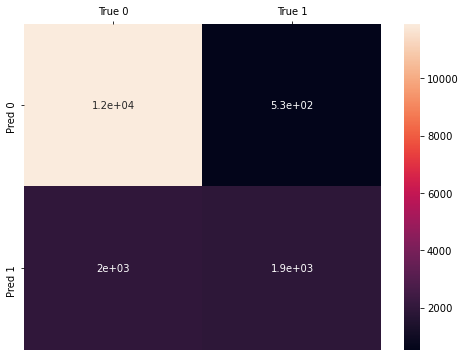

In [321]:
#Creating confusion matrix for proportion
preds = np.where(preds < 0.5, 0, 1)
create_confusion_matrix(preds, test_y)

### Neural-network-results

#### Evaluation
From the above cells, running the evaluate function on the model with the test dataset shows an accuracy of nearly 0.85, which is excellent. Noticable improvement was seen when feature pruning was introduced (was ~0.78 accuracy).
#### Confusion Matrix
The confusion matrix shows the greatest improvement with feature pruning - before, there were <100 guesses for >50k classifications total. Now, there is a large chunk of true-positives (and false positives). 

## ==========================================================

### Naive-bayes
#### Why I chose this algorithm
Naive bayes are great for classifying large datasets with many features. Computationally, they are significantly faster than most other algorithms. Additionally, this takes a different approach - the assumption with "naive" bayes is that all features are independent. Most other algorithms, such as the neural network, look for patterns among features and classes, but this assumes total independence of each feature from one another.
#### Pros
* Fast
* Simple to implement, fewer hyperparameters to tweak for best results
* When assumption of independence holds true, classifies better than most models

#### Cons
* Due to less hyperparameters, more rigid to results - what you get is what you get
* Anything in test data not in training data will be set to probability 0, and model will be unable to make a prediction for that class
* Assumption of indendence is rarely true

#### Improvements that could be made to my implementation
* Instead of a naive bayes approach, spending time to implement a bayesian network instead where features are related to each other
* Create a generative model for missing data, so model doesn't have to guess 0 if the data is missing

In [322]:
from sklearn.naive_bayes import GaussianNB
#Load
train_csv, test_csv = load_datasets()

#Prune
train_csv = prune(train_csv)
test_csv = prune(test_csv)

#Convert object columns to discrete numerical values
train_csv = convert_to_discrete(train_csv)
test_csv = convert_to_discrete(test_csv)

#Sort into train/test sets
train_y = train_csv.pop('class').to_numpy()
train_x = train_csv.to_numpy()
test_y = test_csv.pop('class').to_numpy()
test_x = test_csv.to_numpy()

#Create Gaussian Naive Bayues, fit, get the y-scores, and show ROC curve
gnb = GaussianNB()
start = time.time()
gnb.fit(train_x, train_y)
end = time.time()

hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("Runtime of NB: {:0>2}:{:0>2}:{:05.2f} (HH:MM:SS.MS)".format(int(hours),int(minutes),seconds))

Runtime of NB: 00:00:00.01 (HH:MM:SS.MS)


#### NB-accuracy

In [334]:
preds = gnb.predict(test_x)
print('Accuracy: {0:.{1}f}'.format((preds == test_y).sum() / len(test_y), 4))

Accuracy: 0.7988


In [335]:
#Get ROC curve variables
nb_score = gnb.predict_proba(test_x)
nb_fpr, nb_tpr, _ = roc_curve(test_y, nb_score[:, 1])
nb_roc_auc = auc(nb_fpr, nb_tpr)

#### NB-CM

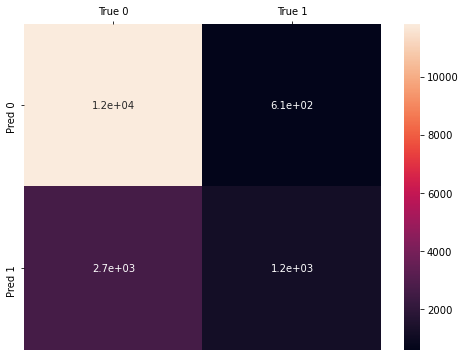

In [324]:
create_confusion_matrix(preds, test_y)

### NB-results
#### Evaluation
From the above cells, running the evaluate function on the model with the test dataset shows an accuracy of nearly 0.80.
#### Confusion Matrix
Again, significant improvement thanks to feature pruning. The largest error seems to be with false positives, opposite of what the case was with the neural network. While the neural network trains and updates, the naive bayes algorithm relies on probabilities from the training set, which don't update over time.

## ==========================================================

### Support-vector-machines
#### Why I chose this algorithm
Support Vector Machiones work well when there are clear separations between classes. Additionally, SVM's are more effective in high-dimensional spaces.

#### Pros
* Effective in higher dimensions
* Great when classes are separable
* Outliers have less impact

#### Cons
* Very slow
* The more overlap classes have, the worse the performance
* Selecting hyperparameters and kernel functions can be difficult

#### Improvements that could be made to my implementation
* Due to time constraints, I went with scikit's built in SVM. Given time, I'd be able to fiddle around with this more and pick the best options for this SVM
* This one is just a time constraint, but due to the time SVM's take to train, include more samples in the fitting method/using a linear kernel.

In [326]:
#Load and format data
train_csv, test_csv = load_datasets()

#Prune
train_csv = prune(train_csv)
test_csv = prune(test_csv)

#Convert object columns to discrete numerical values
train_csv = convert_to_discrete(train_csv)
test_csv = convert_to_discrete(test_csv)

In [327]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


#Get random sample of 20000
train_csv = train_csv.sample(n=20000)
train_y = train_csv.pop('class').to_list()
train_x = train_csv.values.tolist()

test_y = test_csv.pop('class').to_list()
test_x = test_csv.values.tolist()

#Fit SVM
start = time.time()
svm = SVC(kernel='poly', probability=True)
svm.fit(train_x,train_y)
end = time.time()

hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("Runtime of SVM: {:0>2}:{:0>2}:{:05.2f} (HH:MM:SS.MS)".format(int(hours),int(minutes),seconds))

Runtime of SVM: 00:00:15.26 (HH:MM:SS.MS)


#### SVM-accuracy

In [328]:
#Show accuracy
preds = svm.predict(test_x)
print('Accuracy: {0:.{1}f}'.format(accuracy_score(test_y, preds), 4))

Accuracy: 0.7879


In [336]:
#Create AUROC
svm_score = svm.predict_proba(test_x)
svm_fpr, svm_tpr, _ = roc_curve(test_y, svm_score[:, 1])
svm_roc_auc = auc(svm_fpr, svm_tpr)

#### SVM-CM

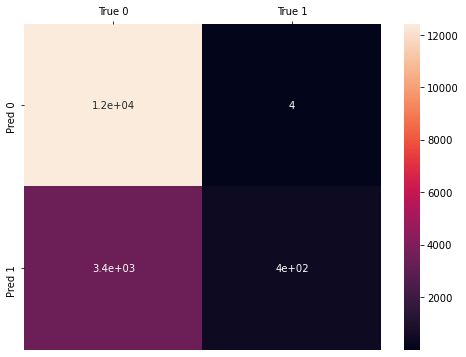

In [329]:
#Show confusion matrix
create_confusion_matrix(preds, test_y)

### SVM-results
#### Evaluation
From the above cells, running the evaluate function on the model with the test dataset shows an accuracy of almost 0.79. Currently, only 20,000 samples are used for training due to the time it takes for this algorithm to run. I attempted to use a liner kernel on 2,000 samples overnight, and that process either froze or never finished.

#### Confusion Matrix
This confusion matrix shows most classifications leaning away from classifying as >50k. Interestingly, there are only 4 false negatives predicted. I would like to see how this algorithm performs with a linear kernel on the entire dataset, as soon as I get my hands on a space-age computer fast enough to do that training in my lifetime.

## ROC-curves
Displayed here are the 3 ROC curves for each classification algorithm used above.

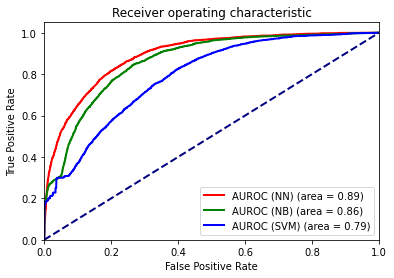

In [337]:
plt.figure()
lw = 2
plt.plot(nn_fpr, nn_tpr, color='r',
         lw=lw, label='AUROC (NN) (area = %0.2f)' % nn_roc_auc)
plt.plot(nb_fpr, nb_tpr, color='g',
         lw=lw, label='AUROC (NB) (area = %0.2f)' % nb_roc_auc)
plt.plot(svm_fpr, svm_tpr, color='b',
         lw=lw, label='AUROC (SVM) (area = %0.2f)' % svm_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Above, we can see how each algorithm did, with the neural network having the greatest area under the ROC curve, followed by the naive-bayes algorithm, and lastly with the SVM. 
* I anticipated the NN doing extremely well, as finding the common segments and patterns here would be a fitting task for such an algorithm. 
* I am surprised by the naive bayes a bit - later, I will discuss how these features relate, and naive bayes assumes feature independence. 
* It's not too surprising to see the SVM not doing as well, given the time constraint - again, more time would have likely shown a better fit with the linear kernel.

## ==========================================================

## Segmentation

One way to segment would be to try and group people based on analysis of the above attributes
* Age - Seems to be a trend present, middle ages have higher percentages of people making >50k
* Workclass - Certain classes, such as self-empl-inc, have higher percentages of people making >50k
* Education - Higher education correlates to higher percentages of people making >50k
* Marital Status - Married people have higher percentages of people making >50k compared to data
* Occupation - Some jobs, such as managers/executives, have higher percentages of people making >50k
* Relationship - Married people have higher percentages of people making >50k
* Race - Certain races have lower percentages of people making >50k
* Sex - Men tend to have higher percentages of people making >50k
* Capital Gain - Certain splits, such as 7,000-20,000, higher percentages of people making >50k
* Native Country - Some countries have higher or lower percentages of people making >50k

Looking further at these features, several of these are related: Age, Workclass, Education, Marital Status, Occupation, Relationship, and possibly Capital Gain.
* Generally, it takes a person many years to finish a Masters or Professional Schoool, and even longer to finish a Doctoral degree (linked to higher percentages)
* Additionally, people don't often start at the manager/executive level - this takes several years
* While many younger people do get married, it is often something that takes time

Because of this, a person's age is a factor in their occupation, education, marital status, and most of what affects their income.

Given this information, we could segment certain demographics, such as married men, or executives. Let's look at a few segments from the above information.



### Manual-segmentation

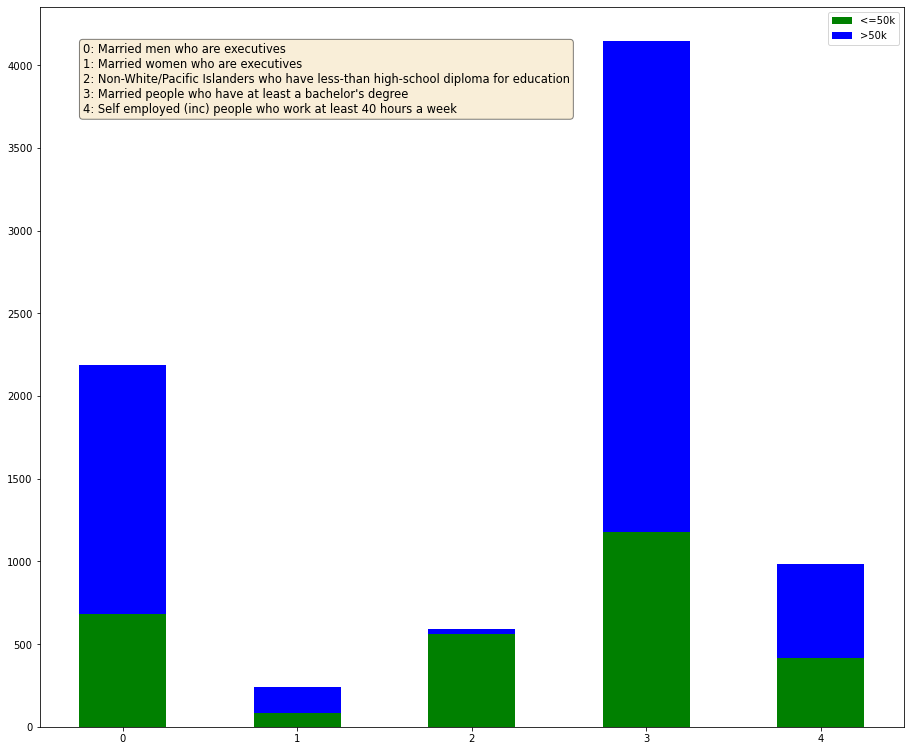

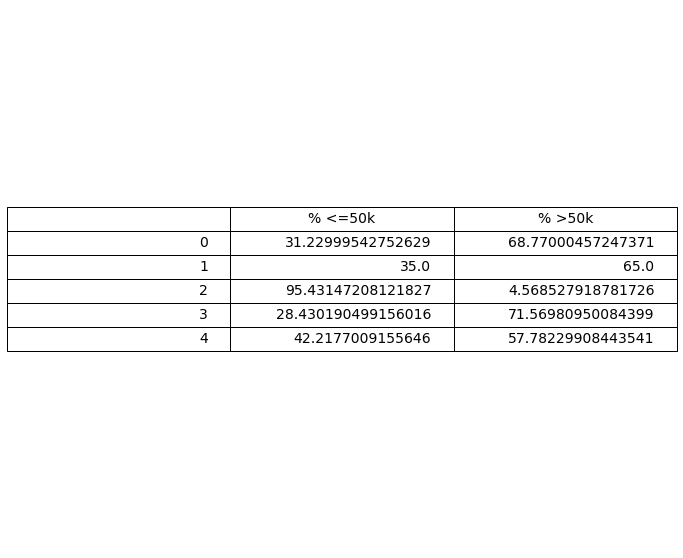

In [38]:
#First segment - married men who are executives
train_csv, test_csv = load_datasets()

train_csv['class'] = pd.Categorical(train_csv['class'])
train_csv['class'] = train_csv['class'].cat.codes
ds = pd.concat([train_csv, test_csv], axis=0)
segments = []

temp = ds.loc[(ds['relationship'] == ' Husband') & (ds['occupation'] == ' Exec-managerial')]
lte50k = len(temp.loc[temp['class'] == 0].index)
gt50k = len(temp.loc[temp['class'] == 1].index)
segments.append([lte50k, gt50k])

#Second segment - married women who are executives
temp = ds.loc[(ds['relationship'] == ' Wife') & (ds['occupation'] == ' Exec-managerial')]
lte50k = len(temp.loc[temp['class'] == 0].index)
gt50k = len(temp.loc[temp['class'] == 1].index)
segments.append([lte50k, gt50k])

#Third segment - non-white/pacific islanders who have little education
lower_educations = [' 12th', ' 10th', ' 5th-6th', ' 1st-4th', ' Preschool' ' 7th-8th', ' 9th', ' 11th']
temp = ds.loc[(ds['race'] != ' White') & (ds['race'] != ' Asian-Pac-Islander') & (ds['education'].isin(lower_educations))]                                                                         
lte50k = len(temp.loc[temp['class'] == 0].index)
gt50k = len(temp.loc[temp['class'] == 1].index)
segments.append([lte50k, gt50k])

#Fourth segment - married people who have at least a bachelors degree
higher_educations =[' Prof-school', 'Doctorate', ' Masters', ' Bachelors']
temp = ds.loc[((ds['relationship'] == ' Husband') | (ds['relationship'] == ' Wife')) & (ds['education'].isin(higher_educations))]                                                                       
lte50k = len(temp.loc[temp['class'] == 0].index)
gt50k = len(temp.loc[temp['class'] == 1].index)
segments.append([lte50k, gt50k])

#Fifth segment - self-empl-inc who work at least 40 hours per week
temp = ds.loc[(ds['workclass'] == ' Self-emp-inc') & (ds['hours-per-week'] >= 40)]
lte50k = len(temp.loc[temp['class'] == 0].index)
gt50k = len(temp.loc[temp['class'] == 1].index)
segments.append([lte50k, gt50k])

#Create bargraph
y0 = [i[0] for i in segments]
y1 = [i[1] for i in segments]
x = np.arange(len(y0))
width = 0.5
fig = plt.figure(1, figsize=(12, 10))
ax = fig.add_axes([0,0,1,1])
ax.bar(x, y0, width, color='g', label='<=50k')
ax.bar(x, y1, width,bottom=y0, color='b', label='>50k')
x = ['0: Married men who are executives', 
'1: Married women who are executives',
'2: Non-White/Pacific Islanders who have less-than high-school diploma for education',
'3: Married people who have at least a bachelor\'s degree',
'4: Self employed (inc) people who work at least 40 hours a week']

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, '\n'.join(x), transform=ax.transAxes, fontsize=11.5,
        verticalalignment='top',horizontalalignment='left', bbox=props)
ax.legend()
plt.show()

#Create table
y0_p = []
y1_p  = []
for i in range(len(y0)):
    y0_p.append((y0[i]/(y0[i]+y1[i]))*100)
    y1_p.append((y1[i]/(y0[i]+y1[i]))*100)

x = np.arange(len(x))
table_data = []
for i in range(len(y0)):
    table_data.append([x[i], y0_p[i], y1_p[i]])

cols = ['', '% <=50k', '% >50k']
g = plt.figure(2, figsize=(12, 10))
ax = g.add_subplot(1,1,1)
table = ax.table(cellText=table_data, colLabels = cols, loc='center')
table.set_fontsize(14)
table.scale(1,2)
ax.axis('off')
plt.show()

Above, we see several segments that could be made, both signficantly greater percent in the >50k class, and one for significantly less. There are more segments that could be made by hand that will give both above and below average percentages, but I will be doing something different.

### Automated-segmentation

One last approach that I will showcase for segmenting - we could instead use a brute force method, analyzing certain datasets that perform better in our training set.
A problem with a brute force method is trying to analyze all features - unfortunately, if we did that, there are 8,628,360,700,000,000 possible categories in the set of cartesian products for all features. 

If we remove certain features and focus only on a few, we get a more manageable number of categories - 6,350,400, to be exact.

Features to remove:
* Ages - as discussed above, age is reflected in many other features, which will be on this list
* Relationship - same as marital status
* Capital Gain/Capital Loss - too many items to include for this example
* Hours per week - too many items to include for this example

Below, we will save notable results - those that have >=15 matching cases, into a text file for future use.

In [39]:
train_csv, test_csv = load_datasets()
train_csv.pop('education-num')
test_csv.pop('education-num')
feat_atts = defaultdict(list)


#Workclasses
feat_atts['workclass'] = train_csv['workclass'].unique()

#Education
feat_atts['education'] = train_csv['education'].unique()

#Marital-status
feat_atts['marital-status'] = train_csv['marital-status'].unique()

#Occupation
feat_atts['occupation'] = train_csv['occupation'].unique()

#Race
feat_atts['race'] = train_csv['race'].unique()

#Sex
feat_atts['sex'] = train_csv['sex'].unique()


#Native country
feat_atts['native-country'] = train_csv['native-country'].unique()


In [40]:
import itertools
from collections import Counter
from random import shuffle

#Create cartesian product list of all possible combinations for each sublist
cart_prod = list(itertools.product(*list(feat_atts.values())))
#Shuffle (used for testing purposes, no impact on production)
shuffle(cart_prod)
#Create defaultdict which defaults to counter
cart_prod_dict = defaultdict(Counter)
#Columns used in brute force method
cols_of_importance = ['workclass', 'education', 'marital-status', 'occupation', 'race', 'sex', 'native-country']

In [41]:
#Convert train_csv to 0's and 1's
train_csv['class'] = pd.Categorical(train_csv['class'])
train_csv['class'] = train_csv['class'].cat.codes

def check_combinations(comb_set):
    #Count which combination currently checking
    for count, comb in enumerate(comb_set):
        #Create temporary copy of train_csv dataset
        temp = train_csv.copy(True)
        #Loop through every column specified, and narrow down the temp dataset based on current combination and specified column
        for i, col in enumerate(cols_of_importance):
            temp = temp.loc[temp[col] == comb[i]]
        
        #Count rows with class <=50k and >50k
        lte50k = len(temp.loc[temp['class'] == 0].index)
        gt50k = len(temp.loc[temp['class'] == 1].index)
        
        #Add counts to counter at specified combination
        cart_prod_dict[comb][0] += lte50k
        cart_prod_dict[comb][1] += gt50k
        
start = time.time()
check_combinations(cart_prod)
end = time.time()
    
with open('brute_force_results.data', 'w') as f:
    #End timer and display results in HH:MM:SS.MS
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    f.write("Runtime of brute force method: {:0>2}:{:0>2}:{:05.2f} (HH:MM:SS.MS)\n\n".format(int(hours),int(minutes),seconds))

    #Go through each result, calculate if significant
    notable_results = {}
    for k, v in cart_prod_dict.items():
        if v[0] + v[1] >= 15:
            perc = v[1] / (v[0] + v[1])
            if perc <= 0.2 or perc >= 0.3:
                notable_results[k] = [v[0], v[1], (v[1] / (v[0] + v[1])) * 100]
    notable_results = sorted(notable_results.items(), key=lambda x: x[1][2], reverse=True)

    #Save results of significance to file for future use
    f.write('Results sorted by descending % >50k\nKeywords are from the below columns, in order:\nWorkclass, Education, Marital-status, Occupation, Race, Sex, Country-of-origin')
    f.write('='*75)
    f.write('\n')

    for i in notable_results:
        #print("{}\n<=50k: {}, >50k: {}, % >50k: {:.2f}%\n".format(i[0], i[1][0], i[1][1], i[1][2]))
        f.write("{}\n<=50k: {}, >50k: {}, % >50k: {:.2f}%\n".format(i[0], i[1][0], i[1][1], i[1][2]))



Runtime of brute force method: 12:43:33.08 (HH:MM:SS.MS)


Results sorted by descending % >50k
Keywords are from the below columns, in order:
Workclass, Education, Marital-status, Occupation, Race, Sex, Country-of-origin


(' Self-emp-inc', ' Prof-school', ' Married-civ-spouse', ' Prof-specialty', ' White', ' Male', ' United-States')
<=50k: 1, >50k: 56, % >50k: 98.25%

(' Private', ' Doctorate', ' Married-civ-spouse', ' Exec-managerial', ' White', ' Male', ' United-States')
<=50k: 1, >50k: 15, % >50k: 93.75%

(' Federal-gov', ' Some-college', ' Married-civ-spouse', ' Exec-managerial', ' White', ' Male', ' United-States')
<=50k: 1, >50k: 14, % >50k: 93.33%

(' Private', ' Masters', ' Married-civ-spouse', ' Exec-managerial', ' White', ' Male', ' United-States')
<=50k: 12, >50k: 159, % >50k: 92.98%

(' Local-gov', ' Masters', ' Married-civ-spouse', ' Exec-managerial', ' White', ' Male', ' United-States')
<=50k: 3, >50k: 24, % >50k: 88.89%

(' State-gov', ' Doctorate', ' Married-civ-spouse

In [2]:
data = defaultdict(str)
#Load data
with open('brute_force_results.data', 'r') as f:
    for x, line in enumerate(f):
        #First 7 lines are just header lines
        if x > 7:
            #Some newlines in data
            if line == '\n':
                continue
            #print(x, line)
            if x % 3 == 2:
                key = line.strip(' \t\n\r')
            elif x % 3 == 0:
                data[key] = line
        else:
            print(line)

#Convert key'd data from str to lists
sorted_data = {}               
for k in data.keys():
    temp = data[k].replace('\n', '').replace('<=50k', '0').replace('>50k', '1').replace('% 1', '%')[:-1].split(', ')
    temp_dict = {0: int(temp[0][temp[0].find(' ')+1:]),
                1: int(temp[1][temp[1].find(' ')+1:]),
                '%': float(temp[2][temp[2].find(' ')+1:])}
    sorted_data[k] = temp_dict

#Sort data by % >50k
sorted_data = sorted(sorted_data.items(), key=lambda x: x[1]['%'], reverse=True)

for i in sorted_data:
    print(i[0], '\n', i[1], '\n')



NameError: name 'defaultdict' is not defined

In [1]:
#Get category counts
cat_counts = [0, 0]
for i in sorted_data:
    if i[1]['%'] < 25:
        cat_counts[0]+=1
    else:
        cat_counts[1]+=1

lt25p = round((cat_counts[0] / (cat_counts[0]+cat_counts[1])*100), 2)
gte25p = round((cat_counts[1] / (cat_counts[0]+cat_counts[1])*100), 2)
print('{}, or {}% of categories with <25% making >50k'.format(cat_counts[0], lt25p))
print('{}, or {}% of categories with over >=25% making >50k'.format(cat_counts[1], gte25p))
print()

#Get people counts
people_counts = [[0, 0], [0, 0]]
for i in sorted_data:
    if i[1]['%'] < 25:
        people_counts[0][0]+=i[1][0]
        people_counts[0][1]+=i[1][1]
    else:
        people_counts[1][0]+=i[1][0]
        people_counts[1][1]+=i[1][1]

lt25p = round((people_counts[0][1]/(people_counts[0][0]+people_counts[0][1])*100), 2)
gte25p = round((people_counts[1][1]/(people_counts[1][0]+people_counts[1][1])*100), 2)
print('{} are in the "<25% making >50k" categories. Of those people, there are {}% making >50k'.format(people_counts[0][0]+people_counts[0][1], lt25p))
print('{} are in the ">=25% making >50k" categories. Of those people, there are {}% making >50k'.format(people_counts[1][0]+people_counts[0][1], gte25p))

NameError: name 'sorted_data' is not defined

From the above results, we can clearly see some very interesting trends based on the categorical data alone.
* The best performing category, with 56 out of 57 samples making >50k, are self-emp-inc, have prof-school education, are married-civ-spouse, have prof-specialty occupation, are white males, and live in the US.
* Almost every category above 40% has 'Married-civ-spouse' for marital status.
* Workclass alone doesn't seem to be as correlated to success - the top 6 performing categories all have different workclasses. However, many poor performing categories seem to have 'Private' for the workclass.
* Although 'White' is seen as race for most high-performers, it is also seen frequently in the average and low performers. This shows that 'White' was the largest race involved in this sample.
* There doesn't appear to be many, if any, native countries other than 'United-States'. This could be due to numerical features not included in this selection, or it shows less of a correlation for notable categories.
* 2/3 of notable categories have <25% making >50k, while the last third has >=25%.

Additional statistics at the bottom of the output:
* The percent of people in the >=25% making >50k category is over 1200% more than those in the <25% making 50k category.
* The percent in both sections shows a great variance compared to the 25/75 split seen in the data above.

### This is Matt Kennedy's submission for Aunalytics' Data Science Assessment.
I will start with a visualization of each feature, then work into preprocessing. Next, I will use several different classification methods, and end with analysis and segmentation.


##### Please note - any time the numbers '0' and '1' are used when referring to classes, classification, or targets, '0' means '<=50k annual salary', and '1' means '>50k annual salary'.

#### Table of Contents
* [Visualization](#Visualization)
 * [Age](#Age)
 * [Workclass](#Workclass)
 * [Fnlwgt](#Fnlwgt)
 * [Education](#Education)
 * [Marital-status](#Marital-status)
 * [Occupation](#Occupation)
 * [Race](#Race)
 * [Sex](#Sex)
 * [Capital-gain](#Capital-gain)
 * [Capital-loss](#Capital-loss)
 * [Hours-per-week](#Hours-per-week)
* [Chi-square-test](#Chi-square-test)


* [Data-preprocessing](#Data-preprocessing)
 * [Pruning](#Pruning)


* [Classification](#Classification)
 * [Neural-network](#Neural-network)
   * [Accuracy](#Neural-network-accuracy)
   * [Confusion matrix](#Neural-network-CM)
   * [Results](#Neural-network-results)
 * [Naive-bayes](#Neural-network)
   * [Accuracy](#NB-accuracy)
   * [Confusion matrix](#NB-CM)
   * [Results](#NB-results)  
 * [SVM](#Support-vector-machines)
   * [Accuracy](#SVM-accuracy)
   * [Confusion matrix](#SVM-CM)
   * [Results](#SVM-results) 
 * [ROC-curves](#ROC-curves)
 

* [Segmentation](#Segmentation)
   * [Manual-segmentation](#Manual-segmentation)
   * [Automated-segmentation](#Automated-segmentation)

In [177]:
#Imports used for NN
import pandas as pd
import tensorflow as tf
import numpy as np

#Used for visualization
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import plot_roc_curve, roc_curve, auc, confusion_matrix

from collections import defaultdict
import math
import time

In [178]:
#Methods are used through this notebook

#Loads train/test datasets
def load_datasets():
    
    #First row is headers, so just simple import on the csv data using pandas
    train_csv = pd.read_csv("au_train.csv")
    test_csv = pd.read_csv("au_test.csv")

    #Remove period from last character in class for test cases
    test_csv['class'] = test_csv['class'].str.replace('.', '')
    
    return train_csv, test_csv

#Convert object columns to discrete numerical values
def convert_to_discrete(ds):
    for col in ds:
        if ds[col].dtype == np.dtype('object'):
            temp_col = pd.Categorical(ds[col])
            temp_col = temp_col.codes
            ds[col] = temp_col
    
    return ds

## Visualization

In [179]:
train_csv, test_csv = load_datasets()
ds = pd.concat([train_csv, test_csv], axis=0)

"""
Creates and returns a bar chart
ds - dataset to evaluate
classes - different classes that an item can be categorized as (in this case, <=50k and >50k)
col - what column to look at
x - the x values for the bar chart
xlbl - the label for the x axis
ylbl - the label for the y axis
rotate - whether or not to rotate the x axis tickmarks

Returns:
y0 - Items belong to class <=50k
y1 - Items belong to class >50k
"""
def createBarChart(ds, classes, col, x, xlbl, ylbl, rotate=0):
    y = []
    for i in x:
        data = []
        for cls in classes:
            temp = ds.loc[(col == i) & (ds['class'] == cls)]
            data.append(temp.size)
        y.append(data)
    
    y0 = [i[0] for i in y]
    y1 = [i[1] for i in y]
    
    width = 0.5
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_axes([0,0,1,1])
    ax.bar(x, y0, width, color='g', label='<=50k')
    ax.bar(x, y1, width,bottom=y0, color='b', label='>50k')
    if rotate > 0:
        ax.set_xticklabels(x, rotation=rotate)
    ax.set_xlabel(xlbl)
    ax.set_ylabel(ylbl)
    ax.legend()
    ax.set_title("{} vs annual salary".format(col.name.capitalize()))
    plt.show()
    
    return y0, y1

"""
Creates and returns a bar chart for continuous data using a range (start, stop, step)
ds - dataset to evaluate
classes - different classes that an item can be categorized as (in this case, <=50k and >50k)
col - what column to look at
start - what number to start at
stop - what number to stop at
step - how large should each step be
xlbl - the label for the x axis
ylbl - the label for the y axis
width - width of each bar on graph (default is 0.5)

Returns:
y0 - Items belong to class <=50k
y1 - Items belong to class >50k
"""
def createBarChartContinuous(ds, classes, col, start, stop, step, xlbl, ylbl, width=0.5):
    y=[]
    
    for i in range(start, stop, step):
        data = []
        for cls in classes:
            temp = ds.loc[(col.between(i, i+step)) & (ds['class'] == cls)]
            data.append(len(temp.index))
        y.append(data)

    x = list(range(start, stop, step))
    y0 = [i[0] for i in y]
    y1 = [i[1] for i in y]

    width = width
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_axes([0,0,1,1])
    ax.bar(x, y0, width, color='g', label='<=50k')
    ax.bar(x, y1, width,bottom=y0, color='b', label='>50k')
    
    ax.set_xlabel(xlbl)
    ax.set_ylabel(ylbl)
    ax.legend()
    ax.set_title("{} vs annual salary".format(col.name.capitalize()))
    plt.show()
    
    return y0, y1

"""
Creates and returns a table that displays percentages
title - title of the column focused on
x - x values that were used for bar chart
y0 - Items belong to class <=50k
y1 - Items belong to class >50k
max - the stopping point for range of splits for continuous feature

Returns:
x_disp - x values that had corresponding y values (not 0) and were shown
y0_p - Percent of items belonging to class <=50k
y1_p - Percent of items belonging to class >50k
"""
def createTable(title, x, y0, y1, max=0):
    y0_p = []
    y1_p  = []
    x_disp = []
    for i in range(len(y0)):
        if y0[i] > 0 or y1[i] > 0:
            y0_p.append((y0[i]/(y0[i]+y1[i]))*100)
            y1_p.append((y1[i]/(y0[i]+y1[i]))*100)
            if i < len(x):
                x_disp.append(x[i])
            else:
                x_disp.append('> {}'.format(max))
        else:
            pass
            
    table_data = []
    for i in range(len(x_disp)):
        table_data.append([x_disp[i], y0_p[i], y1_p[i]])

    cols = [title, '% <=50k', '% >50k']
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(1,1,1)
    table = ax.table(cellText=table_data, colLabels = cols, loc='center')
    table.set_fontsize(14)
    table.scale(1,2)
    ax.axis('off')
    plt.show()
    
    return x_disp, y0_p, y1_p

"""
Creates and returns a table that displays percentages
title - title of the column focused on
x - x values that will be used
y0_p - Percent of items belonging to class <=50k
y1_p - Percent of items belonging to class >50k
xlbl - the label for the x axis
ylbl - the label for the y axis
rotate - whether or not to rotate the x axis tickmarks

Returns:
None
"""
def showScatter(title, x, y0_p, y1_p, xlbl, ylbl, rotate=0):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(1,1,1)
    ax.plot(x, y0_p, label='<=50k')
    ax.scatter(x, y0_p)
    ax.plot(x, y1_p, label='>50k')
    ax.scatter(x, y1_p)
    if rotate > 0:
        ax.set_xticklabels(x, rotation=rotate)
    ax.set_title("{} vs annual salary".format(title))
    ax.set_xlabel(xlbl)
    ax.set_ylabel(ylbl)
    ax.legend()
    plt.show()

In [180]:
#These will be used for each feature
temp_col = pd.Categorical(ds['class'])
temp_col = temp_col.codes
ds['class'] = temp_col
classes = ds['class'].unique()
ylbl = '# of people'

### Age
#### Bar Chart
From the bar chart, we can see there is a trend of ages where the number of people in the >50k class grows, from what looks like the ages of 28-65. This would suggest a correlation between age and salary

#### Table
The table gives more evidence to this correlation, showing that as age increases, so does likelihood of being in >50k class. After age 27, almost no ages drop to less than 10% making >50k. Ages 31-69 have >=20% that are in that class, and ages 37-61 have all but one where >=30% make >50k.

### Scatterplot
The scatterplot of each percentage shows a quadratic trend to age vs salary, displaying the ages discussed in the table section and how middle-aged people are more likely to be in the >50k category.

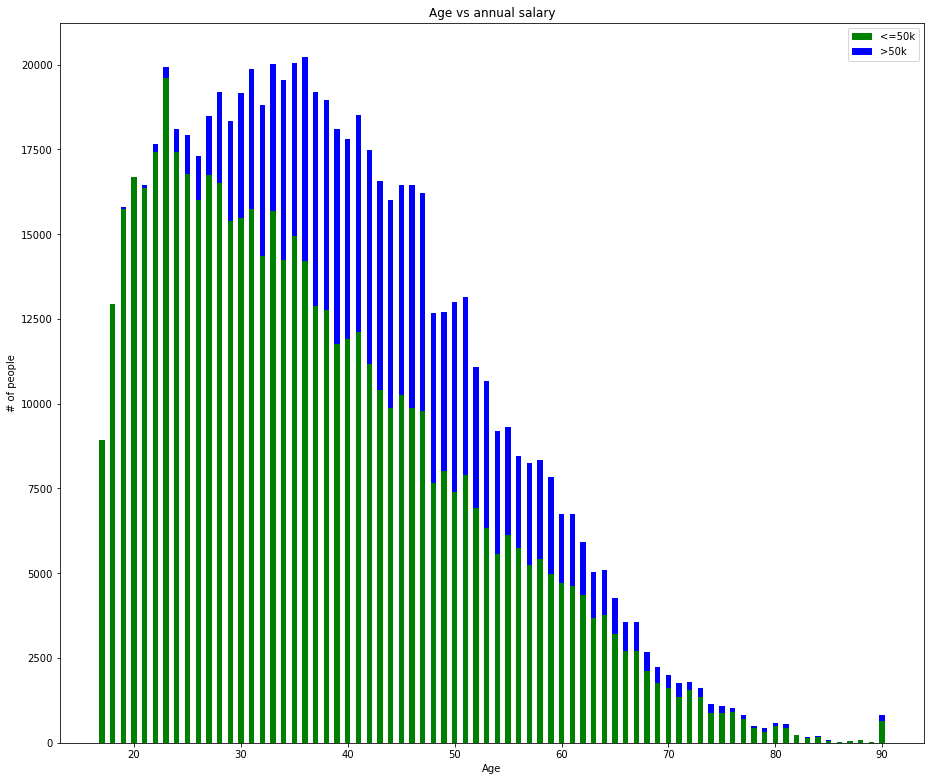

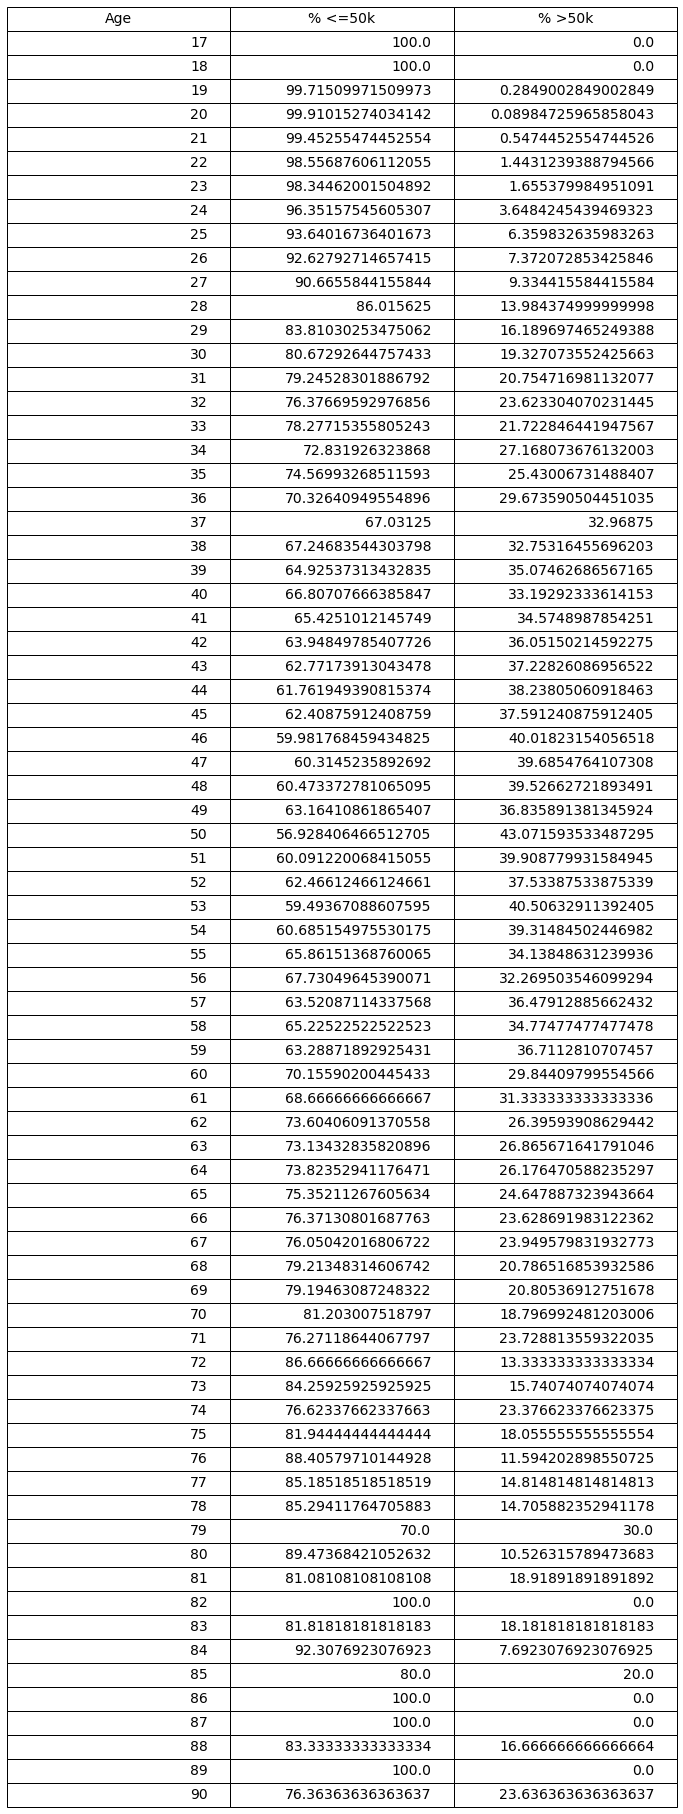

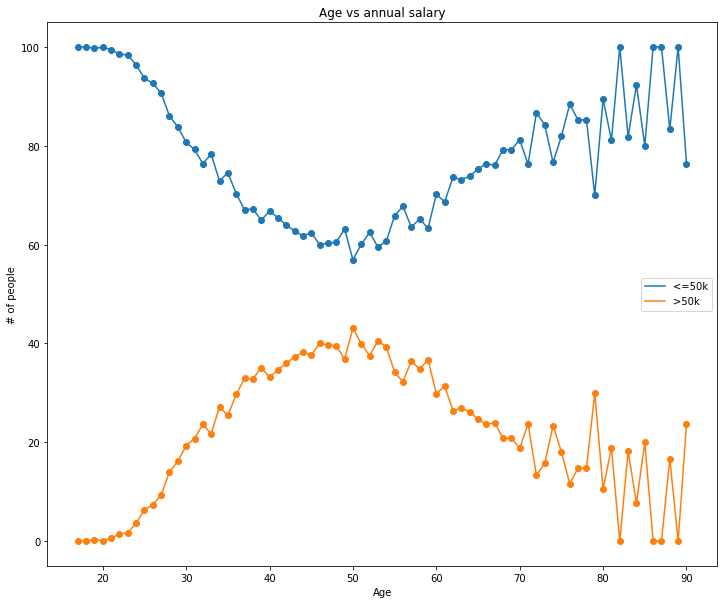

In [181]:
col = ds['age']
x = col.unique()
x.sort()

xlbl = col.name.capitalize()
y0, y1 = createBarChart(ds, classes, col, x, xlbl, ylbl)
x, y0_p, y1_p = createTable(xlbl, x, y0, y1)
showScatter(xlbl, x, y0_p, y1_p, xlbl, ylbl)

### Workclass
#### Bar Chart
The bar chart shows us that  almost all categories have noticable portions in the >50k class, all except unknown (?), without-pay, and never worked. Without pay had less than 20 people fitting this category, and it would make sense that most people without pay would make >50k annually.
#### Table
The table does confirm that most categories do well; however, there are some workclasses that do better than others. self-emp-inc are people who work for thesmelves in corporate entities. This workclass has an actual majority making >50k, with 55% fitting this.

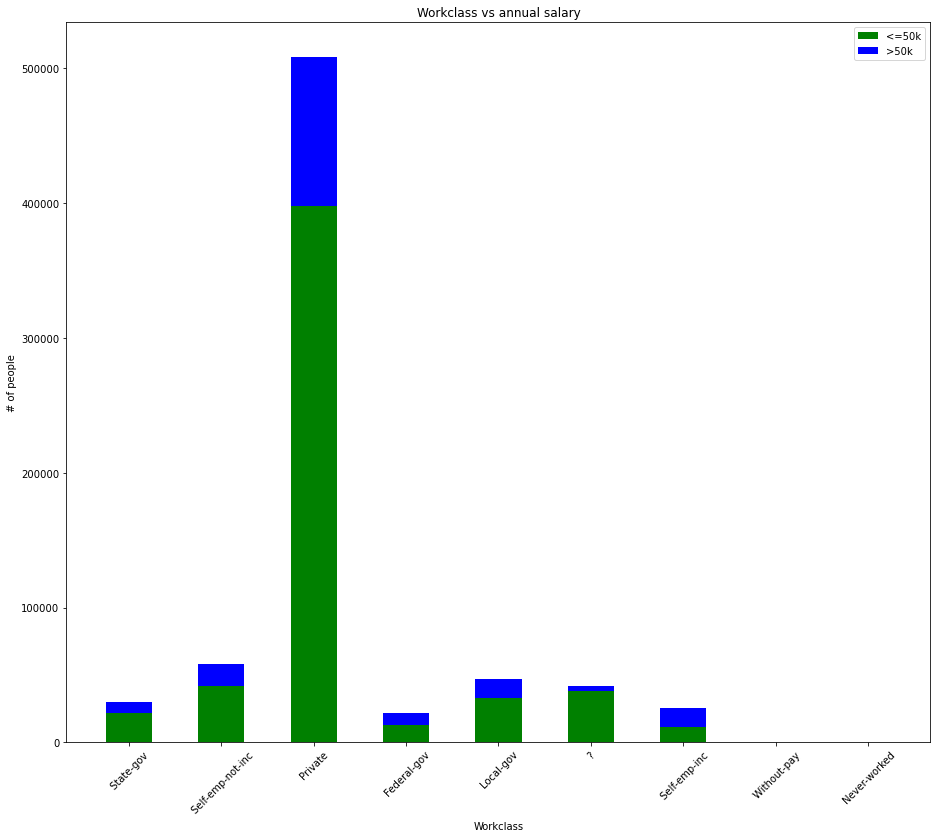

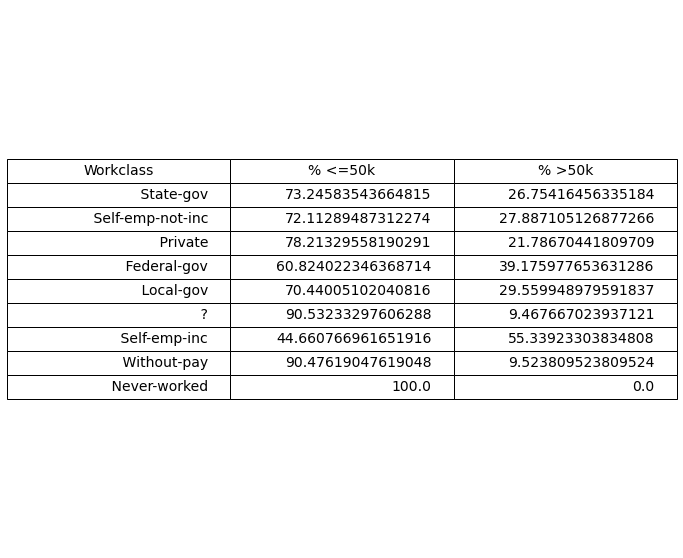

In [182]:
col = ds['workclass']
x = col.unique()
xlbl = col.name.capitalize()

y0, y1 = createBarChart(ds, classes, col, x, xlbl, ylbl, 45)
x, y0_p, y1_p = createTable(col.name.capitalize(), x, y0, y1)
#showScatter(xlbl, x, y0_p, y1_p, xlbl, ylbl)

### Fnlwgt
#### Bar Chart
Fnlwgt appears to have a similar quadratic trend to age, suggesting that fnlwgt is a noticable factor for determining class. The dropoff for # of people for each fnlwgt category drops off rather quickly, so this may be a reason why this quadratic curve exists - rather than correlation, this could be just causation.
#### Table
The table shows that, rather than a quadratic fit for percentages, there is actually a relatively linear fit with some noise. Most splits for this column have a 75-25 split for each class, which is similar to what the actual data is (roughly 75% are in the <=50k class, and roughly 25% are in the >50k class).

#### Scatterplot
The scatterplot visualizes this linear trend for us, showing a general updward curve in percent of people in the >50k class. However, in the first few splits, each value is relatively close to what it's neighbors are at, but as the splits increase, there is more deviation - the greater splits follow the 75-25 curve less, some with more and some with less in the >50k class.

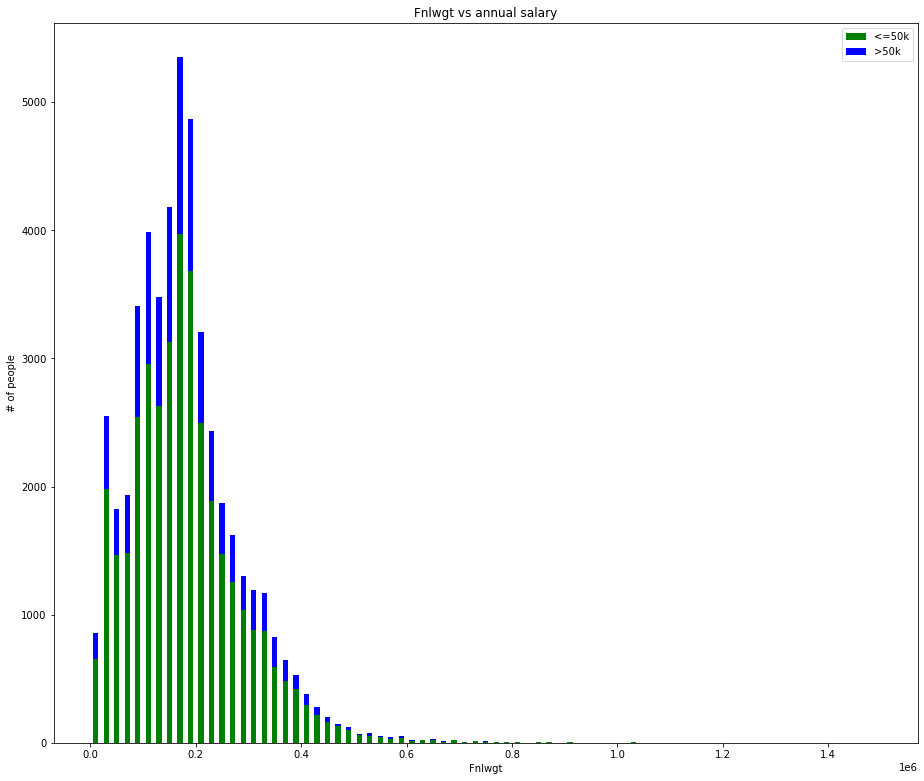

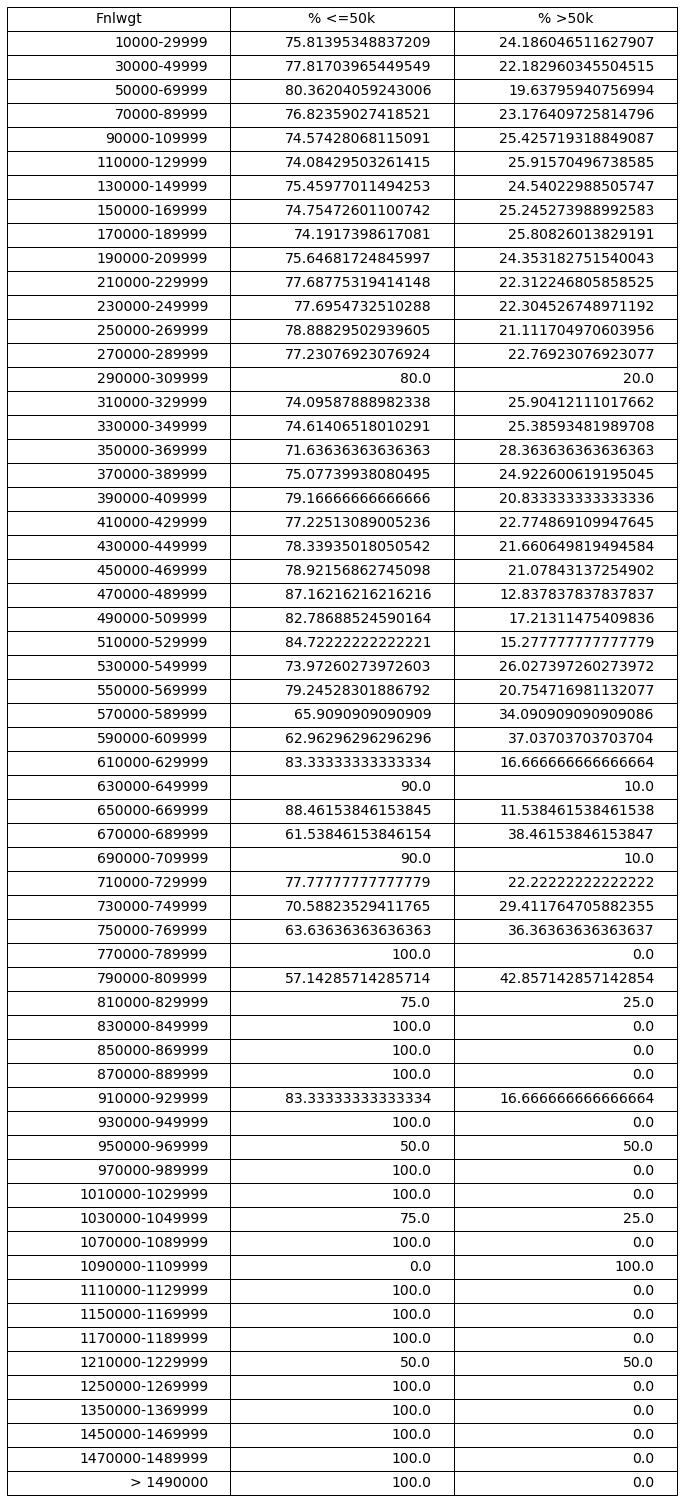

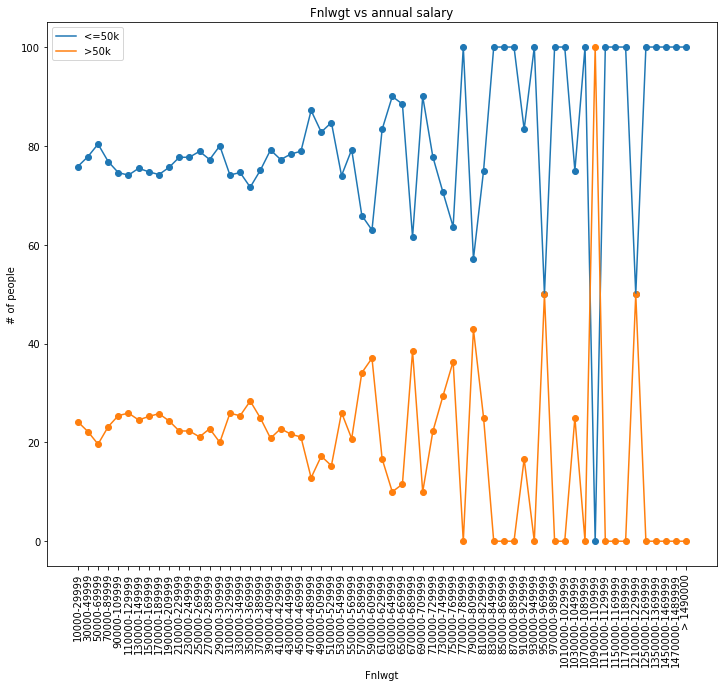

In [183]:
col = ds['fnlwgt']
start=10000
stop=1500000
step=20000
xlbl = col.name.capitalize()

y0, y1 = createBarChartContinuous(ds, classes, col, start, stop, step, xlbl, ylbl, 10000)

vals = list(range(start, stop, step))
x = []
for i in range(len(vals)-1):
    x.append("{}-{}".format(vals[i], vals[i+1]-1))

x, y0_p, y1_p = createTable(xlbl, x, y0, y1, max=1490000)
showScatter(xlbl, x, y0_p, y1_p, xlbl, ylbl, 90)

### Education
#### Bar Chart
The graph shows clear differences in proportions for each education category, with some having very few people in the >50k category, and some educations having a majority. It appears that the higher the education, the higher the percent making >50k annually.
#### Table
The percentages reinforce this theory that higher education correlates to greater salary - All levels below high-school grad have <10% making >50k. However, HS grad has nearly 16%, bachelors have a great increase at 41%, 3x as many as high school grad. Moving upward, Masters have 54%, and Doctorates have over 70% each. Furthermore, Assoc-acdm and Assoc-voc have ~25% each, and Prof school matches the doctorate at 70% making >50k.


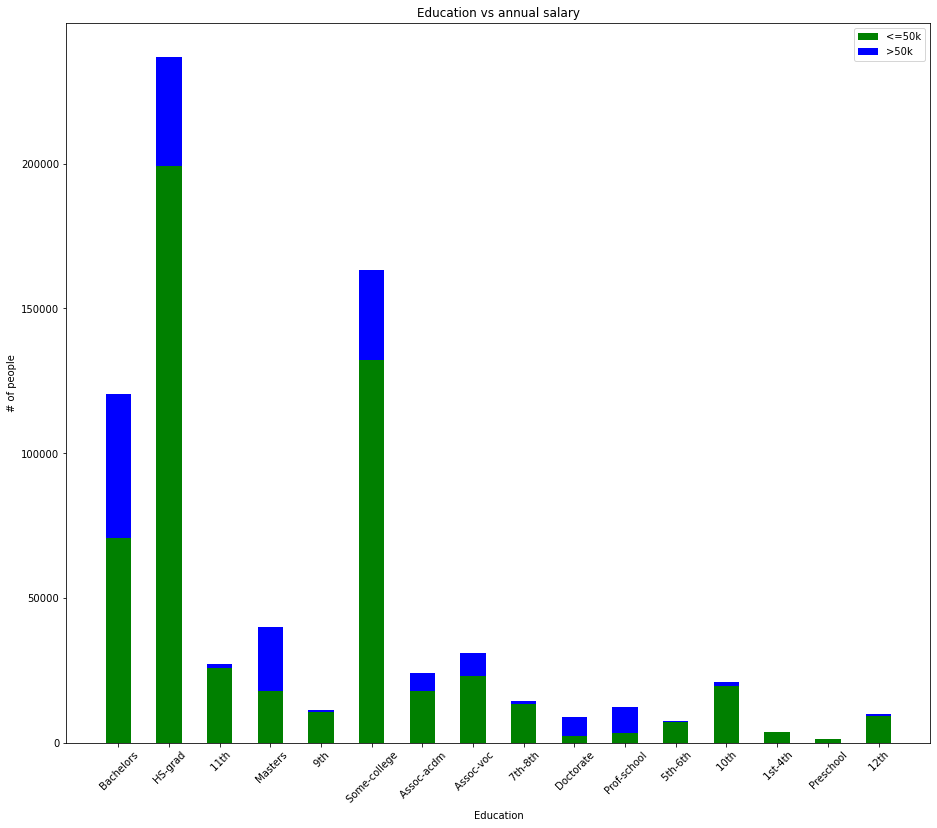

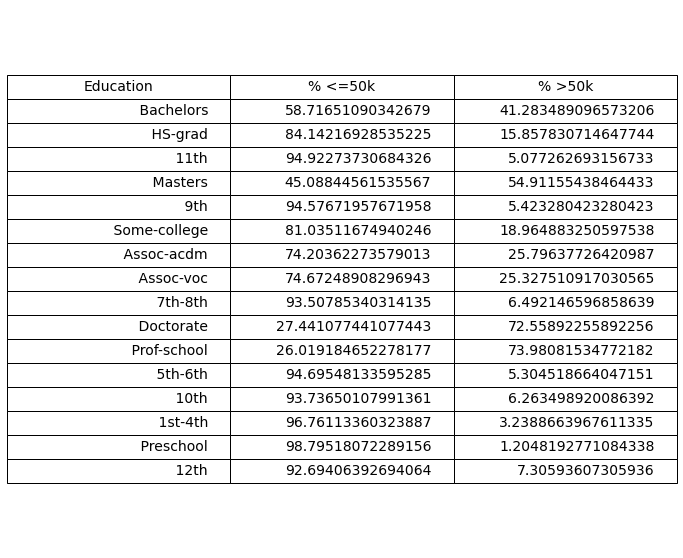

In [184]:
col = ds['education']
x = col.unique()
xlbl = col.name.capitalize()

y0, y1 = createBarChart(ds, classes, col, x, xlbl, ylbl, 45)
x, y0_p, y1_p = createTable(xlbl, x, y0, y1)
#showScatter(xlbl, x, y0_p, y1_p, xlbl, ylbl, 45)

### Marital-status
#### Bar Chart
Most categories for marital status are dominantly <=50k. There are only 2 categories that do exceptionally well - married-civ-spouse, and married-af-spouse. However, married-af-spouse has very few samples, so this may be innaccurate.
#### Table
The table for marital status shows that, indeed, married individuals do exceptionally better than those who aren't. Married civilian spouses have just under 45% making >50k annually, and armed-forces spouses are at ~37% in the same category.

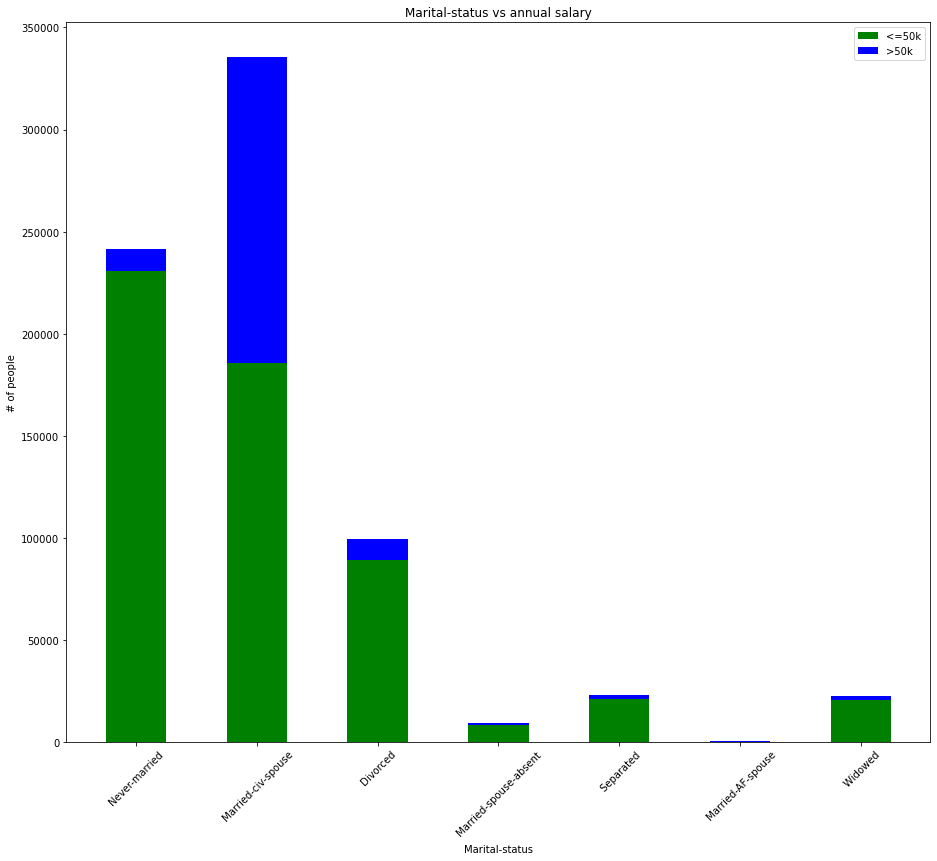

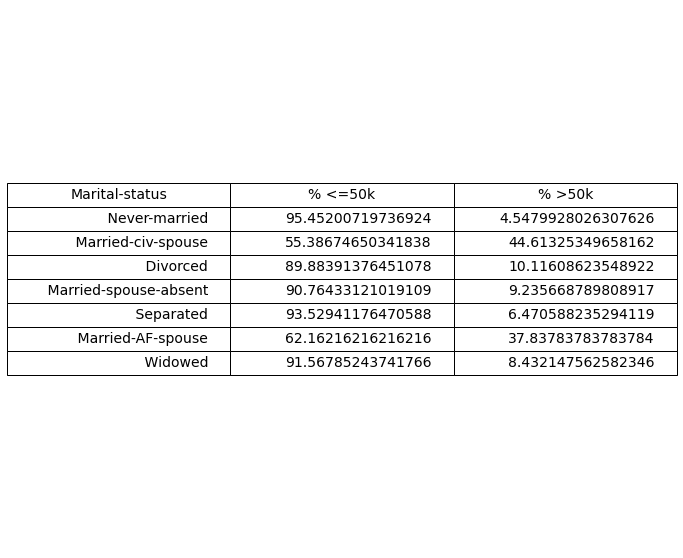

In [185]:
col = ds['marital-status']
x = col.unique()
xlbl = col.name.capitalize()

y0, y1 = createBarChart(ds, classes, col, x, xlbl, ylbl, 45)
x, y0_p, y1_p = createTable(xlbl, x, y0, y1)
#showScatter(xlbl, x, y0_p, y1_p, xlbl, ylbl,  45)

### Occupation
#### Bar Chart
Again, we see several categories that are mostly <=50k, but some that are a more even split. This would be expected of occupation, the source of income. Executive/managerial, professional/specialty, sales, and craft repair all seem to have noticable chunks in the >50k class.
#### Table
Exec-manageral performs the best with nearly 48% making >50k annually. Prof-speciality does nearly the same at 47%. Armed forces comes in 3rd at 33%, but again, this may be inaccurate as the small sample size. Protective-services follows up with 31%, which has a significantly large sample than armed forces.

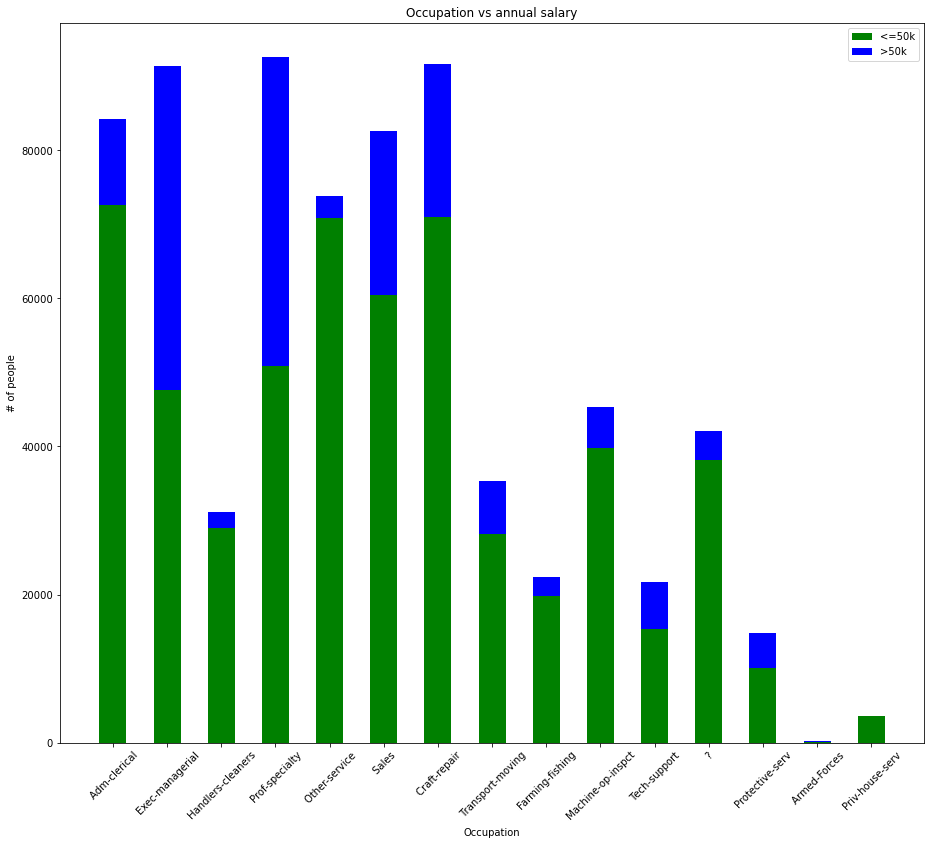

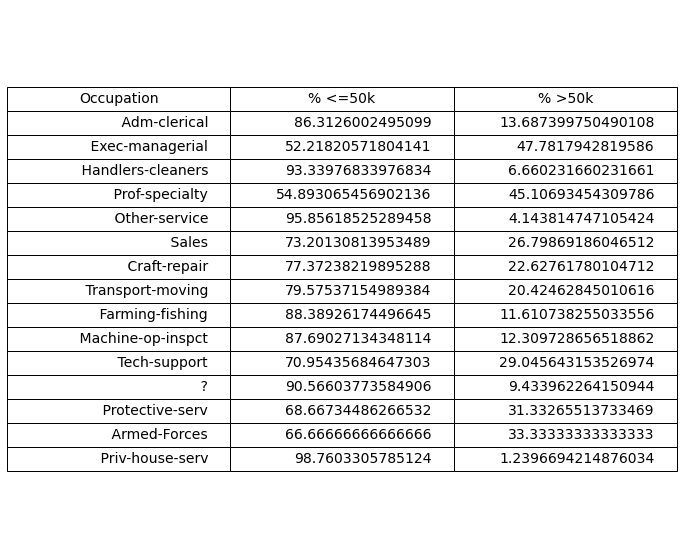

In [186]:
col = ds['occupation']
x = col.unique()
xlbl = col.name.capitalize()

y0, y1 = createBarChart(ds, classes, col, x, xlbl, ylbl, 45)
x, y0_p, y1_p = createTable(xlbl, x, y0, y1)
#showScatter(xlbl, x, y0_p, y1_p, xlbl, ylbl, 45)

### Relationship
#### Bar Chart
This chart is closely linked to the marital-status column - only the husband and wife categories have majorities making >50k annually. The rest have significantly fewer.
#### Table
Husband and wife, as shown, display the best results - however, wife actually has 46%, whereas husband has 44%. This is different than what the "sex" column will show later on, with women having a significantly smaller percentage making >50k.

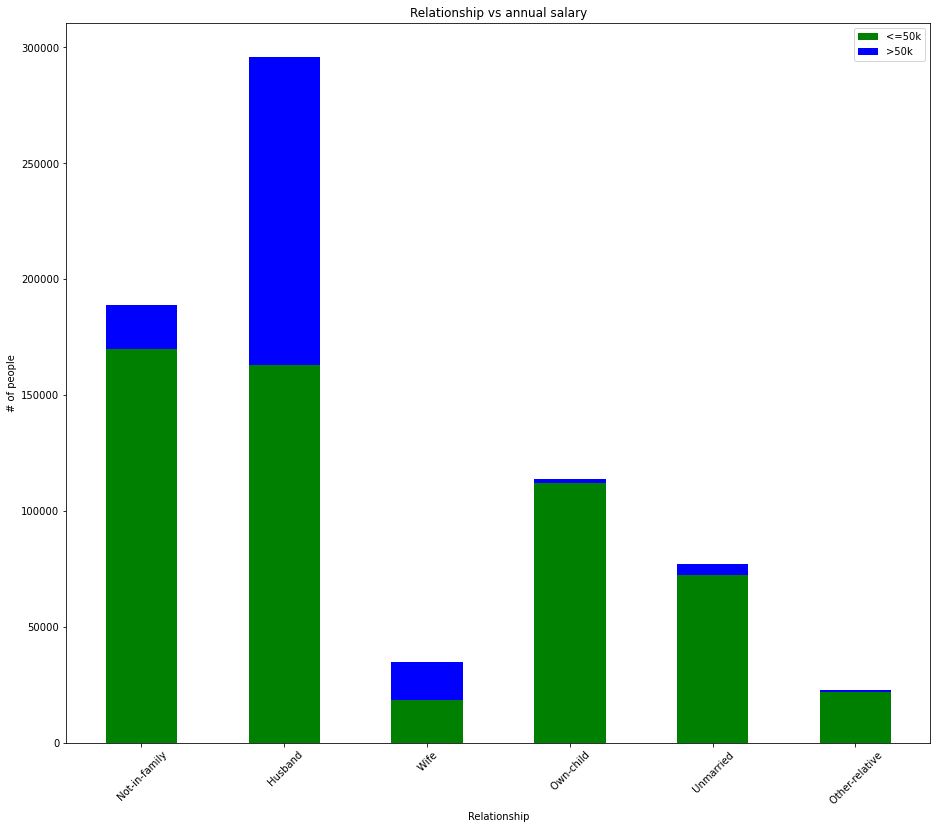

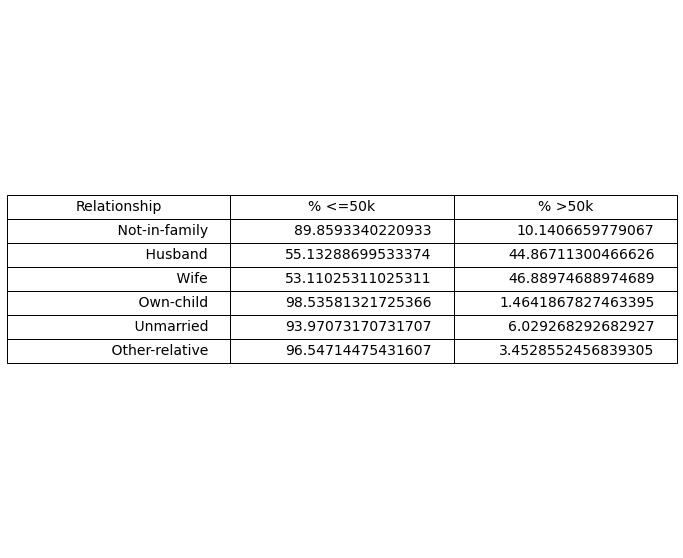

In [187]:
col = ds['relationship']
x = col.unique()
xlbl = col.name.capitalize()

y0, y1 = createBarChart(ds, classes, col, x, xlbl, ylbl, 45)
x, y0_p, y1_p = createTable(xlbl, x, y0, y1)
#showScatter(xlbl, x, y0_p, y1_p, xlbl, ylbl, 45)

### Race
#### Bar Chart
Here we can actually see a negative correlation - only white and pacific highlander seem to have a percentage of standard size making >50k. The rest have smaller percentages, showing that race could lead to a smaller salary. 
#### Table
As discussed, only white and pacific highlander have reasonable percentages. In fact, they follow the trend of the data presented, with 75% making <=50k, and 25% making >50k. The other races have smaller than 25% making >50k, in fact by half as much - black, amer-indian-eskimo, and other all have 11-12% in the >50k class.

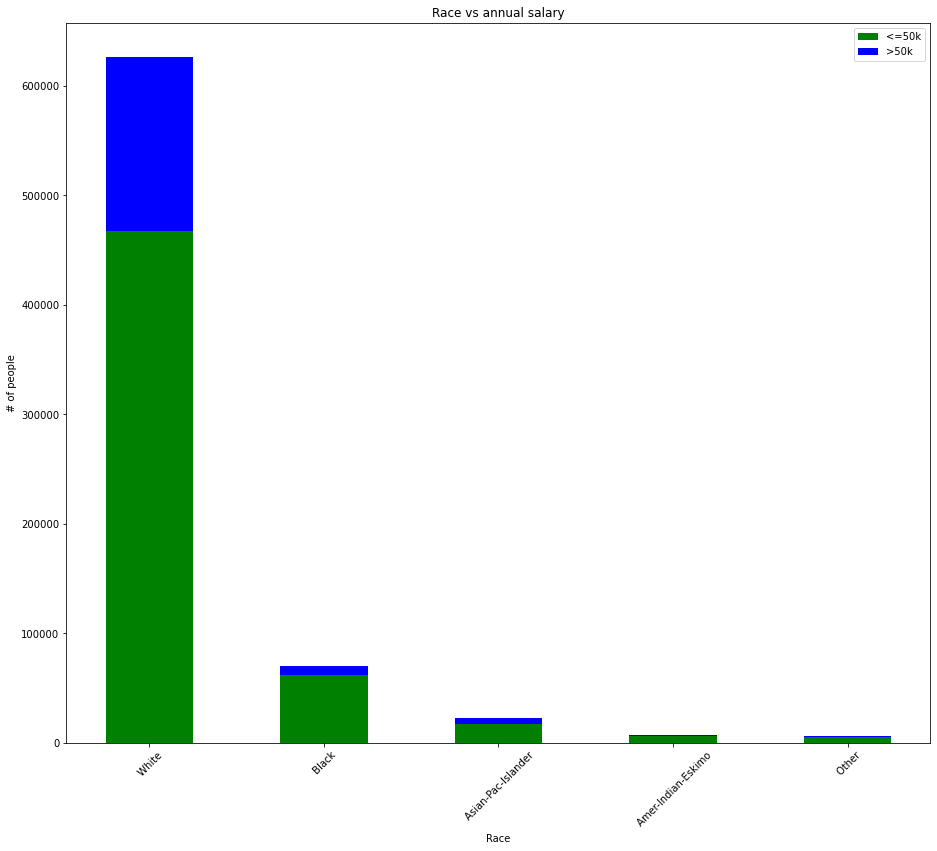

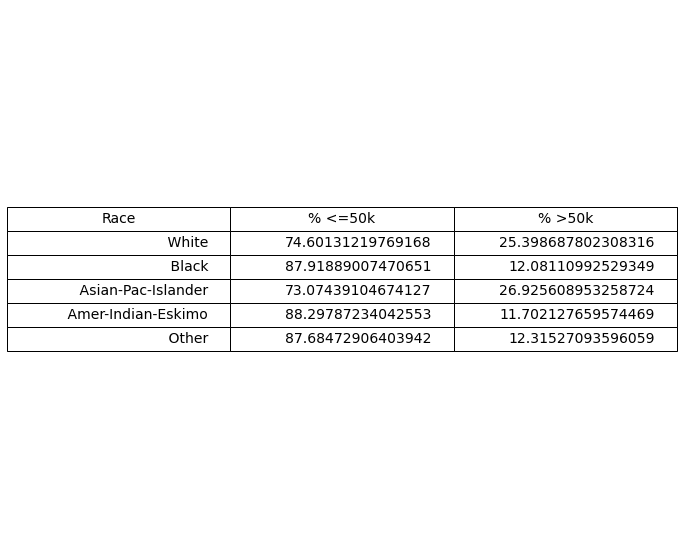

In [188]:
col = ds['race']
x = col.unique()
xlbl = col.name.capitalize()

y0, y1 = createBarChart(ds, classes, col, x, xlbl, ylbl, 45)
x, y0_p, y1_p = createTable(xlbl, x, y0, y1)
#showScatter(xlbl, x, y0_p, y1_p, xlbl, ylbl, 45)

### Sex
#### Bar Chart
From the earlier relationship column, we see husbands and wives with nearly the same percentage making >50k. Here, however, we see that men have a significantly higher percentage in this category.
#### Table
Again, men do, in fact, have a greater percentage making >50k - 20% more than women. In fact, men even have a greater percentage than the ~75-25 trend the data follows, while women have significantly less.

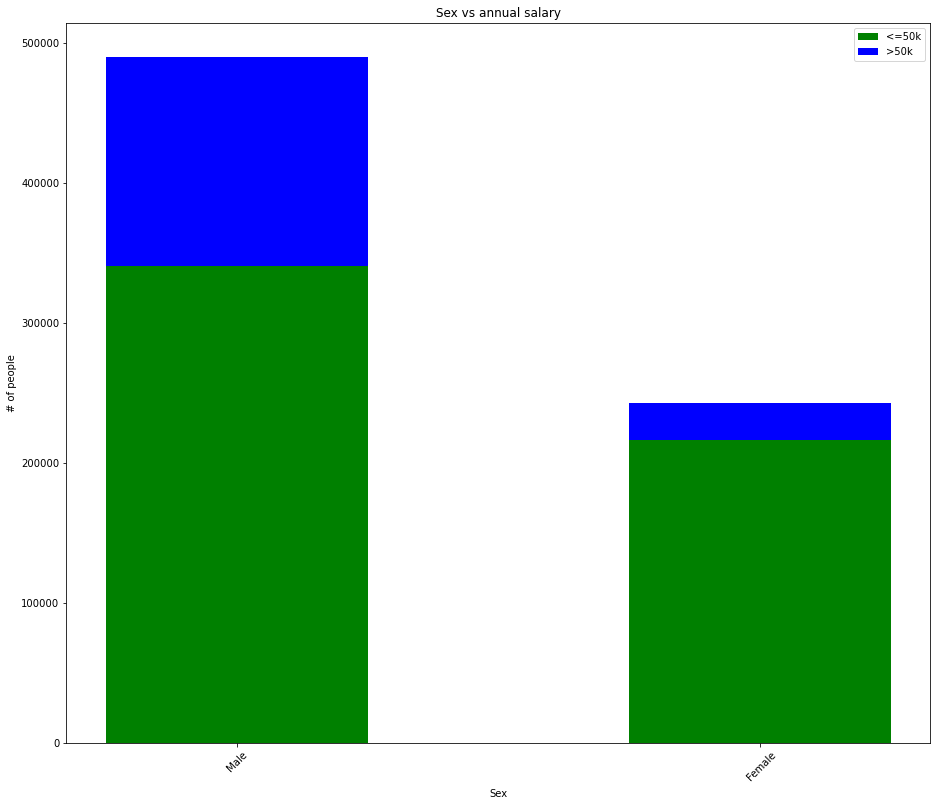

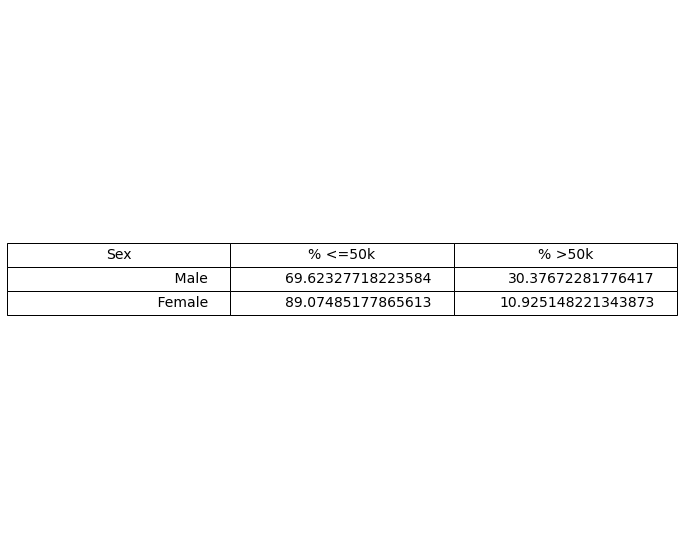

In [189]:
col = ds['sex']
x = col.unique()
xlbl = col.name.capitalize()

y0, y1 = createBarChart(ds, classes, col, x, xlbl, ylbl, 45)
x, y0_p, y1_p = createTable(xlbl, x, y0, y1)

### Capital-gain
#### Bar Chart
Almost everyone in this study had <20,000 for capital gain. From everyone between 0 and 20,000, almost everyone there had 0 capital gain. However, there were a few people making nearly 100,000 in capital gain, and everyone in this category is in the >50k class.
#### Table
Looking at each split under 11,000, there are some splits that extremely favor those who make >50k. Given more data, we could assume a certain salary looking at these splits. Furthermore, looking at the few who have a capital-gain of nearly 100,000 and how it is 100% people in the >50k class, we could make connections with their salaries given more information there as well.
#### Scatterplot
The scatterplot paints the story told in the table - for captain gain under 5000, this is mostly people making <=50k. From 5,000-6,000, this is a fairly even split, then 6,000-7,000, this again favors <=50k salaries. However, capital gain from 7,000 to 20,000 is almost always 100% salaries >50k. There are some splits after 20,000 that switch back and forth, but the highest capital gain is, again, >50k.

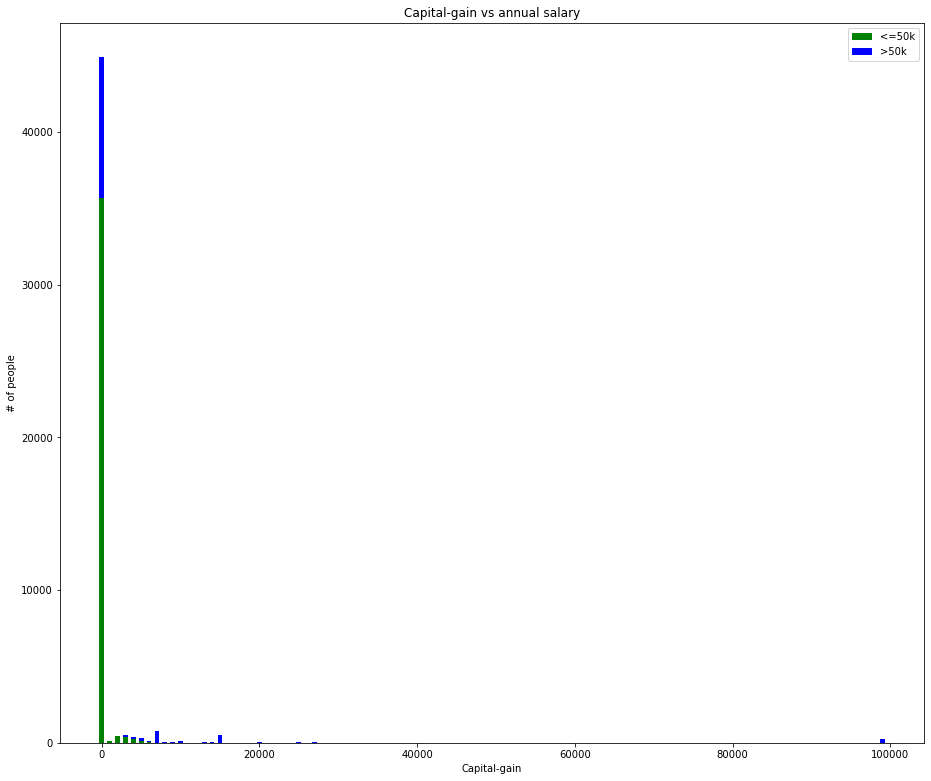

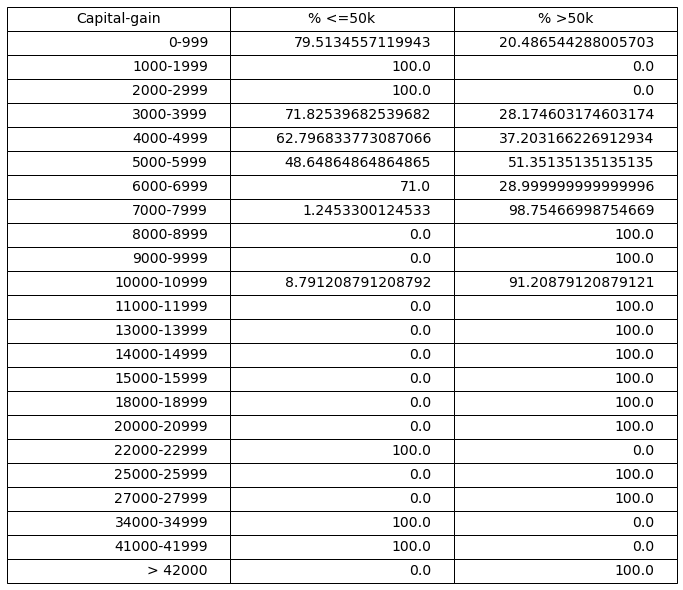

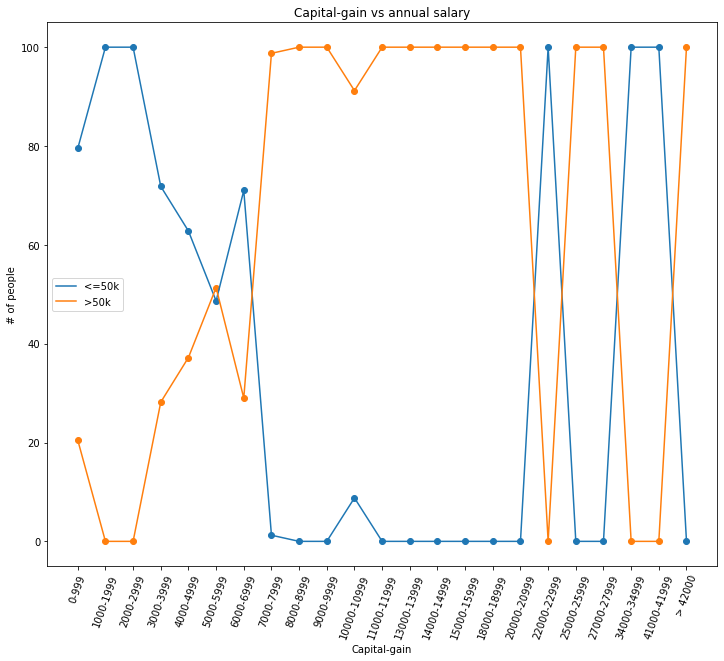

In [190]:
col = ds['capital-gain']
xlbl = col.name.capitalize()

start=0
stop=100000
step=1000

y0, y1 = createBarChartContinuous(ds, classes, col, start, stop, step, xlbl, ylbl, width=600)

vals = list(range(start, stop, step))
x = []
for i in range(len(vals)-1):
    x.append("{}-{}".format(vals[i], vals[i+1]-1))
x, y0_p, y1_p = createTable(xlbl, x, y0, y1, 42000)
showScatter(xlbl, x, y0_p, y1_p, xlbl, ylbl, 70)


### Capital-loss
#### Bar Chart
The bar chart shows, similar to capital gain, most people had 0 capital loss. After 0, there are some samples spread out, but the numbers at 0 capital loss follow the 75-25 trend of the data.
#### Table
The data doesn't show us any obvious trends or correlations, but it does suggest that certain splits favor a group more than other splits. While correlation may not be obvious, it does show it is related in some way.
#### Scatterplot
The scatterplot reinforces the table, not necessarily showing any obvious correlations - the percentages seem to flip-flop in favoritism toward each class.

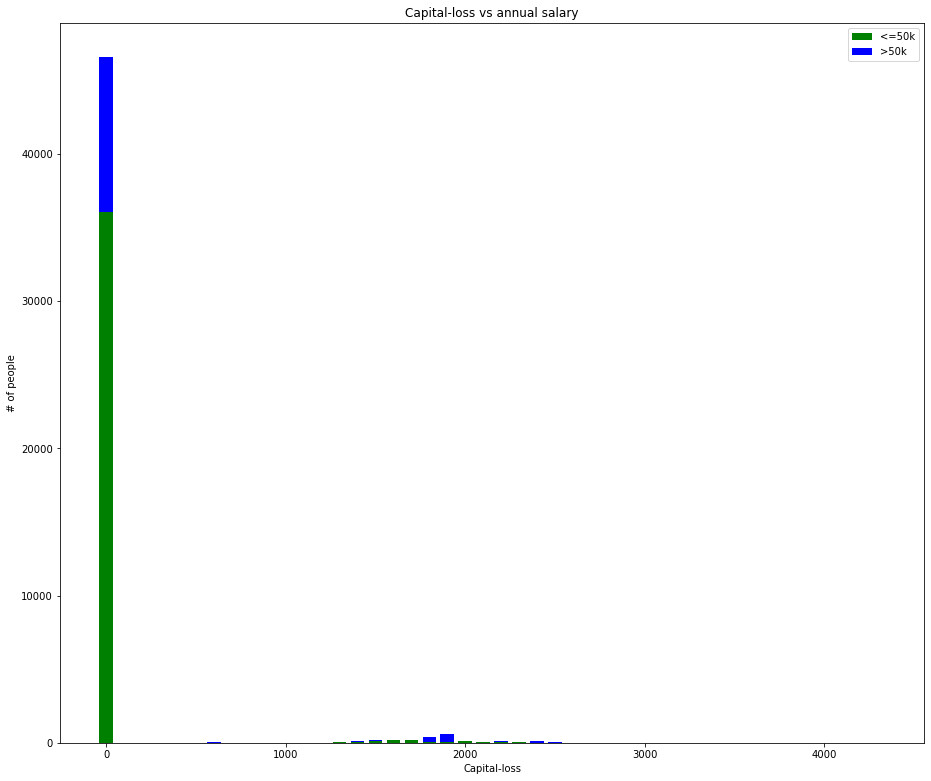

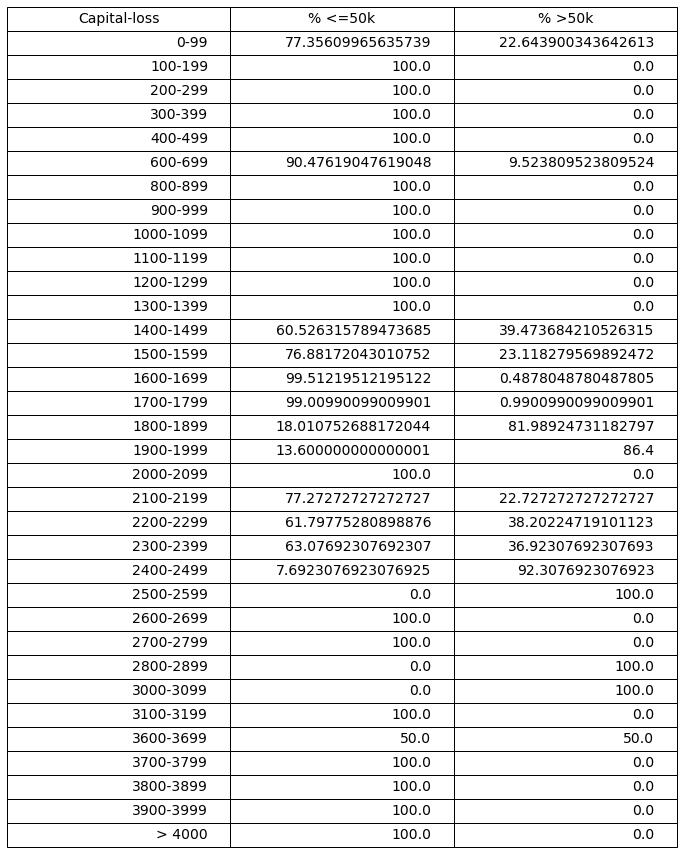

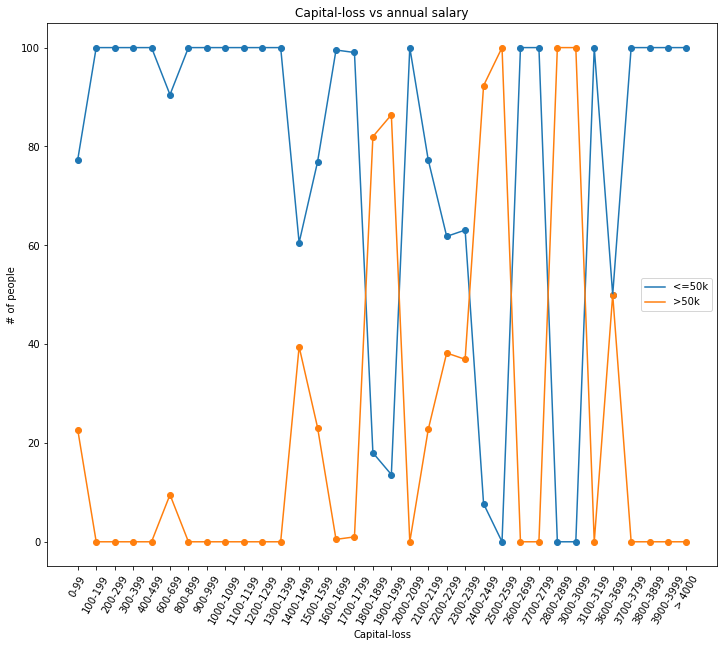

In [191]:
col = ds['capital-loss']
xlbl = col.name.capitalize()

start=0
stop=4400
step=100

y0, y1 = createBarChartContinuous(ds, classes, col, start, stop, step, xlbl, ylbl, width=75)

vals = list(range(start, stop, step))
x = []
for i in range(len(vals)-1):
    x.append("{}-{}".format(vals[i], vals[i+1]-1))
x, y0_p, y1_p = createTable(xlbl, x, y0, y1, 4000)
showScatter(xlbl, x, y0_p, y1_p, xlbl, ylbl, 60)

### Hours-per-week
#### Bar Chart
The graph here shows that most people work an average of 40 hours per week. There are some larger samples at multiples of 5, such as 20, 30, 35, 45, 50, and 60. There is an interesting trend - under 35 hours per week, a very small portion of each group is in the >50k class. This is likely due to working few hours per week, likely as part-time.
#### Table
The table here shows a steady increase in percent of each group making >50k, with 41 hours/week holding 25% in the >50k class. From there, the trend continues steadily upward to greater percentages making >50k, although the more hours worked per week, the more variance and noise there is - higher hours doesn't guarantee making >50k.
#### Scatterplot
Here we can see that general trend upward for increase in percentage of people making >50k, and we can also see that variance. Percent of people per split making >50k increases quickly from 15 to ~45, then from there it appears to not be as correlated, with the scatterplot showing less of a trend.

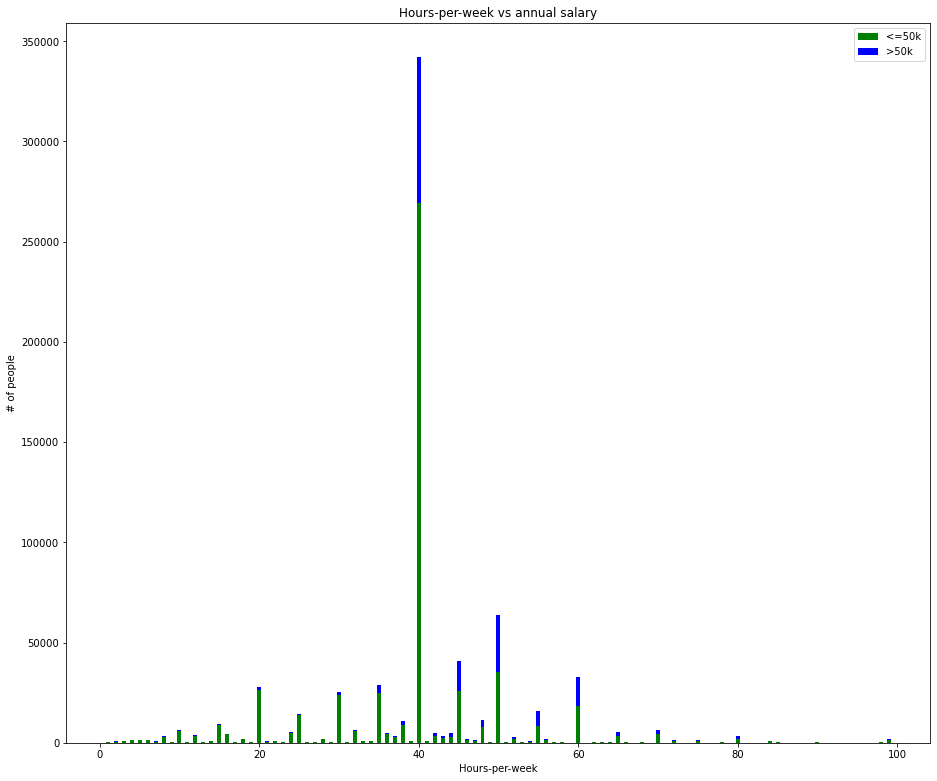

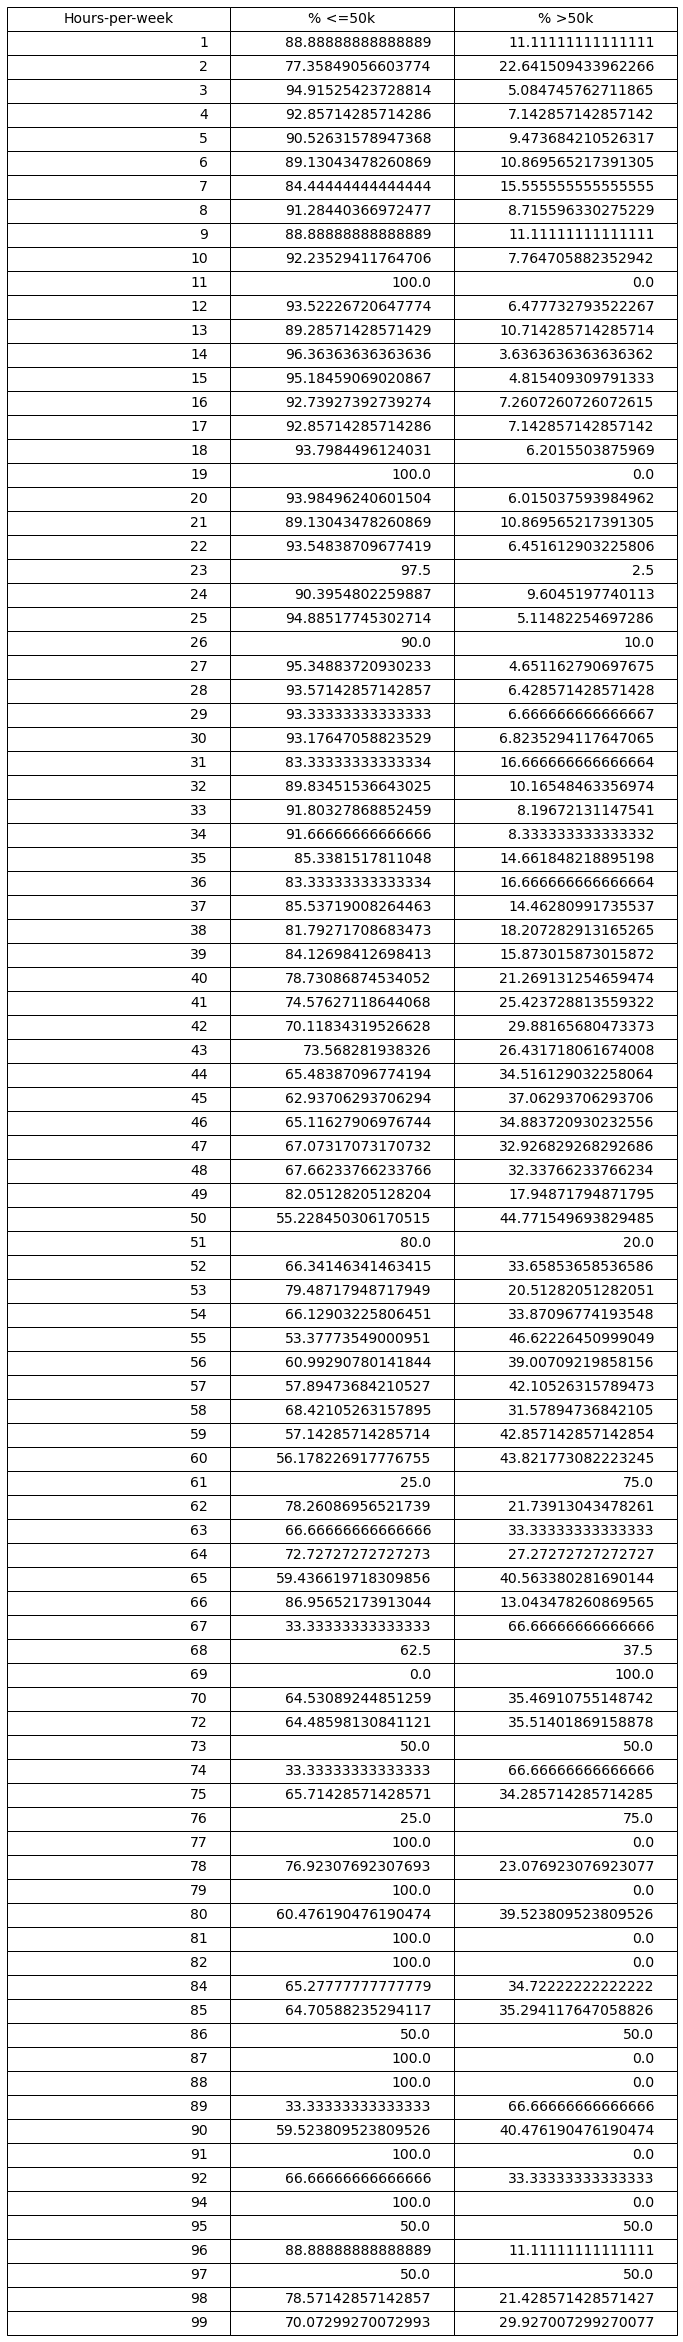

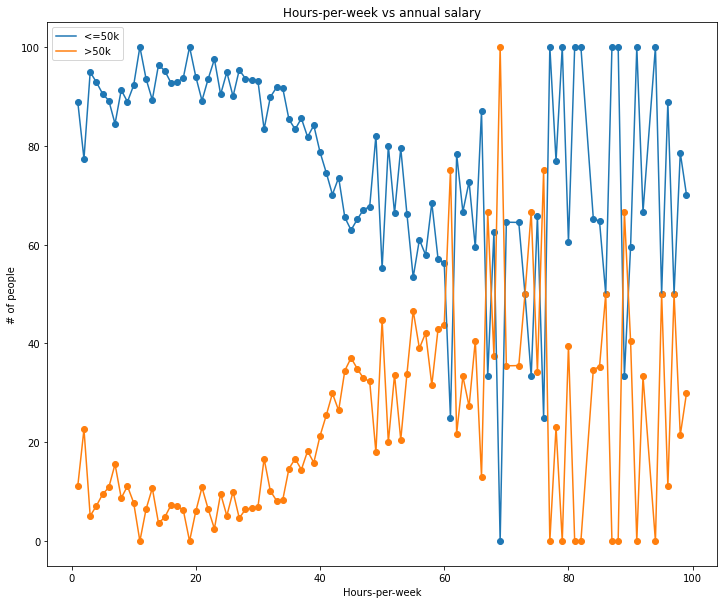

In [192]:
col = ds['hours-per-week']
x = col.unique()
x.sort()
xlbl = col.name.capitalize()

y0, y1 = createBarChart(ds, classes, col, x, xlbl, ylbl)
x, y0_p, y1_p = createTable(xlbl, x, y0, y1)
showScatter(xlbl, x, y0_p, y1_p, xlbl, ylbl)

### Native country
#### Bar Chart
For the united states, there appears to be no correlation. However, for some native countries such as Mexico and India, the percentage of each class is askew, with Mexico having significantly less than what the data shows overall, and India having a higher percentage. There are significantly fewer samples for these native countries, so this could be a biased sample.
#### Table
The table shows many countries having a variance for percentages from what the data holds. Most countries other than the United States have very few samples overall. Because of this, these results could be misleading.

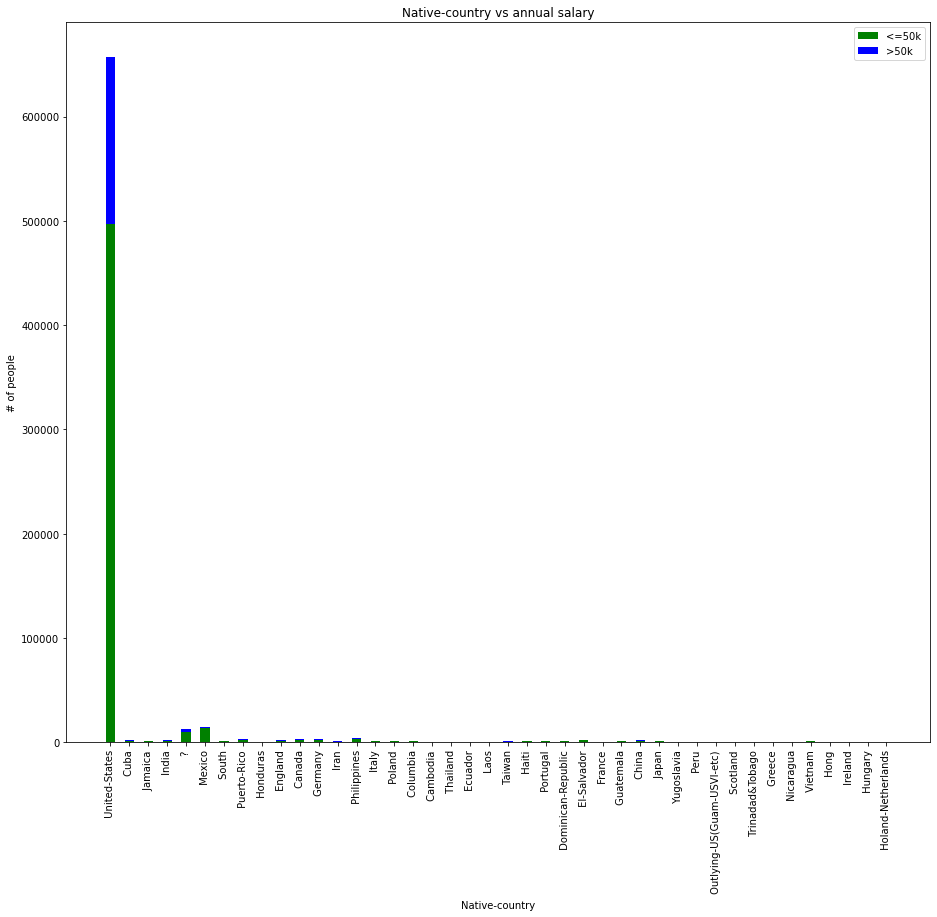

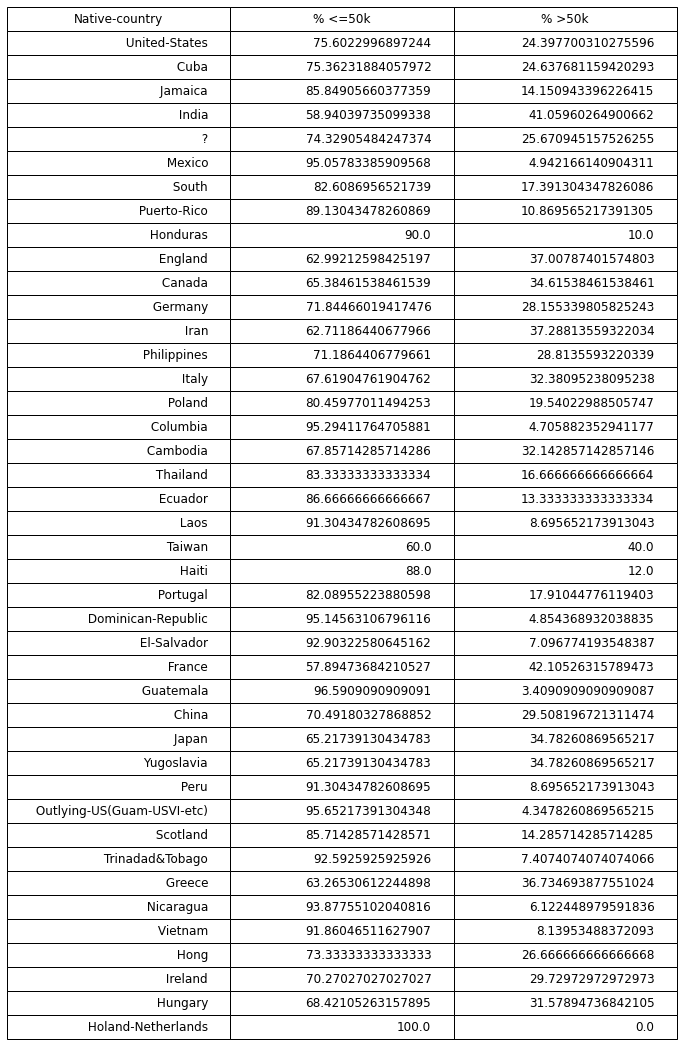

In [193]:
col = ds['native-country']
x = col.unique()
xlbl = col.name.capitalize()

y0, y1 = createBarChart(ds, classes, col, x, xlbl, ylbl, 90)
x, y0_p, y1_p = createTable(xlbl, x, y0, y1)
#showScatter(xlbl, x, y0_p, y1_p, xlbl, ylbl, 90)

## Chi-square-test
Now that we've seen the visualizations of each feature, let's look at how strongly the categorical data is linked to classification using a chi square test.

In [194]:
#Gets the counts of each item for a given column
def get_object_data(ds):
    #Get # of rows in dataset
    total = len(ds)
    feature_probs = {}
    
    for col in ds:
        
        #Don't want to count target col
        if col == 'class':
            continue

        #If column is object, count each item and divide by # of rows
        elif ds[col].dtype == np.dtype('object'):
            feature_probs[col] = ds[col].value_counts().to_dict()

    return feature_probs

In [195]:
from scipy.stats import chi2_contingency 
train_csv, test_csv = load_datasets()
ds = pd.concat([train_csv, test_csv], axis=0)

#Load counts of each subitem for each column in each class
feature_class_counts = {}
classes = train_csv['class'].unique()
for k in classes:
    #Just get the rows belonging to the specific class
    current_class = ds.loc[ds['class'] == k]
    feature_class_counts[k] = get_object_data(current_class)

#Loop through obj columns for each class, get the chi2 and p values
obj_cols = list(feature_class_counts[' <=50K'].keys())
for col in obj_cols:
    keys = list(feature_class_counts[' <=50K'][col].keys()) 
    
    table = defaultdict(list)
    for k in keys:
        for cls in classes:
            try:
                table[k].append(feature_class_counts[cls][col][k])
            except KeyError:
                table[k].append(0)

    obs = np.array(list(table.values()))
    chi2, p, _, _ = chi2_contingency(obs)
    print("{}:\tchi2: {},\tp: {}".format(col, round(chi2, 2), round(p, 2)))
    


workclass:	chi2: 1610.75,	p: 0.0
education:	chi2: 6537.97,	p: 0.0
marital-status:	chi2: 9816.02,	p: 0.0
occupation:	chi2: 5983.16,	p: 0.0
relationship:	chi2: 10088.72,	p: 0.0
race:	chi2: 487.03,	p: 0.0
sex:	chi2: 2248.85,	p: 0.0
native-country:	chi2: 452.23,	p: 0.0


Every categorical variable not only had  p-values below alpha, they were all 0! Meaning every variable is important, although some had pretty large chi2 scores, and some had extremely large chi2 squares. Let's try classifying, then take a look at the analysis.

## ==========================================================

## Data-preprocessing
It's rarely the case where a dataset is ready to be analyzed - normally, there is some data preprocessing that needs to happen. This can include converting columns (as shown already), or pruning (removing columns). There are many steps that can be helpful to take, but here, pruning should show us great results. Given more time, further preprocessing could occur with a deeper analysis of the above visuals, but for now, pruning alone will help.

### Pruning
From what was discussed in the visualization section, some columns are dependent on others or simply have no correlation. While it's not so easy as to say how "important" each column is, there are some we can prune:

* Education - There is already an "education-num" column
* Relationship - Marital status covers this
* Fnlwgt - This came after I googled what exactly fnlwgt was. From the description online, and from what was visualized above with minimal correlation, I decided to remove it to see if results improved (they did).

In [227]:
def prune(ds):
    cols = ['fnlwgt', 'education', 'relationship']
    for col in cols:
        ds.pop(col)
    
    return ds

## ==========================================================

## Classification
For this assessment, I decided to use 3 different approaches for classification:

* Neural Network
* Naive Bayes
* SVM

Before each approach, I will discuss why I chose that approach, the pros and cons to that algorithm, and I will discuss results and visualizations after each algorithm.


In [310]:
def create_confusion_matrix(preds, target):
    plt.figure(figsize=(8, 6))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    cm = confusion_matrix(test_y, preds)
    hm = sns.heatmap(cm, annot=True, xticklabels=['True 0', 'True 1'], yticklabels=['Pred 0', 'Pred 1'])
    hm.xaxis.tick_top() # x axis on top
    hm.xaxis.set_label_position('top')
    return hm

### Neural-network
#### Why I chose this algorithm
Neural networks are increasingly popular in the world of data science and machine learning. They are excellent at recognizing patterns, and can work with vague or even incomplete data. For this dataset, with a high amount of variance with each feature, I believe a neural network would be great at identifying relationships
#### Pros
* Great pattern recognition capabilities
* Hyperparameters can be customized to allow for flexibility
* Datasets can be less complete than what is needed for other algorithms

#### Cons
* Computationally intensive
* "Black box" method - not always clear what is going on in the neural network
* Due to hyperparameters offering so much customization, hard to know exactly what is best with limited time

#### Improvements that could be made to my implementation
* Again, hyperparameters - performing hyperparameter optimization would be ideal, but with limited time, this solution works well enough.
* Defining what type of neural network is best for this type of classification. There are many different types of networks, so spending time to find which is best could show improvements.

In [315]:
#Load and format data
train_csv, test_csv = load_datasets()

#Prune
train_csv = prune(train_csv)
test_csv = prune(test_csv)

#Convert object columns to discrete numerical values
train_csv = convert_to_discrete(train_csv)
test_csv = convert_to_discrete(test_csv)

In [316]:
#Pop the class columns off each dataset to save as targets for each
train_y = train_csv.pop('class')
train_dataset = tf.data.Dataset.from_tensor_slices((train_csv.values, train_y.values))
train_dataset = train_dataset.shuffle(len(train_csv)).batch(32)

test_y = test_csv.pop('class')
test_dataset = tf.data.Dataset.from_tensor_slices((test_csv.values, test_y.values))
test_dataset = test_dataset.shuffle(len(test_csv)).batch(len(test_csv))

In [317]:
#Create model, add 2 hidden layers with relu activation, and compile with adam optimizer
model = tf.keras.Sequential([
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [318]:
#Fit model with train dataset using 500 epochs
start = time.time()
model.fit(train_dataset, epochs=500, verbose=1)
end = time.time()

hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("Runtime of NN: {:0>2}:{:0>2}:{:05.2f} (HH:MM:SS.MS)".format(int(hours),int(minutes),seconds))

Epoch 1/500
1018/1018 [==============================] - 1s 785us/step - loss: 4.7655 - accuracy: 0.7805
Epoch 2/500
1018/1018 [==============================] - 1s 814us/step - loss: 1.4968 - accuracy: 0.8037
Epoch 3/500
1018/1018 [==============================] - 1s 807us/step - loss: 0.9467 - accuracy: 0.8118
Epoch 4/500
1018/1018 [==============================] - 1s 778us/step - loss: 0.7200 - accuracy: 0.8155
Epoch 5/500
1018/1018 [==============================] - 1s 791us/step - loss: 0.8602 - accuracy: 0.8183
Epoch 6/500
1018/1018 [==============================] - 1s 791us/step - loss: 0.5638 - accuracy: 0.8203
Epoch 7/500
1018/1018 [==============================] - 1s 791us/step - loss: 0.4141 - accuracy: 0.8250
Epoch 8/500
1018/1018 [==============================] - 1s 802us/step - loss: 0.3794 - accuracy: 0.8264
Epoch 9/500
1018/1018 [==============================] - 1s 788us/step - loss: 0.3553 - accuracy: 0.8270
Epoch 10/500
1018/1018 [==============================]

1018/1018 [==============================] - 1s 833us/step - loss: 0.3050 - accuracy: 0.8491
Epoch 155/500
1018/1018 [==============================] - 1s 834us/step - loss: 0.3042 - accuracy: 0.8500
Epoch 156/500
1018/1018 [==============================] - 1s 862us/step - loss: 0.3032 - accuracy: 0.8506
Epoch 157/500
1018/1018 [==============================] - 1s 826us/step - loss: 0.3061 - accuracy: 0.8495
Epoch 158/500
1018/1018 [==============================] - 1s 832us/step - loss: 0.3039 - accuracy: 0.8499
Epoch 159/500
1018/1018 [==============================] - 1s 854us/step - loss: 0.3039 - accuracy: 0.8507
Epoch 160/500
1018/1018 [==============================] - 1s 831us/step - loss: 0.3031 - accuracy: 0.8502
Epoch 161/500
1018/1018 [==============================] - 1s 835us/step - loss: 0.3026 - accuracy: 0.8503
Epoch 162/500
1018/1018 [==============================] - 1s 847us/step - loss: 0.3027 - accuracy: 0.8520
Epoch 163/500
1018/1018 [==========================

1018/1018 [==============================] - 1s 827us/step - loss: 0.2918 - accuracy: 0.8563
Epoch 307/500
1018/1018 [==============================] - 1s 833us/step - loss: 0.2915 - accuracy: 0.8567
Epoch 308/500
1018/1018 [==============================] - 1s 845us/step - loss: 0.2899 - accuracy: 0.8568
Epoch 309/500
1018/1018 [==============================] - 1s 834us/step - loss: 0.2906 - accuracy: 0.8563
Epoch 310/500
1018/1018 [==============================] - 1s 852us/step - loss: 0.2893 - accuracy: 0.8575
Epoch 311/500
1018/1018 [==============================] - 1s 855us/step - loss: 0.2906 - accuracy: 0.8572
Epoch 312/500
1018/1018 [==============================] - 1s 833us/step - loss: 0.2909 - accuracy: 0.8582
Epoch 313/500
1018/1018 [==============================] - 1s 838us/step - loss: 0.2898 - accuracy: 0.8569
Epoch 314/500
1018/1018 [==============================] - 1s 832us/step - loss: 0.2888 - accuracy: 0.8563
Epoch 315/500
1018/1018 [==========================

1018/1018 [==============================] - 1s 773us/step - loss: 0.2827 - accuracy: 0.8607
Epoch 459/500
1018/1018 [==============================] - 1s 804us/step - loss: 0.2838 - accuracy: 0.8601
Epoch 460/500
1018/1018 [==============================] - 1s 811us/step - loss: 0.2834 - accuracy: 0.8594
Epoch 461/500
1018/1018 [==============================] - 1s 836us/step - loss: 0.2818 - accuracy: 0.8612
Epoch 462/500
1018/1018 [==============================] - 1s 811us/step - loss: 0.2818 - accuracy: 0.8619
Epoch 463/500
1018/1018 [==============================] - 1s 810us/step - loss: 0.2821 - accuracy: 0.8607
Epoch 464/500
1018/1018 [==============================] - 1s 805us/step - loss: 0.2819 - accuracy: 0.8618
Epoch 465/500
1018/1018 [==============================] - 1s 824us/step - loss: 0.2826 - accuracy: 0.8612
Epoch 466/500
1018/1018 [==============================] - 1s 815us/step - loss: 0.2808 - accuracy: 0.8624
Epoch 467/500
1018/1018 [==========================

#### Neural-network-accuracy

In [319]:
model.evaluate(test_dataset)

1/1 [==============================] - 0s 2ms/step - loss: 0.4032 - accuracy: 0.8461


[0.40315791964530945, 0.846139669418335]

#### Neural-network-CM

In [333]:
#Get numbers for AUROC curve
preds = model.predict(test_csv.to_numpy()).ravel()
nn_fpr, nn_tpr, _ = roc_curve(test_y, preds)
nn_roc_auc = auc(nn_fpr, nn_tpr)

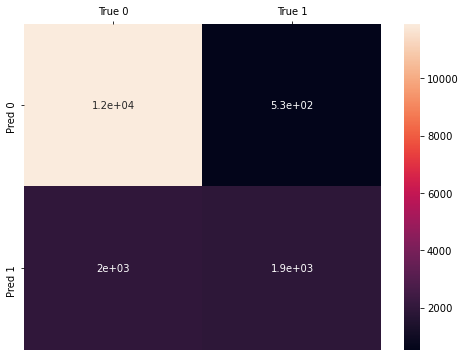

In [321]:
#Creating confusion matrix for proportion
preds = np.where(preds < 0.5, 0, 1)
create_confusion_matrix(preds, test_y)

### Neural-network-results

#### Evaluation
From the above cells, running the evaluate function on the model with the test dataset shows an accuracy of over 0.84, which is excellent. Noticable improvement was seen when feature pruning was introduced (was ~0.78 accuracy).
#### Confusion Matrix
The confusion matrix shows the greatest improvement with feature pruning - before, there were <100 guesses for >50k classifications total. Now, there is a large chunk of true-positives (and false positives). 

## ==========================================================

### Naive-bayes
#### Why I chose this algorithm
Naive bayes are great for classifying large datasets with many features. Computationally, they are significantly faster than most other algorithms. Additionally, this takes a different approach - the assumption with "naive" bayes is that all features are independent. Most other algorithms, such as the neural network, look for patterns among features and classes, but this assumes total independence of each feature from one another.
#### Pros
* Fast
* Simple to implement, fewer hyperparameters to tweak for best results
* When assumption of independence holds true, classifies better than most models

#### Cons
* Due to less hyperparameters, more rigid to results - what you get is what you get
* Anything in test data not in training data will be set to probability 0, and model will be unable to make a prediction for that class
* Assumption of indendence is rarely true

#### Improvements that could be made to my implementation
* Instead of a naive bayes approach, spending time to implement a bayesian network instead where features are related to each other
* Create a generative model for missing data, so model doesn't have to guess 0 if the data is missing

In [322]:
from sklearn.naive_bayes import GaussianNB
#Load
train_csv, test_csv = load_datasets()

#Prune
train_csv = prune(train_csv)
test_csv = prune(test_csv)

#Convert object columns to discrete numerical values
train_csv = convert_to_discrete(train_csv)
test_csv = convert_to_discrete(test_csv)

#Sort into train/test sets
train_y = train_csv.pop('class').to_numpy()
train_x = train_csv.to_numpy()
test_y = test_csv.pop('class').to_numpy()
test_x = test_csv.to_numpy()

#Create Gaussian Naive Bayues, fit, get the y-scores, and show ROC curve
gnb = GaussianNB()
start = time.time()
gnb.fit(train_x, train_y)
end = time.time()

hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("Runtime of NB: {:0>2}:{:0>2}:{:05.2f} (HH:MM:SS.MS)".format(int(hours),int(minutes),seconds))

Runtime of NB: 00:00:00.01 (HH:MM:SS.MS)


#### NB-accuracy

In [334]:
preds = gnb.predict(test_x)
print('Accuracy: {0:.{1}f}'.format((preds == test_y).sum() / len(test_y), 4))

Accuracy: 0.7988


In [335]:
#Get ROC curve variables
nb_score = gnb.predict_proba(test_x)
nb_fpr, nb_tpr, _ = roc_curve(test_y, nb_score[:, 1])
nb_roc_auc = auc(nb_fpr, nb_tpr)

#### NB-CM

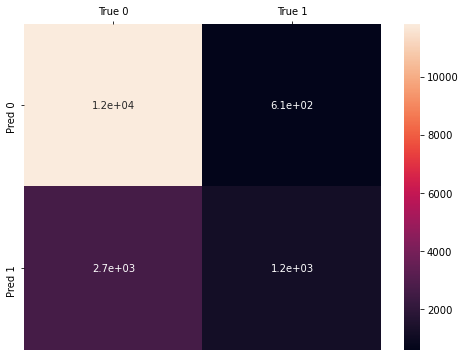

In [324]:
create_confusion_matrix(preds, test_y)

### NB-results
#### Evaluation
From the above cells, running the evaluate function on the model with the test dataset shows an accuracy of nearly 80%.
#### Confusion Matrix
Again, significant improvement thanks to feature pruning. The largest error seems to be with false negatives, likely due to most rows of the training set being in the 0, or <=50k, class.

## ==========================================================

### Support-vector-machines
#### Why I chose this algorithm
Support Vector Machiones work well when there are clear separations between classes. Additionally, SVM's are more effective in high-dimensional spaces.

#### Pros
* Effective in higher dimensions
* Great when classes are separable
* Outliers have less impact

#### Cons
* Very slow
* The more overlap classes have, the worse the performance
* Selecting hyperparameters and kernel functions can be difficult

#### Improvements that could be made to my implementation
* Due to time constraints, I went with scikit's built in SVM. Given time, I'd be able to fiddle around with this more and pick the best options for this SVM
* This one is just a time constraint, but due to the time SVM's take to train, include more samples in the fitting method. I let this run for about 30 minutes at the full training set before I decided to move on.

In [326]:
#Load and format data
train_csv, test_csv = load_datasets()

#Prune
train_csv = prune(train_csv)
test_csv = prune(test_csv)

#Convert object columns to discrete numerical values
train_csv = convert_to_discrete(train_csv)
test_csv = convert_to_discrete(test_csv)

In [327]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


#Get random sample of 20000
train_csv = train_csv.sample(n=20000)
train_y = train_csv.pop('class').to_list()
train_x = train_csv.values.tolist()

test_y = test_csv.pop('class').to_list()
test_x = test_csv.values.tolist()

#Fit SVM
start = time.time()
svm = SVC(kernel='poly', probability=True)
svm.fit(train_x,train_y)
end = time.time()

hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("Runtime of SVM: {:0>2}:{:0>2}:{:05.2f} (HH:MM:SS.MS)".format(int(hours),int(minutes),seconds))

Runtime of SVM: 00:00:15.26 (HH:MM:SS.MS)


#### SVM-accuracy

In [328]:
#Show accuracy
preds = svm.predict(test_x)
print('Accuracy: {0:.{1}f}'.format(accuracy_score(test_y, preds), 4))

Accuracy: 0.7879


In [336]:
#Create AUROC
svm_score = svm.predict_proba(test_x)
svm_fpr, svm_tpr, _ = roc_curve(test_y, svm_score[:, 1])
svm_roc_auc = auc(svm_fpr, svm_tpr)

#### SVM-CM

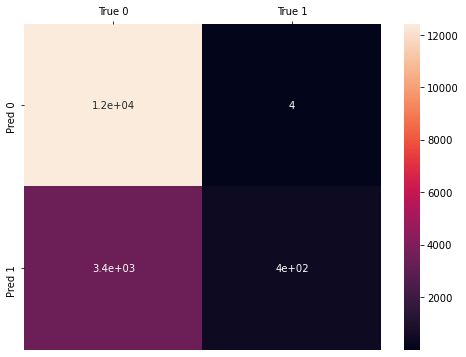

In [329]:
#Show confusion matrix
create_confusion_matrix(preds, test_y)

### SVM-results
#### Evaluation
From the above cells, running the evaluate function on the model with the test dataset shows an accuracy of 0.79. Currently, only 20,000 samples are used for training due to the time it takes for this algorithm to run. I attempted to use a liner kernel on 2,000 samples overnight, and that process either froze or never finished.

#### Confusion Matrix
This confusion matrix shows most classifications leaning away from classifying as >50k. Interestingly, there are only 4 false negatives predicted. I would like to see how this algorithm performs with a linear kernel on the entire dataset, as soon as I get my hands on a space-age computer fast enough to do that training in my lifetime.

## ROC-curves
Displayed here are the 3 ROC curves for each classification algorithm used above.

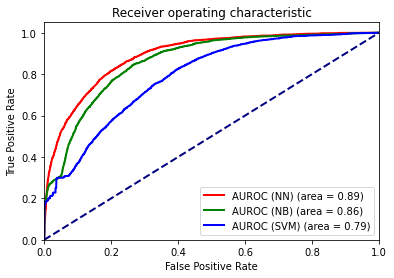

In [337]:
plt.figure()
lw = 2
plt.plot(nn_fpr, nn_tpr, color='r',
         lw=lw, label='AUROC (NN) (area = %0.2f)' % nn_roc_auc)
plt.plot(nb_fpr, nb_tpr, color='g',
         lw=lw, label='AUROC (NB) (area = %0.2f)' % nb_roc_auc)
plt.plot(svm_fpr, svm_tpr, color='b',
         lw=lw, label='AUROC (SVM) (area = %0.2f)' % svm_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Above, we can see how each algorithm did, with the neural network having the greatest area under the ROC curve, followed by the naive-bayes algorithm, and lastly with the SVM. 
* I anticipated the NN doing extremely well, as finding the common segments and patterns here would be a fitting task for such an algorithm. 
* I am surprised by the naive bayes a bit - later, I will discuss how these features relate, and naive bayes assumes feature independence. 
* It's not too surprising to see the SVM not doing as well, given the time constraint - again, more time would have likely shown a better bit

## ==========================================================

## Segmentation

One way to segment would be to try and group people based on analysis of the above attributes
* Age - Seems to be trend, middle ages have higher percentages of people making >50k compared to data
* Workclass - Certain classes, such as self-empl-inc, have higher percentages of people making >50k compared to data
* Education - Higher education correlates to higher percentages of people making >50k compared to data
* Marital Status - Married people have higher percentages of people making >50k compared to data
* Occupation - Some jobs, such as managers/executives, have higher percentages of people making >50k compared to data
* Relationship - Married people have higher percentages of people making >50k compared to data
* Race - Certain races have lower percentages of people making >50k compared to data
* Sex - Men tend to have higher percentages of people making >50k compared to data
* Capital Gain - Certain splits, such as 7,000-20,000, higher percentages of people making >50k compared to data
* Native Country - Some countries have higher or lower percentages of people making >50k compared to data

Looking further at these features, several of these are related: Age, Workclass, Education, Marital Status, Occupation, Relationship, and possibly Capital Gain.
* Generally, it takes a person many years to finish a Masters, and even longer to finish a Doctoral degree (linked to higher percentages)
* Additionally, people don't often start at the manager/executive level - this takes several years
* While many younger people do get married, it is often something that takes time

Because of this, a person's age is a factor in their occupation, education, marital status, and most of what affects their income.

Given this information, we could segment certain demographics, such as married men, or executives. Let's look at a few segments from the above information.



### Manual-segmentation

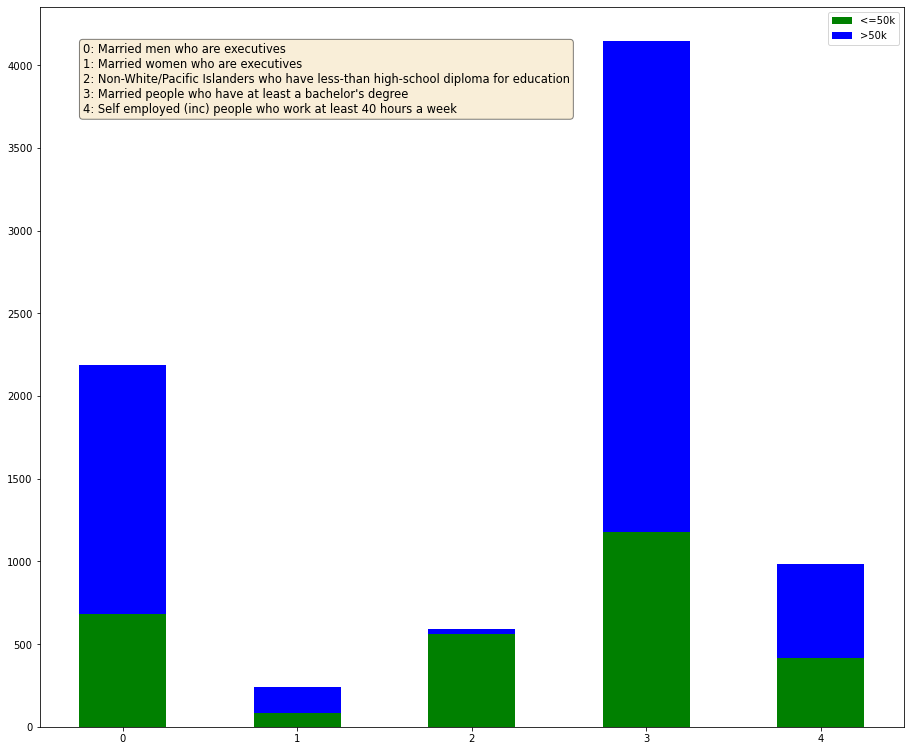

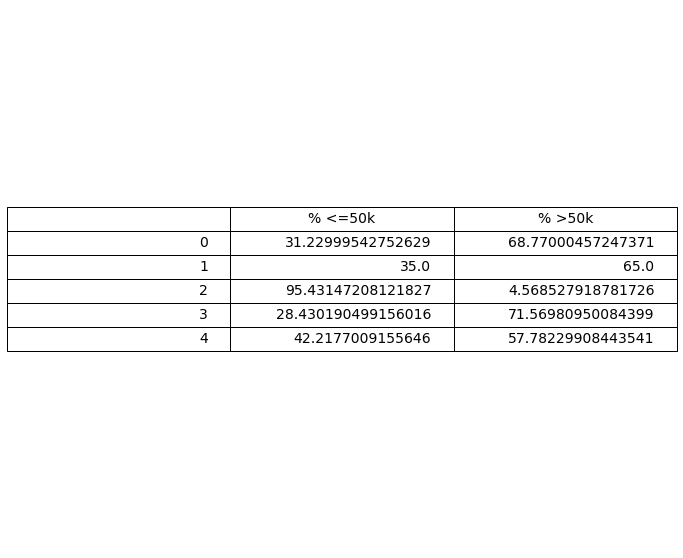

In [38]:
#First segment - married men who are executives
train_csv, test_csv = load_datasets()

train_csv['class'] = pd.Categorical(train_csv['class'])
train_csv['class'] = train_csv['class'].cat.codes
ds = pd.concat([train_csv, test_csv], axis=0)
segments = []

temp = ds.loc[(ds['relationship'] == ' Husband') & (ds['occupation'] == ' Exec-managerial')]
lte50k = len(temp.loc[temp['class'] == 0].index)
gt50k = len(temp.loc[temp['class'] == 1].index)
segments.append([lte50k, gt50k])

#Second segment - married women who are executives
temp = ds.loc[(ds['relationship'] == ' Wife') & (ds['occupation'] == ' Exec-managerial')]
lte50k = len(temp.loc[temp['class'] == 0].index)
gt50k = len(temp.loc[temp['class'] == 1].index)
segments.append([lte50k, gt50k])

#Third segment - non-white/pacific islanders who have little education
lower_educations = [' 12th', ' 10th', ' 5th-6th', ' 1st-4th', ' Preschool' ' 7th-8th', ' 9th', ' 11th']
temp = ds.loc[(ds['race'] != ' White') & (ds['race'] != ' Asian-Pac-Islander') & (ds['education'].isin(lower_educations))]                                                                         
lte50k = len(temp.loc[temp['class'] == 0].index)
gt50k = len(temp.loc[temp['class'] == 1].index)
segments.append([lte50k, gt50k])

#Fourth segment - married people who have at least a bachelors degree
higher_educations =[' Prof-school', 'Doctorate', ' Masters', ' Bachelors']
temp = ds.loc[((ds['relationship'] == ' Husband') | (ds['relationship'] == ' Wife')) & (ds['education'].isin(higher_educations))]                                                                       
lte50k = len(temp.loc[temp['class'] == 0].index)
gt50k = len(temp.loc[temp['class'] == 1].index)
segments.append([lte50k, gt50k])

#Fifth segment - self-empl-inc who work at least 40 hours per week
temp = ds.loc[(ds['workclass'] == ' Self-emp-inc') & (ds['hours-per-week'] >= 40)]
lte50k = len(temp.loc[temp['class'] == 0].index)
gt50k = len(temp.loc[temp['class'] == 1].index)
segments.append([lte50k, gt50k])

#Create bargraph
y0 = [i[0] for i in segments]
y1 = [i[1] for i in segments]
x = np.arange(len(y0))
width = 0.5
fig = plt.figure(1, figsize=(12, 10))
ax = fig.add_axes([0,0,1,1])
ax.bar(x, y0, width, color='g', label='<=50k')
ax.bar(x, y1, width,bottom=y0, color='b', label='>50k')
x = ['0: Married men who are executives', 
'1: Married women who are executives',
'2: Non-White/Pacific Islanders who have less-than high-school diploma for education',
'3: Married people who have at least a bachelor\'s degree',
'4: Self employed (inc) people who work at least 40 hours a week']

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, '\n'.join(x), transform=ax.transAxes, fontsize=11.5,
        verticalalignment='top',horizontalalignment='left', bbox=props)
ax.legend()
plt.show()

#Create table
y0_p = []
y1_p  = []
for i in range(len(y0)):
    y0_p.append((y0[i]/(y0[i]+y1[i]))*100)
    y1_p.append((y1[i]/(y0[i]+y1[i]))*100)

x = np.arange(len(x))
table_data = []
for i in range(len(y0)):
    table_data.append([x[i], y0_p[i], y1_p[i]])

cols = ['', '% <=50k', '% >50k']
g = plt.figure(2, figsize=(12, 10))
ax = g.add_subplot(1,1,1)
table = ax.table(cellText=table_data, colLabels = cols, loc='center')
table.set_fontsize(14)
table.scale(1,2)
ax.axis('off')
plt.show()

Above, we see several segments that could be made, both signficantly greater percent in the >50k class, and one for significantly less. There are more segments that could be made by hand that will give both above and below average percentages, but I will be doing something different.

### Automated-segmentation

One last approach that I will showcase for segmenting - we could instead use a brute force method, analyzing certain datasets that perform better in our training set.
An problem with a brute force method is trying to analyze all features - unfortunately, if we did that, there are 8,628,360,700,000,000 possible items in the set of cartesian products for all features.

If we remove certain features and focus only on a few, we get a more manageable number of datasets - 6,350,400, to be exact.

Features to remove:
* Ages - as discussed above, age is reflected in many other features, which will be on this list
* Relationship - same as marital status
* Capital Gain/Capital Loss - too many items to include, also reflected through other features
* Hours per week - too many items to include, also reflected through other features

Below, we will save notable results - those that have >=15 matching cases, into a text file for future use.

In [12]:
train_csv, test_csv = load_datasets()
train_csv.pop('education-num')
test_csv.pop('education-num')
feat_atts = defaultdict(list)


#Workclasses
feat_atts['workclass'] = train_csv['workclass'].unique()

#Education
feat_atts['education'] = train_csv['education'].unique()

#Marital-status
feat_atts['marital-status'] = train_csv['marital-status'].unique()

#Occupation
feat_atts['occupation'] = train_csv['occupation'].unique()

#Race
feat_atts['race'] = train_csv['race'].unique()

#Sex
feat_atts['sex'] = train_csv['sex'].unique()


#Native country
feat_atts['native-country'] = train_csv['native-country'].unique()


In [13]:
import itertools
from collections import Counter
from random import shuffle

#Create cartesian product list of all possible combinations for each sublist
cart_prod = list(itertools.product(*list(feat_atts.values())))
#Shuffle (used for testing purposes, no impact on production)
shuffle(cart_prod)
#Create defaultdict which defaults to counter
cart_prod_dict = defaultdict(Counter)
#Columns used in brute force method
cols_of_importance = ['workclass', 'education', 'marital-status', 'occupation', 'race', 'sex', 'native-country']

In [ ]:
#Convert train_csv to 0's and 1's
train_csv['class'] = pd.Categorical(train_csv['class'])
train_csv['class'] = train_csv['class'].cat.codes

def check_combinations(comb_set):
    #Count which combination currently checking
    for count, comb in enumerate(comb_set):
        #Create temporary copy of train_csv dataset
        temp = train_csv.copy(True)
        #Loop through every column specified, and narrow down the temp dataset based on current combination and specified column
        for i, col in enumerate(cols_of_importance):
            temp = temp.loc[temp[col] == comb[i]]
        
        #Count rows with class <=50k and >50k
        lte50k = len(temp.loc[temp['class'] == 0].index)
        gt50k = len(temp.loc[temp['class'] == 1].index)
        
        #Add counts to counter at specified combination
        cart_prod_dict[comb][0] += lte50k
        cart_prod_dict[comb][1] += gt50k
        
start = time.time()
check_combinations(cart_prod)
end = time.time()
    
with open('brute_force_results.data', 'w') as f:
    #End timer and display results in HH:MM:SS.MS
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    f.write("Runtime of brute force method: {:0>2}:{:0>2}:{:05.2f} (HH:MM:SS.MS)\n\n".format(int(hours),int(minutes),seconds))

    #Go through each result, calculate if significant
    notable_results = {}
    for k, v in cart_prod_dict.items():
        if v[0] + v[1] >= 15:
            perc = v[1] / (v[0] + v[1])
            if perc <= 0.2 or perc >= 0.3:
                notable_results[k] = [v[0], v[1], (v[1] / (v[0] + v[1])) * 100]
    notable_results = sorted(notable_results.items(), key=lambda x: x[1][2], reverse=True)

    #Display results of significance
    f.write('Results sorted by descending % >50k\nKeywords are from the below columns, in order:\nWorkclass, Education, Marital-status, Occupation, Race, Sex, Country-of-origin')
    f.write('='*75)
    f.write('\n')

    for i in notable_results:
        #print("{}\n<=50k: {}, >50k: {}, % >50k: {:.2f}%\n".format(i[0], i[1][0], i[1][1], i[1][2]))
        f.write("{}\n<=50k: {}, >50k: {}, % >50k: {:.2f}%\n".format(i[0], i[1][0], i[1][1], i[1][2]))



In [15]:
data = defaultdict(str)
with open('brute_force_results.data', 'r') as f:
    for x, line in enumerate(f):
        #First 7 lines are just header lines
        if x > 7:
            #Some newlines in data
            if line == '\n':
                continue
            #print(x, line)
            if x % 3 == 2:
                key = line.strip(' \t\n\r')
            elif x % 3 == 0:
                data[key] = line
        else:
            print(line)
    
sorted_data = {}               
for k in data.keys():
    temp = data[k].replace('\n', '').replace('<=50k', '0').replace('>50k', '1').replace('% 1', '%')[:-1].split(', ')
    #print(temp[0], key)
    temp_dict = {0: int(temp[0][temp[0].find(' ')+1:]),
                1: int(temp[1][temp[1].find(' ')+1:]),
                '%': float(temp[2][temp[2].find(' ')+1:])}
    sorted_data[k] = temp_dict
    
sorted_data = sorted(sorted_data.items(), key=lambda x: x[1]['%'], reverse=True)

for i in sorted_data:
    print(i[0], '\n', i[1], '\n')



Runtime of brute force method: 12:43:33.08 (HH:MM:SS.MS)



Results sorted by descending % >50k

Keywords are from the below columns, in order:

Workclass, Education, Marital-status, Occupation, Race, Sex, Country-of-origin






(' Self-emp-inc', ' Prof-school', ' Married-civ-spouse', ' Prof-specialty', ' White', ' Male', ' United-States') 
 {0: 1, 1: 56, '%': 98.25} 

(' Private', ' Doctorate', ' Married-civ-spouse', ' Exec-managerial', ' White', ' Male', ' United-States') 
 {0: 1, 1: 15, '%': 93.75} 

(' Federal-gov', ' Some-college', ' Married-civ-spouse', ' Exec-managerial', ' White', ' Male', ' United-States') 
 {0: 1, 1: 14, '%': 93.33} 

(' Private', ' Masters', ' Married-civ-spouse', ' Exec-managerial', ' White', ' Male', ' United-States') 
 {0: 12, 1: 159, '%': 92.98} 

(' Local-gov', ' Masters', ' Married-civ-spouse', ' Exec-managerial', ' White', ' Male', ' United-States') 
 {0: 3, 1: 24, '%': 88.89} 

(' State-gov', ' Doctorate', ' Married-civ-spouse', ' Prof-specialty', '

In [16]:
cat_counts = [0, 0]
for i in sorted_data:
    if i[1]['%'] < 25:
        cat_counts[0]+=1
    else:
        cat_counts[1]+=1

lt25p = round((cat_counts[0] / (cat_counts[0]+cat_counts[1])*100), 2)
gte25p = round((cat_counts[1] / (cat_counts[0]+cat_counts[1])*100), 2)
print('{}, or {}% of categories with <25% making >50k'.format(cat_counts[0], lt25p))
print('{}, or {}% of categories with over >=25% making >50k'.format(cat_counts[1], gte25p))
print()
people_counts = [[0, 0], [0, 0]]
for i in sorted_data:
    if i[1]['%'] < 25:
        people_counts[0][0]+=i[1][0]
        people_counts[0][1]+=i[1][1]
    else:
        people_counts[1][0]+=i[1][0]
        people_counts[1][1]+=i[1][1]

lt25p = round((people_counts[0][1]/(people_counts[0][0]+people_counts[0][1])*100), 2)
gte25p = round((people_counts[1][1]/(people_counts[1][0]+people_counts[1][1])*100), 2)
print('{} are in the "<25% making >50k" categories. Of those people, there are {}% making >50k'.format(people_counts[0][0]+people_counts[0][1], lt25p))
print('{} are in the ">=25% making >50k" categories. Of those people, there are {}% making >50k'.format(people_counts[1][0]+people_counts[0][1], gte25p))

208, or 63.22% of categories with <25% making >50k
121, or 36.78% of categories with over >=25% making >50k

9989 are in the "<25% making >50k" categories. Of those people, there are 4.49% making >50k
3964 are in the ">=25% making >50k" categories. Of those people, there are 56.36% making >50k


From the above results, we can clearly see some very interesting trends based on the categorical data alone.
* The best performing category, with 56 out of 57 samples making >50k, are self-emp-inc, have prof-school education, are married-civ-spouse, have prof-specialty occupation, are white males, and live in the US.
* Almost every category above 40% has 'Married-civ-spouse' for marital status.
* Workclass alone doesn't seem to be as correlated to success - the top 6 performing categories all have different workclasses. However, many poor performing categories seem to have 'Private' for the workclass.
* Although 'White' is seen as race for most high-performers, it is also seen frequently in the average and low performers. This shows that 'White' was the largest race involved in this sample.
* There doesn't appear to be many, if any, native countries other than 'United-States'. This could be due to numerical features not included in this selection, or it shows less of a correlation for notable categories.
* 2/3 of notable categories have <25% making >50k, while the last third has >=25%.

Additional statistics in the second cell:
* The percent of people in the >=25% making >50k category is over 1200% more than those in the <25% making 50k category.
* The percent in both sections shows a great variance compared to the 25/75 split seen in the data above.